# Station QU39 analysis

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib as mpl
import netCDF4 as nc
import datetime as dt
from salishsea_tools import evaltools as et, places, viz_tools, visualisations, bloomdrivers
import xarray as xr
import pandas as pd
import pickle
import os
import seaborn as sns
import cmocean
import pylab


%matplotlib inline

### To recreate this notebook at a different location, follow these instructions: 

In [33]:
# The path to the directory where the pickle files are stored:
savedir='/ocean/aisabell/MEOPAR/extracted_files'
# Change 'S3' to the location of interest
loc='QU39'
# What is the start year and end year+1 of the time range of interest?
startyear=2007
endyear=2021 # does NOT include this value
# Note: What is the model run?

# Note: non-location specific variables only need to be done for each year, not for each location
# Note: xticks in the plots will need to be changed
# Note: 201812 bloom timing variable load and plotting will also need to be removed

1.1363636363636362

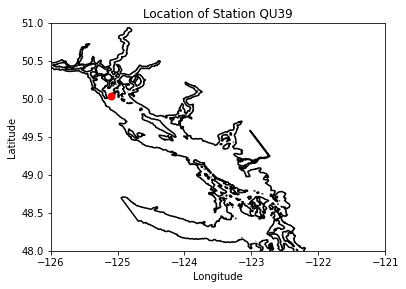

In [34]:
modver='201905'
# lat and lon information for place:
lon,lat=places.PLACES[loc]['lon lat']
# get place information on SalishSeaCast grid:
ij,ii=places.PLACES[loc]['NEMO grid ji']
jw,iw=places.PLACES[loc]['GEM2.5 grid ji']

fig, ax = plt.subplots(1,1,figsize = (6,6))
with xr.open_dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/mesh_mask201702.nc') as mesh:
    ax.contour(mesh.nav_lon,mesh.nav_lat,mesh.tmask.isel(t=0,z=0),[0.1,],colors='k')
    tmask=np.array(mesh.tmask)
    gdept_1d=np.array(mesh.gdept_1d)
    e3t_0=np.array(mesh.e3t_0)
ax.plot(lon, lat, '.', markersize=14, color='red')
ax.set_ylim(48,51)
ax.set_xlim(-126,-121)
ax.set_title('Location of Station %s'%loc)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
viz_tools.set_aspect(ax,coords='map')

### Strait of Georgia Region:

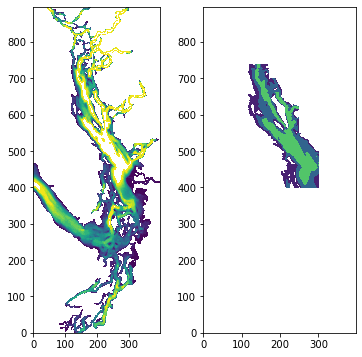

In [35]:
# define sog region:
fig, ax = plt.subplots(1,2,figsize = (6,6))
with xr.open_dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/bathymetry_201702.nc') as bathy:
    bath=np.array(bathy.Bathymetry)
ax[0].contourf(bath,np.arange(0,250,10))
viz_tools.set_aspect(ax[0],coords='grid')
sogmask=np.copy(tmask[:,:,:,:])
sogmask[:,:,740:,:]=0
sogmask[:,:,700:,170:]=0
sogmask[:,:,550:,250:]=0
sogmask[:,:,:,302:]=0
sogmask[:,:,:400,:]=0
sogmask[:,:,:,:100]=0
#sogmask250[bath<250]=0
ax[1].contourf(np.ma.masked_where(sogmask[0,0,:,:]==0,bathy.Bathymetry),[0,100,250,550])

###  *** Stop and check, have you made pickle files for all the years? ***

In [36]:
# loop through years of spring time series (mid feb-june) for bloom timing for 201905 run
years=list()
bloomtime1=list()
bloomtime2=list()
bloomtime3=list()
for year in range(startyear,endyear):
    fname3=f'springBloomTime_{str(year)}_{loc}_{modver}.pkl'
    savepath3=os.path.join(savedir,fname3)
    bio_time0,sno30,sdiat0,sflag0,scili0,diat_alld0,no3_alld0,flag_alld0,cili_alld0,phyto_alld0,\
                 intdiat0,intphyto0,fracdiat0,sphyto0,percdiat0=pickle.load(open(savepath3,'rb'))
    # put code that calculates bloom timing here
    bt1=bloomdrivers.metric1_bloomtime(phyto_alld0,no3_alld0,bio_time0)
    bt2=bloomdrivers.metric2_bloomtime(sphyto0,sno30,bio_time0)
    bt3=bloomdrivers.metric3_bloomtime(sphyto0,sno30,bio_time0)
    years.append(year)
    bloomtime1.append(bt1)
    bloomtime2.append(bt2)
    bloomtime3.append(bt3)   
years=np.array(years)
bloomtime1=np.array(bloomtime1)
bloomtime2=np.array(bloomtime2)
bloomtime3=np.array(bloomtime3)

# get year day
yearday1=et.datetimeToYD(bloomtime1)  # convert to year day tool
yearday2=et.datetimeToYD(bloomtime2)
yearday3=et.datetimeToYD(bloomtime3)

### Combine separate year files into arrays:

In [37]:
# loop through years (for location specific drivers)

years=list()
windjan=list()
windfeb=list()
windmar=list()
solarjan=list()
solarfeb=list()
solarmar=list()
parjan=list()
parfeb=list()
parmar=list()
tempjan=list()
tempfeb=list()
tempmar=list()
saljan=list()
salfeb=list()
salmar=list()
zoojan=list()
zoofeb=list()
zoomar=list()
mesozoojan=list()
mesozoofeb=list()
mesozoomar=list()
microzoojan=list()
microzoofeb=list()
microzoomar=list()
intzoojan=list()
intzoofeb=list()
intzoomar=list()
intmesozoojan=list()
intmesozoofeb=list()
intmesozoomar=list()
intmicrozoojan=list()
intmicrozoofeb=list()
intmicrozoomar=list()
midno3jan=list()
midno3feb=list()
midno3mar=list()

for year in range(startyear,endyear):
    fname=f'JanToMarch_TimeSeries_{year}_{loc}_{modver}.pkl'
    savepath=os.path.join(savedir,fname)
    bio_time,diat_alld,no3_alld,flag_alld,cili_alld,microzoo_alld,mesozoo_alld,\
            intdiat,intphyto,spar,intmesoz,intmicroz,grid_time,temp,salinity,u_wind,v_wind,twind,\
            solar,no3_30to90m,sno3,sdiat,sflag,scili,intzoop,fracdiat,zoop_alld,sphyto,phyto_alld,\
            percdiat,wspeed,winddirec=pickle.load(open(savepath,'rb'))
    # put code that calculates drivers here
    wind=bloomdrivers.D1_3monthly_avg(twind,wspeed)
    solar=bloomdrivers.D1_3monthly_avg(twind,solar)
    par=bloomdrivers.D1_3monthly_avg(bio_time,spar)
    temp=bloomdrivers.D1_3monthly_avg(grid_time,temp)
    sal=bloomdrivers.D1_3monthly_avg(grid_time,salinity)
    zoo=bloomdrivers.D2_3monthly_avg(bio_time,zoop_alld)
    mesozoo=bloomdrivers.D2_3monthly_avg(bio_time,mesozoo_alld)
    microzoo=bloomdrivers.D2_3monthly_avg(bio_time,microzoo_alld)
    intzoo=bloomdrivers.D1_3monthly_avg(bio_time,intzoop)
    intmesozoo=bloomdrivers.D1_3monthly_avg(bio_time,intmesoz)
    intmicrozoo=bloomdrivers.D1_3monthly_avg(bio_time,intmicroz)
    midno3=bloomdrivers.D1_3monthly_avg(bio_time,no3_30to90m)
    
    years.append(year)
    windjan.append(wind[0])
    windfeb.append(wind[1])
    windmar.append(wind[2])   
    solarjan.append(solar[0])
    solarfeb.append(solar[1])
    solarmar.append(solar[2])
    parjan.append(par[0])
    parfeb.append(par[1])
    parmar.append(par[2])
    tempjan.append(temp[0])
    tempfeb.append(temp[1])
    tempmar.append(temp[2])
    saljan.append(sal[0])
    salfeb.append(sal[1])
    salmar.append(sal[2])
    zoojan.append(zoo[0])
    zoofeb.append(zoo[1])
    zoomar.append(zoo[2])
    mesozoojan.append(mesozoo[0])
    mesozoofeb.append(mesozoo[1])
    mesozoomar.append(mesozoo[2])
    microzoojan.append(microzoo[0])
    microzoofeb.append(microzoo[1])
    microzoomar.append(microzoo[2])
    intzoojan.append(intzoo[0])
    intzoofeb.append(intzoo[1])
    intzoomar.append(intzoo[2])
    intmesozoojan.append(intmesozoo[0])
    intmesozoofeb.append(intmesozoo[1])
    intmesozoomar.append(intmesozoo[2])
    intmicrozoojan.append(intmicrozoo[0])
    intmicrozoofeb.append(intmicrozoo[1])
    intmicrozoomar.append(intmicrozoo[2])
    midno3jan.append(midno3[0])
    midno3feb.append(midno3[1])
    midno3mar.append(midno3[2])

years=np.array(years)
windjan=np.array(windjan)
windfeb=np.array(windfeb)
windmar=np.array(windmar)
solarjan=np.array(solarjan)
solarfeb=np.array(solarfeb)
solarmar=np.array(solarmar)
parjan=np.array(parjan)
parfeb=np.array(parfeb)
parmar=np.array(parmar)
tempjan=np.array(tempjan)
tempfeb=np.array(tempfeb)
tempmar=np.array(tempmar)
saljan=np.array(saljan)
salfeb=np.array(salfeb)
salmar=np.array(salmar)
zoojan=np.array(zoojan)
zoofeb=np.array(zoofeb)
zoomar=np.array(zoomar)
mesozoojan=np.array(mesozoojan)
mesozoofeb=np.array(mesozoofeb)
mesozoomar=np.array(mesozoomar)
microzoojan=np.array(microzoojan)
microzoofeb=np.array(microzoofeb)
microzoomar=np.array(microzoomar)
intzoojan=np.array(intzoojan)
intzoofeb=np.array(intzoofeb)
intzoomar=np.array(intzoomar)
intmesozoojan=np.array(intmesozoojan)
intmesozoofeb=np.array(intmesozoofeb)
intmesozoomar=np.array(intmesozoomar)
intmicrozoojan=np.array(intmicrozoojan)
intmicrozoofeb=np.array(intmicrozoofeb)
intmicrozoomar=np.array(intmicrozoomar)
midno3jan=np.array(midno3jan)
midno3feb=np.array(midno3feb)
midno3mar=np.array(midno3mar)

In [38]:
# loop through years (for non-location specific drivers)
fraserjan=list()
fraserfeb=list()
frasermar=list()
deepno3jan=list()
deepno3feb=list()
deepno3mar=list()

for year in range(startyear,endyear):
    fname2=f'JanToMarch_TimeSeries_{year}_{modver}.pkl'
    savepath2=os.path.join(savedir,fname2)
    no3_past250m,riv_time,rivFlow=pickle.load(open(savepath2,'rb'))
    # Code that calculates drivers here
    fraser=bloomdrivers.D1_3monthly_avg2(riv_time,rivFlow)
    fraserjan.append(fraser[0])
    fraserfeb.append(fraser[1])
    frasermar.append(fraser[2])

    fname=f'JanToMarch_TimeSeries_{year}_{loc}_{modver}.pkl'
    savepath=os.path.join(savedir,fname)
    bio_time,diat_alld,no3_alld,flag_alld,cili_alld,microzoo_alld,mesozoo_alld,\
            intdiat,intphyto,spar,intmesoz,intmicroz,grid_time,temp,salinity,u_wind,v_wind,twind,\
            solar,no3_30to90m,sno3,sdiat,sflag,scili,intzoop,fracdiat,zoop_alld,sphyto,phyto_alld,\
            percdiat,wspeed,winddirec=pickle.load(open(savepath,'rb'))
    deepno3=bloomdrivers.D1_3monthly_avg(bio_time,no3_past250m)
 
    deepno3jan.append(deepno3[0])
    deepno3feb.append(deepno3[1])
    deepno3mar.append(deepno3[2])

fraserjan=np.array(fraserjan)
fraserfeb=np.array(fraserfeb)
frasermar=np.array(frasermar)
deepno3jan=np.array(deepno3jan)
deepno3feb=np.array(deepno3feb)
deepno3mar=np.array(deepno3mar)

### Load mixing variables

In [39]:
# for T grid depth:
startd=dt.datetime(2015,1,1) # some date to get depth
endd=dt.datetime(2015,1,2)
basedir='/results2/SalishSea/nowcast-green.201905/'
nam_fmt='nowcast'
flen=1 # files contain 1 day of data each
tres=24 # 1: hourly resolution; 24: daily resolution
flist=et.index_model_files(startd,endd,basedir,nam_fmt,flen,"grid_T",tres)
with xr.open_mfdataset(flist['paths']) as gridt:
    depth_T=np.array(gridt.deptht)

# loop through years (for mixing drivers)

halojan=list()
halofeb=list()
halomar=list()
turbojan=list()
turbofeb=list()
turbomar=list()
densdiff5jan=list()
densdiff10jan=list()
densdiff15jan=list()
densdiff20jan=list()
densdiff25jan=list()
densdiff30jan=list()
densdiff5feb=list()
densdiff10feb=list()
densdiff15feb=list()
densdiff20feb=list()
densdiff25feb=list()
densdiff30feb=list()
densdiff5mar=list()
densdiff10mar=list()
densdiff15mar=list()
densdiff20mar=list()
densdiff25mar=list()
densdiff30mar=list()
eddy15jan=list()
eddy15feb=list()
eddy15mar=list()
eddy30jan=list()
eddy30feb=list()
eddy30mar=list()

for year in range(startyear,endyear):
    fname4=f'JanToMarch_Mixing_{year}_{loc}_{modver}.pkl'
    savepath4=os.path.join(savedir,fname4)
    halocline,eddy,depth,grid_time,temp,salinity=pickle.load(open(savepath4,'rb'))
   
    # halocline
    halo=bloomdrivers.D1_3monthly_avg(grid_time,halocline)
    halojan.append(halo[0])
    halofeb.append(halo[1])
    halomar.append(halo[2])
    # turbocline
    turbo=bloomdrivers.turbo(eddy,grid_time,depth_T)
    turbojan.append(turbo[0])
    turbofeb.append(turbo[1])
    turbomar.append(turbo[2])
    # density differences
    dict_diffs=bloomdrivers.density_diff(salinity,temp,grid_time)
    values=dict_diffs.values()
    all_diffs=list(values)
    densdiff5jan.append(all_diffs[0])
    densdiff10jan.append(all_diffs[3])
    densdiff15jan.append(all_diffs[6])
    densdiff20jan.append(all_diffs[9])
    densdiff25jan.append(all_diffs[12])
    densdiff30jan.append(all_diffs[15])
    densdiff5feb.append(all_diffs[1])
    densdiff10feb.append(all_diffs[4])
    densdiff15feb.append(all_diffs[7])
    densdiff20feb.append(all_diffs[10])
    densdiff25feb.append(all_diffs[13])
    densdiff30feb.append(all_diffs[16])
    densdiff5mar.append(all_diffs[2])
    densdiff10mar.append(all_diffs[5])
    densdiff15mar.append(all_diffs[8])
    densdiff20mar.append(all_diffs[11])
    densdiff25mar.append(all_diffs[14])
    densdiff30mar.append(all_diffs[17])
    # average eddy diffusivity 
    avg_eddy=bloomdrivers.avg_eddy(eddy,grid_time,ij,ii)
    eddy15jan.append(avg_eddy[0])
    eddy15feb.append(avg_eddy[1])
    eddy15mar.append(avg_eddy[2])
    eddy30jan.append(avg_eddy[3])
    eddy30feb.append(avg_eddy[4])
    eddy30mar.append(avg_eddy[5])

halojan=np.array(halojan)
halofeb=np.array(halofeb)
halomar=np.array(halomar)
turbojan=np.array(turbojan)
turbofeb=np.array(turbofeb)
turbomar=np.array(turbomar)
densdiff5jan=np.array(densdiff5jan)
densdiff10jan=np.array(densdiff10jan)
densdiff15jan=np.array(densdiff15jan)
densdiff20jan=np.array(densdiff20jan)
densdiff25jan=np.array(densdiff25jan)
densdiff30jan=np.array(densdiff30jan)
densdiff5feb=np.array(densdiff5feb)
densdiff10feb=np.array(densdiff10feb)
densdiff15feb=np.array(densdiff15feb)
densdiff20feb=np.array(densdiff20feb)
densdiff25feb=np.array(densdiff25feb)
densdiff30feb=np.array(densdiff30feb)
densdiff5mar=np.array(densdiff5mar)
densdiff10mar=np.array(densdiff10mar)
densdiff15mar=np.array(densdiff15mar)
densdiff20mar=np.array(densdiff20mar)
densdiff25mar=np.array(densdiff25mar)
densdiff30mar=np.array(densdiff30mar)
eddy15jan=np.array(eddy15jan)
eddy15feb=np.array(eddy15feb)
eddy15mar=np.array(eddy15mar)
eddy30jan=np.array(eddy30jan)
eddy30feb=np.array(eddy30feb)
eddy30mar=np.array(eddy30mar)

In [40]:
# January dataframe
dfjan=pd.DataFrame({'metric1':yearday1, 'metric2':yearday2, 'metric3':yearday3, 'wind':windjan,'solar':solarjan,
                  'temp':tempjan,'sal':saljan,'midno3':midno3jan,'fraser':fraserjan,'deepno3':deepno3jan,'halocline':halojan,
                   'turbocline':turbojan,'eddy15jan':eddy15jan,'eddy30jan':eddy30jan,'densdiff5jan':densdiff5jan,'densdiff10jan':densdiff10jan,
                    'densdiff15jan':densdiff15jan,'densdiff20jan':densdiff20jan,'densdiff25jan':densdiff25jan,'densdiff30jan':densdiff30jan})
# February dataframe
dffeb=pd.DataFrame({'metric1':yearday1, 'metric2':yearday2, 'metric3':yearday3, 'wind':windfeb,'solar':solarfeb,
                  'temp':tempfeb,'sal':salfeb,'midno3':midno3feb,'fraser':fraserfeb,'deepno3':deepno3feb,'halocline':halofeb,
                   'turbocline':turbofeb,'eddy15feb':eddy15feb,'eddy30feb':eddy30feb,'densdiff5feb':densdiff5feb,'densdiff10feb':densdiff10feb,
                    'densdiff15feb':densdiff15feb,'densdiff20feb':densdiff20feb,'densdiff25feb':densdiff25feb,'densdiff30feb':densdiff30feb})
# March dataframe
dfmar=pd.DataFrame({'metric1':yearday1, 'metric2':yearday2, 'metric3':yearday3, 'wind':windmar,'solar':solarmar,
                  'temp':tempmar,'sal':salmar,'midno3':midno3mar,'fraser':frasermar,'deepno3':deepno3mar,'halocline':halomar,
                   'turbocline':turbomar,'eddy15mar':eddy15mar,'eddy30mar':eddy30mar,'densdiff5mar':densdiff5mar,'densdiff10mar':densdiff10mar,
                    'densdiff15mar':densdiff15mar,'densdiff20mar':densdiff20mar,'densdiff25mar':densdiff25mar,'densdiff30mar':densdiff30mar})

In [41]:
dfjan.cov()

metric1     metric2     metric3       wind      solar  \
metric1        198.708791   65.714286   86.543956  -1.781007 -24.551781   
metric2         65.714286  199.670330  120.263736  -4.243656  -2.243685   
metric3         86.543956  120.263736  120.796703  -2.198781  -3.433917   
wind            -1.781007   -4.243656   -2.198781   3.134961  -2.107447   
solar          -24.551781   -2.243685   -3.433917  -2.107447  45.519190   
temp            -1.899305   -5.857439   -2.763616   0.981135  -1.330414   
sal             -4.171853   -1.614037   -2.456685   0.901448  -0.558300   
midno3           3.182167    6.053499    2.671314  -0.974413  -0.899332   
fraser         460.748634 -764.318827  251.183023  88.585947  51.996331   
deepno3          7.319341    9.561588    5.807583  -0.612914  -1.589763   
halocline      -14.028757    6.477164   -7.939469  20.890352 -14.993866   
turbocline     -10.208520  -23.255704  -18.687149  14.974924 -14.146827   
eddy15jan       -0.005371   -0.044103   -0.033942   0.039996  -0.024421   
eddy30jan        0.000546   -0.023486   -0.024496   0.029182  -0.017253   
densdiff5jan     1.489626    1.772845    1.129664  -0.580268   0.088360   
densdiff10jan    1.996308    1.997339    1.243871  -0.796133   0.157401   
densdiff15jan    2.079153    1.618779    1.056110  -0.855116   0.272019   
densdiff20jan    2.035085    1.231933    0.885142  -0.865071   0.356692   
densdiff25jan    2.015683    1.078137    0.829251  -0.862337   0.385514   
densdiff30jan    2.006130    0.917273    0.791165  -0.850927   0.413930   

                    temp       sal     midno3        fraser    deepno3  \
metric1        -1.899305 -4.171853   3.182167    460.748634   7.319341   
metric2        -5.857439 -1.614037   6.053499   -764.318827   9.561588   
metric3        -2.763616 -2.456685   2.671314    251.183023   5.807583   
wind            0.981135  0.901448  -0.974413     88.585947  -0.612914   
solar          -1.330414 -0.558300  -0.899332     51.996331  -1.589763   
temp            0.610327  0.350412  -0.490322     62.318564  -0.453589   
sal             0.350412  0.391185  -0.325314     -0.749033  -0.277982   
midno3         -0.490322 -0.325314   0.722836    -65.951011   0.616738   
fraser         62.318564 -0.749033 -65.951011  25704.091440 -43.359271   
deepno3        -0.453589 -0.277982   0.616738    -43.359271   0.880773   
halocline       5.746611  6.609216  -5.451585    479.546075  -1.311233   
turbocline      4.698350  4.504982  -4.602925    355.694741  -2.700664   
eddy15jan       0.011770  0.011022  -0.011950      1.153008  -0.006737   
eddy30jan       0.008494  0.008235  -0.008816      0.777520  -0.004386   
densdiff5jan   -0.252032 -0.211624   0.252452    -19.199387   0.193277   
densdiff10jan  -0.329667 -0.286016   0.343353    -26.115336   0.236574   
densdiff15jan  -0.340281 -0.308297   0.354370    -24.970412   0.225218   
densdiff20jan  -0.331984 -0.313362   0.345060    -22.344248   0.204758   
densdiff25jan  -0.326174 -0.313584   0.338895    -20.872513   0.195887   
densdiff30jan  -0.317574 -0.312134   0.330073    -18.740164   0.185586   

                halocline  turbocline  eddy15jan  eddy30jan  densdiff5jan  \
metric1        -14.028757  -10.208520  -0.005371   0.000546      1.489626   
metric2          6.477164  -23.255704  -0.044103  -0.023486      1.772845   
metric3         -7.939469  -18.687149  -0.033942  -0.024496      1.129664   
wind            20.890352   14.974924   0.039996   0.029182     -0.580268   
solar          -14.993866  -14.146827  -0.024421  -0.017253      0.088360   
temp             5.746611    4.698350   0.011770   0.008494     -0.252032   
sal              6.609216    4.504982   0.011022   0.008235     -0.211624   
midno3          -5.451585   -4.602925  -0.011950  -0.008816      0.252452   
fraser         479.546075  355.694741   1.153008   0.777520    -19.199387   
deepno3         -1.311233   -2.700664  -0.006737  -0.004386      0.193277   
halocline      171.110379  104.798093   

In [42]:
dffeb.cov()

metric1      metric2     metric3       wind        solar  \
metric1         198.708791    65.714286   86.543956  -1.849740   -41.773812   
metric2          65.714286   199.670330  120.263736  -6.628961   -77.879256   
metric3          86.543956   120.263736  120.796703  -4.642330   -40.508822   
wind             -1.849740    -6.628961   -4.642330   1.401925     2.911385   
solar           -41.773812   -77.879256  -40.508822   2.911385    99.145234   
temp              2.342734    -5.028901   -0.828064   0.381466    -0.482920   
sal              -3.239866    -1.545785   -2.734266   0.398035     0.559377   
midno3            3.572518     6.156717    2.779492  -0.593709    -5.327000   
fraser         1649.803298 -1927.239372  738.413509  89.382727  1168.686718   
deepno3           7.411141     9.446383    5.820826  -0.644834    -5.520401   
halocline         1.585195   -27.736392   -9.073753   5.615016     8.598186   
turbocline       -5.660840   -17.072859  -11.118173   5.308898     3.159787   
eddy15feb         0.011697    -0.036134   -0.032819   0.014548    -0.000003   
eddy30feb         0.014511    -0.020309   -0.021803   0.010689    -0.008327   
densdiff5feb      1.246483     1.814800    1.556998  -0.343006    -1.232965   
densdiff10feb     1.685212     2.015775    1.838885  -0.423413    -1.313714   
densdiff15feb     1.658779     1.700944    1.648449  -0.410310    -1.139214   
densdiff20feb     1.660655     1.389946    1.489859  -0.389914    -0.987906   
densdiff25feb     1.679456     1.270590    1.447763  -0.381788    -0.939278   
densdiff30feb     1.699027     1.117128    1.403427  -0.369598    -0.879533   

                     temp        sal      midno3         fraser    deepno3  \
metric1          2.342734  -3.239866    3.572518    1649.803298   7.411141   
metric2         -5.028901  -1.545785    6.156717   -1927.239372   9.446383   
metric3         -0.828064  -2.734266    2.779492     738.413509   5.820826   
wind             0.381466   0.398035   -0.593709      89.382727  -0.644834   
solar           -0.482920   0.559377   -5.327000    1168.686718  -5.520401   
temp             0.478955  -0.013275   -0.215094     167.352499  -0.220183   
sal             -0.013275   0.212630   -0.123869     -42.880221  -0.179813   
midno3          -0.215094  -0.123869    0.617537    -140.013352   0.622136   
fraser         167.352499 -42.880221 -140.013352  122323.912955 -76.481005   
deepno3         -0.220183  -0.179813    0.622136     -76.481005   0.869508   
halocline        2.486131   1.243835   -2.584556    1063.033169  -2.063388   
turbocline       1.668419   1.497781   -1.957714     363.471527  -2.141814   
eddy15feb        0.004312   0.003892   -0.003794       0.436726  -0.004073   
eddy30feb        0.003354   0.002761   -0.002469       0.213553  -0.002606   
densdiff5feb    -0.060687  -0.124445    0.192130     -23.407139   0.189213   
densdiff10feb   -0.071531  -0.161186    0.221361     -25.651198   0.213784   
densdiff15feb   -0.063301  -0.161406    0.205215     -22.482233   0.192431   
densdiff20feb   -0.050422  -0.158466    0.187614     -16.675317   0.173443   
densdiff25feb   -0.044022  -0.157484    0.180807     -13.482208   0.166751   
densdiff30feb   -0.035415  -0.155511    0.171595      -9.090725   0.157513   

                 halocline  turbocline  eddy15feb  eddy30feb  densdiff5feb  \
metric1           1.585195   -5.660840   0.011697   0.014511      1.246483   
metric2         -27.736392  -17.072859  -0.036134  -0.020309      1.814800   
metric3          -9.073753  -11.118173  -0.032819  -0.021803      1.556998   
wind              5.615016    5.308898   0.014548   0.010689     -0.343006   
solar             8.598186    3.159787  -0.000003  -0.008327     -1.232965   
temp              2.486131    1.668419   0.004312   0.003354     -0.060687   
sal               1.243835    1.497781   0.003892   0.002761     -0.124445   
midno3           -2.584556   -1.957714  -0.003794  -0.002469      0.192130   
fraser         106

In [43]:
dfmar.cov()

metric1      metric2     metric3        wind        solar  \
metric1         198.708791    65.714286   86.543956    4.365834  -185.218296   
metric2          65.714286   199.670330  120.263736    1.596726  -241.704425   
metric3          86.543956   120.263736  120.796703    3.582495  -219.604300   
wind              4.365834     1.596726    3.582495    1.909641    -3.958546   
solar          -185.218296  -241.704425 -219.604300   -3.958546   567.752940   
temp              0.013832    -5.033392   -1.512966    0.146660     2.264234   
sal              -0.290914     1.538977    0.389586   -0.047482     0.585741   
midno3            2.136903     5.697140    1.891126   -0.399715    -6.847961   
fraser         2017.992998 -2510.964702  974.083020  199.635382 -2302.959134   
deepno3           7.361070     9.427067    5.845356   -0.193218   -14.228274   
halocline        71.198823    90.310349   56.099428   11.378855   -80.249982   
turbocline       28.176383    16.222151   20.100823    7.881106   -16.833473   
eddy15mar         0.076010     0.034289    0.032414    0.023026     0.014422   
eddy30mar         0.063054     0.035172    0.024222    0.017404     0.010670   
densdiff5mar      0.171061    -0.046744   -0.097452   -0.115616    -0.402422   
densdiff10mar    -0.007819    -0.782917   -0.640954   -0.169596     0.235974   
densdiff15mar    -0.353067    -1.340422   -1.044427   -0.179415     0.836020   
densdiff20mar    -0.600573    -1.775657   -1.350948   -0.176016     1.353030   
densdiff25mar    -0.687358    -1.923321   -1.447003   -0.175132     1.531724   
densdiff30mar    -0.799498    -2.081870   -1.550702   -0.172940     1.718901   

                     temp        sal      midno3         fraser    deepno3  \
metric1          0.013832  -0.290914    2.136903    2017.992998   7.361070   
metric2         -5.033392   1.538977    5.697140   -2510.964702   9.427067   
metric3         -1.512966   0.389586    1.891126     974.083020   5.845356   
wind             0.146660  -0.047482   -0.399715     199.635382  -0.193218   
solar            2.264234   0.585741   -6.847961   -2302.959134 -14.228274   
temp             0.322232  -0.091337   -0.235775     195.312586  -0.269115   
sal             -0.091337   0.103570    0.122926     -83.681615   0.089582   
midno3          -0.235775   0.122926    0.591168    -156.927386   0.556078   
fraser         195.312586 -83.681615 -156.927386  234451.617848 -54.719142   
deepno3         -0.269115   0.089582    0.556078     -54.719142   0.853843   
halocline       -1.211991   0.219489    0.008021      78.887639   3.735929   
turbocline       0.395921  -0.146622   -1.895241     635.049576  -0.401916   
eddy15mar        0.000252  -0.000197   -0.004031       1.109607  -0.000021   
eddy30mar       -0.000233  -0.000021   -0.002466       0.493009   0.000824   
densdiff5mar    -0.013770  -0.016322    0.037026      -3.675397   0.027158   
densdiff10mar   -0.005412  -0.031384    0.032726       0.573103   0.005092   
densdiff15mar    0.008096  -0.038395    0.014730       4.803834  -0.025380   
densdiff20mar    0.020885  -0.041411   -0.000229       8.590799  -0.050269   
densdiff25mar    0.025942  -0.042855   -0.006657      10.107753  -0.059576   
densdiff30mar    0.032643  -0.045078   -0.015007      12.099477  -0.070637   

                halocline  turbocline  eddy15mar  eddy30mar  densdiff5mar  \
metric1         71.198823   28.176383   0.076010   0.063054      0.171061   
metric2         90.310349   16.222151   0.034289   0.035172     -0.046744   
metric3         56.099428   20.100823   0.032414   0.024222     -0.097452   
wind            11.378855    7.881106   0.023026   0.017404     -0.115616   
solar          -80.249982  -16.833473   0.014422   0.010670     -0.402422   
temp            -1.211991    0.395921   0.000252  -0.000233     -0.013770   
sal              0.219489   -0.146622  -0.000197  -0.000021     -0.016322   
midno3           0.008021   -1.895241  -0.004031  -0.002466      0.037026   
fraser

### Correlation matrix for January Values


<AxesSubplot:>

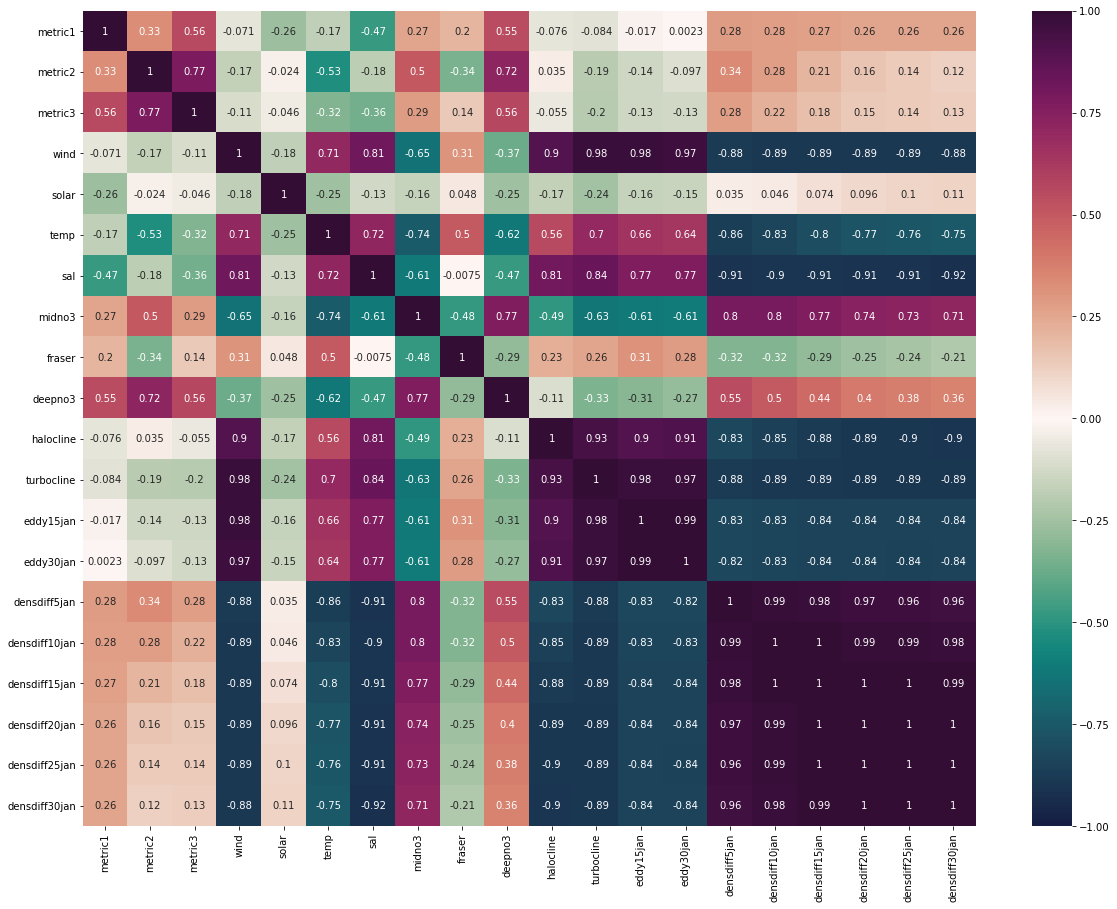

In [44]:
plt.subplots(figsize=(20,15))
cm1=cmocean.cm.curl
sns.heatmap(dfjan.corr(), annot = True,cmap=cm1,vmin=-1,vmax=1)

### Correlation matrix for February Values

<AxesSubplot:>

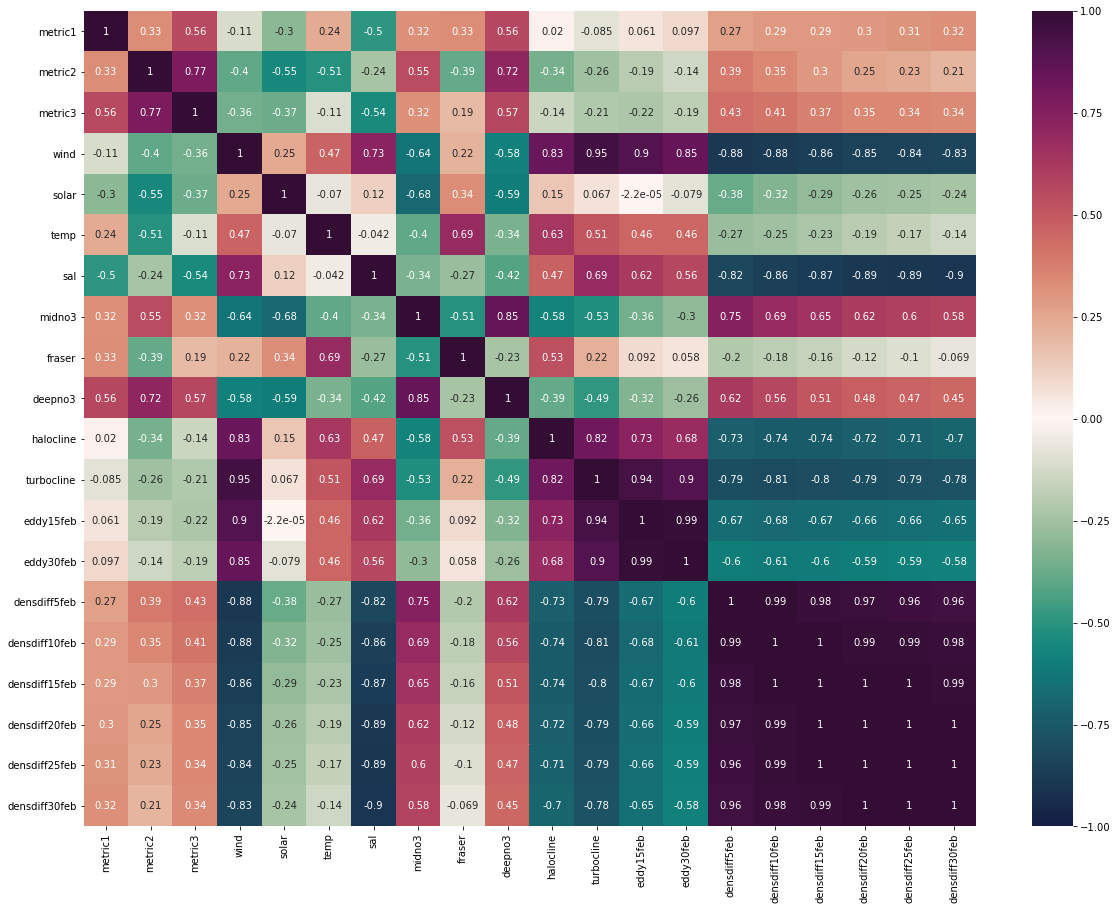

In [45]:
plt.subplots(figsize=(20,15))
cm1=cmocean.cm.curl
sns.heatmap(dffeb.corr(), annot = True,cmap=cm1,vmin=-1,vmax=1)

### Correlation matrix for March Values

<AxesSubplot:>

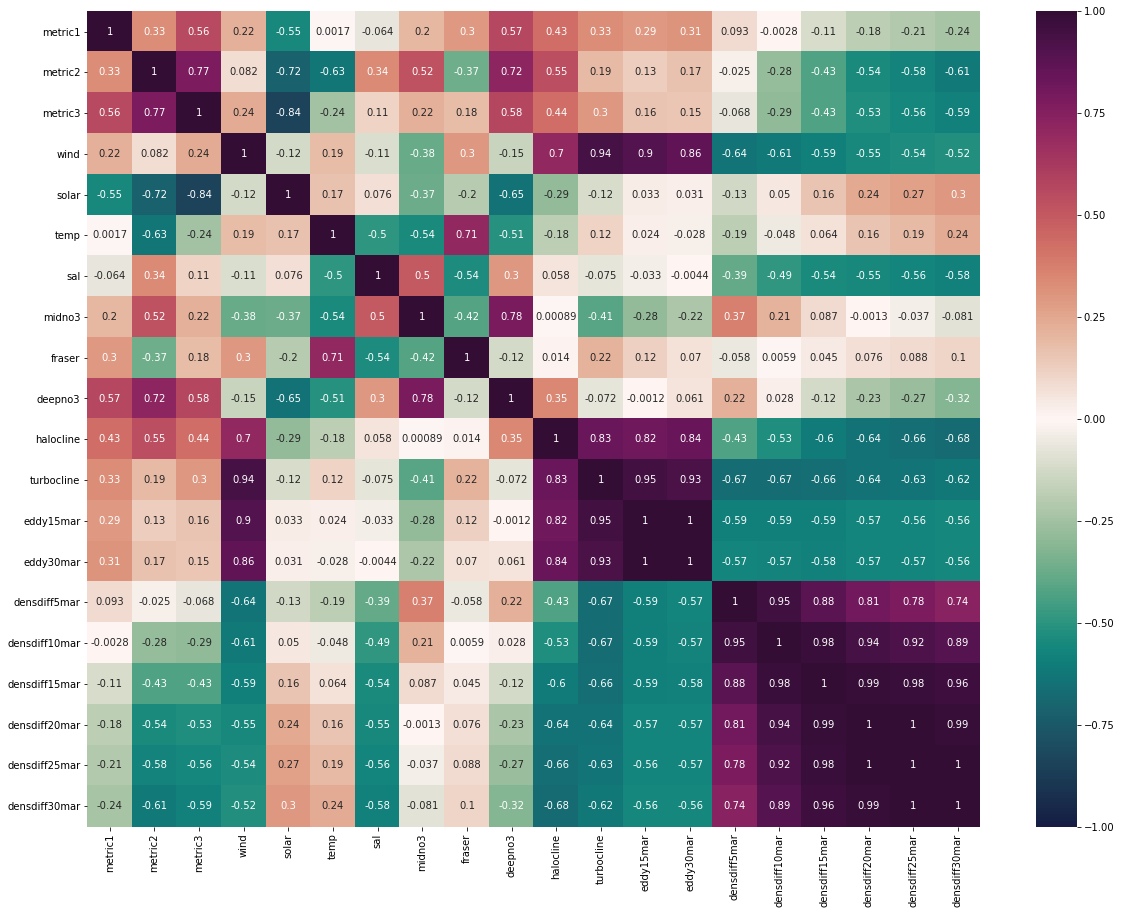

In [46]:
plt.subplots(figsize=(20,15))
cm1=cmocean.cm.curl
sns.heatmap(dfmar.corr(), annot = True,cmap=cm1,vmin=-1,vmax=1)

### Correlation plots of wind residuals

In [47]:
# Wind residual calculations for each metric
windresid1=list()
y,r2,m,b=bloomdrivers.reg_r2(windmar,yearday1)
for ind,y in enumerate(yearday1):
    x=windmar[ind]
    windresid1.append(y-(m*x+b))

windresid2=list()
y,r2,m,b=bloomdrivers.reg_r2(windmar,yearday2)
for ind,y in enumerate(yearday2):
    x=windmar[ind]
    windresid2.append(y-(m*x+b))
    
windresid3=list()
y,r2,m,b=bloomdrivers.reg_r2(windmar,yearday3)
for ind,y in enumerate(yearday3):
    x=windmar[ind]
    windresid3.append(y-(m*x+b))

In [48]:
dfwind=pd.DataFrame({'wind':windmar,'windresid1':windresid1,'windresid2':windresid2,'windresid3':windresid3,'solar':solarmar,
                  'temp':tempmar,'sal':salmar,'midno3':midno3mar,'fraser':frasermar,'deepno3':deepno3mar,'halocline':halomar})

<AxesSubplot:>

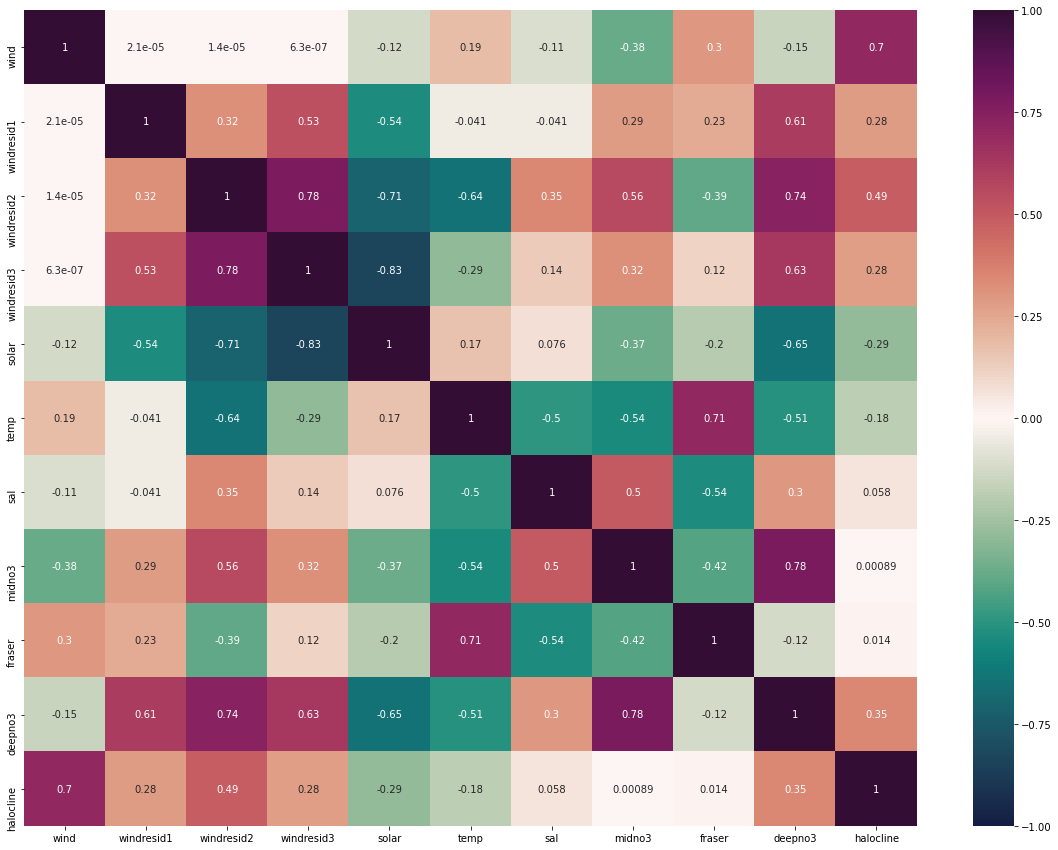

In [49]:
plt.subplots(figsize=(20,15))
cm1=cmocean.cm.curl
sns.heatmap(dfwind.corr(), annot = True,cmap=cm1,vmin=-1,vmax=1)

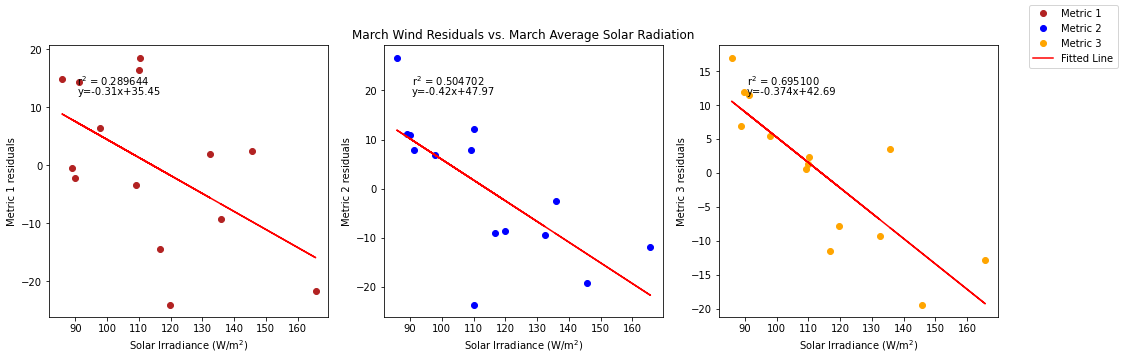

In [50]:
# ---------- Solar ---------
fig4,ax4=plt.subplots(1,3,figsize=(17,5))
ax4[0].plot(solarmar,windresid1,'o',color='firebrick',label='Metric 1')
ax4[0].set_xlabel('Solar Irradiance (W/$\mathregular{m^2}$)')
ax4[0].set_ylabel('Metric 1 residuals')
y,r2,m,b=bloomdrivers.reg_r2(solarmar,windresid1)
ax4[0].plot(solarmar, y, 'r')
ax4[0].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[0].transAxes)
ax4[0].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[0].transAxes)

ax4[1].plot(solarmar,windresid2,'o',color='b',label='Metric 2')
ax4[1].set_xlabel('Solar Irradiance (W/$\mathregular{m^2}$)')
ax4[1].set_ylabel('Metric 2 residuals')
ax4[1].set_title('March Wind Residuals vs. March Average Solar Radiation')
y,r2,m,b=bloomdrivers.reg_r2(solarmar,windresid2)
ax4[1].plot(solarmar, y, 'r')
ax4[1].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[1].transAxes)
ax4[1].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[1].transAxes)

ax4[2].plot(solarmar,windresid3,'o',color='orange',label='Metric 3')
ax4[2].set_xlabel('Solar Irradiance (W/$\mathregular{m^2}$)')
ax4[2].set_ylabel('Metric 3 residuals')
y,r2,m,b=bloomdrivers.reg_r2(solarmar,windresid3)
ax4[2].plot(solarmar, y, 'r', label='Fitted Line')
ax4[2].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[2].transAxes)
ax4[2].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[2].transAxes)
fig4.legend()

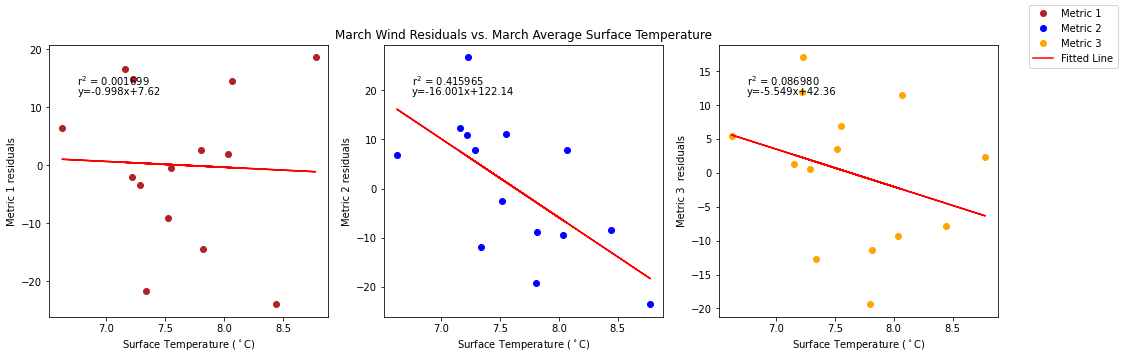

In [51]:
# ---------- Temperature ---------
fig4,ax4=plt.subplots(1,3,figsize=(17,5))
ax4[0].plot(tempmar,windresid1,'o',color='firebrick',label='Metric 1')
ax4[0].set_xlabel('Surface Temperature ($^\circ$C)')
ax4[0].set_ylabel('Metric 1 residuals')
y,r2,m,b=bloomdrivers.reg_r2(tempmar,windresid1)
ax4[0].plot(tempmar, y, 'r')
ax4[0].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[0].transAxes)
ax4[0].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[0].transAxes)

ax4[1].plot(tempmar,windresid2,'o',color='b',label='Metric 2')
ax4[1].set_xlabel('Surface Temperature ($^\circ$C)')
ax4[1].set_ylabel('Metric 2 residuals')
ax4[1].set_title('March Wind Residuals vs. March Average Surface Temperature')
y,r2,m,b=bloomdrivers.reg_r2(tempmar,windresid2)
ax4[1].plot(tempmar, y, 'r')
ax4[1].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[1].transAxes)
ax4[1].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[1].transAxes)

ax4[2].plot(tempmar,windresid3,'o',color='orange',label='Metric 3')
ax4[2].set_xlabel('Surface Temperature ($^\circ$C)')
ax4[2].set_ylabel('Metric 3  residuals')
y,r2,m,b=bloomdrivers.reg_r2(tempmar,windresid3)
ax4[2].plot(tempmar, y, 'r', label='Fitted Line')
ax4[2].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[2].transAxes)
ax4[2].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[2].transAxes)
fig4.legend()

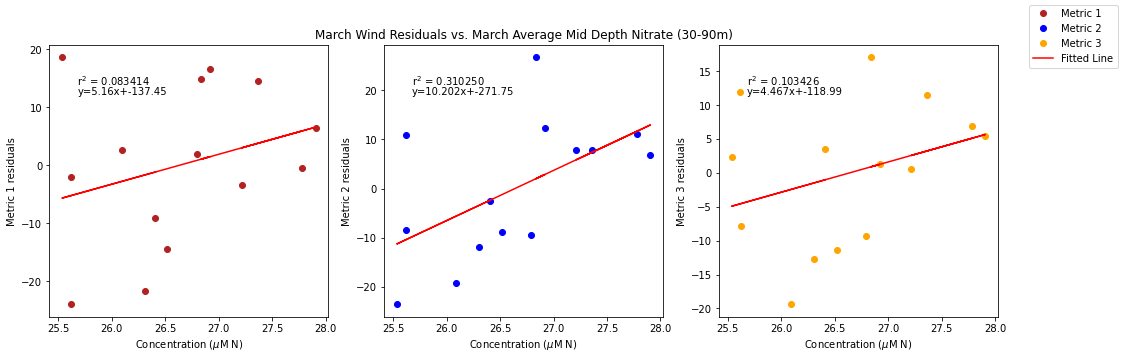

In [52]:
# ---------- Mid NO3 ---------
fig4,ax4=plt.subplots(1,3,figsize=(17,5))
ax4[0].plot(midno3mar,windresid1,'o',color='firebrick',label='Metric 1')
ax4[0].set_xlabel('Concentration ($\mu$M N)')
ax4[0].set_ylabel('Metric 1 residuals')
y,r2,m,b=bloomdrivers.reg_r2(midno3mar,windresid1)
ax4[0].plot(midno3mar, y, 'r')
ax4[0].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[0].transAxes)
ax4[0].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[0].transAxes)

ax4[1].plot(midno3mar,windresid2,'o',color='b',label='Metric 2')
ax4[1].set_xlabel('Concentration ($\mu$M N)')
ax4[1].set_ylabel('Metric 2 residuals')
ax4[1].set_title('March Wind Residuals vs. March Average Mid Depth Nitrate (30-90m)')
y,r2,m,b=bloomdrivers.reg_r2(midno3mar,windresid2)
ax4[1].plot(midno3mar, y, 'r')
ax4[1].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[1].transAxes)
ax4[1].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[1].transAxes)

ax4[2].plot(midno3mar,windresid3,'o',color='orange',label='Metric 3')
ax4[2].set_xlabel('Concentration ($\mu$M N)')
ax4[2].set_ylabel('Metric 3 residuals')
y,r2,m,b=bloomdrivers.reg_r2(midno3mar,windresid3)
ax4[2].plot(midno3mar, y, 'r', label='Fitted Line')
ax4[2].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[2].transAxes)
ax4[2].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[2].transAxes)
fig4.legend()

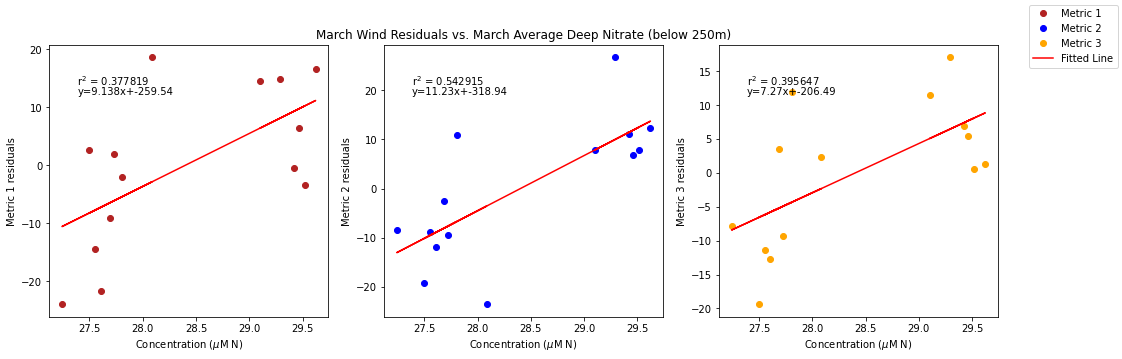

In [53]:
# ---------- Deep NO3 ---------
fig4,ax4=plt.subplots(1,3,figsize=(17,5))
ax4[0].plot(deepno3mar,windresid1,'o',color='firebrick',label='Metric 1')
ax4[0].set_xlabel('Concentration ($\mu$M N)')
ax4[0].set_ylabel('Metric 1 residuals')
y,r2,m,b=bloomdrivers.reg_r2(deepno3mar,windresid1)
ax4[0].plot(deepno3mar, y, 'r')
ax4[0].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[0].transAxes)
ax4[0].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[0].transAxes)

ax4[1].plot(deepno3mar,windresid2,'o',color='b',label='Metric 2')
ax4[1].set_xlabel('Concentration ($\mu$M N)')
ax4[1].set_ylabel('Metric 2 residuals')
ax4[1].set_title('March Wind Residuals vs. March Average Deep Nitrate (below 250m)')
y,r2,m,b=bloomdrivers.reg_r2(deepno3mar,windresid2)
ax4[1].plot(deepno3mar, y, 'r')
ax4[1].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[1].transAxes)
ax4[1].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[1].transAxes)

ax4[2].plot(deepno3mar,windresid3,'o',color='orange',label='Metric 3')
ax4[2].set_xlabel('Concentration ($\mu$M N)')
ax4[2].set_ylabel('Metric 3 residuals')
y,r2,m,b=bloomdrivers.reg_r2(deepno3mar,windresid3)
ax4[2].plot(deepno3mar, y, 'r', label='Fitted Line')
ax4[2].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[2].transAxes)
ax4[2].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[2].transAxes)
fig4.legend()

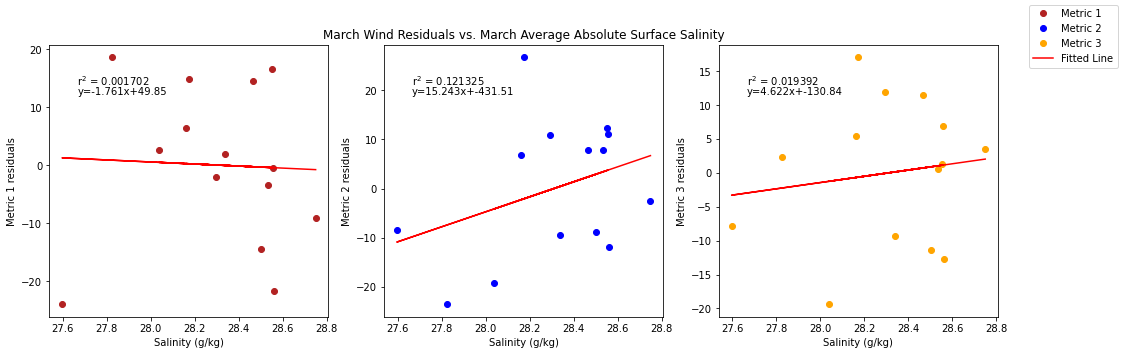

In [54]:
# ---------- Salinity ---------
fig4,ax4=plt.subplots(1,3,figsize=(17,5))
ax4[0].plot(salmar,windresid1,'o',color='firebrick',label='Metric 1')
ax4[0].set_xlabel('Salinity (g/kg)')
ax4[0].set_ylabel('Metric 1 residuals')
y,r2,m,b=bloomdrivers.reg_r2(salmar,windresid1)
ax4[0].plot(salmar, y, 'r')
ax4[0].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[0].transAxes)
ax4[0].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[0].transAxes)

ax4[1].plot(salmar,windresid2,'o',color='b',label='Metric 2')
ax4[1].set_xlabel('Salinity (g/kg)')
ax4[1].set_ylabel('Metric 2 residuals')
ax4[1].set_title('March Wind Residuals vs. March Average Absolute Surface Salinity')
y,r2,m,b=bloomdrivers.reg_r2(salmar,windresid2)
ax4[1].plot(salmar, y, 'r')
ax4[1].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[1].transAxes)
ax4[1].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[1].transAxes)

ax4[2].plot(salmar,windresid3,'o',color='orange',label='Metric 3')
ax4[2].set_xlabel('Salinity (g/kg)')
ax4[2].set_ylabel('Metric 3 residuals')
y,r2,m,b=bloomdrivers.reg_r2(salmar,windresid3)
ax4[2].plot(salmar, y, 'r', label='Fitted Line')
ax4[2].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[2].transAxes)
ax4[2].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[2].transAxes)
fig4.legend()

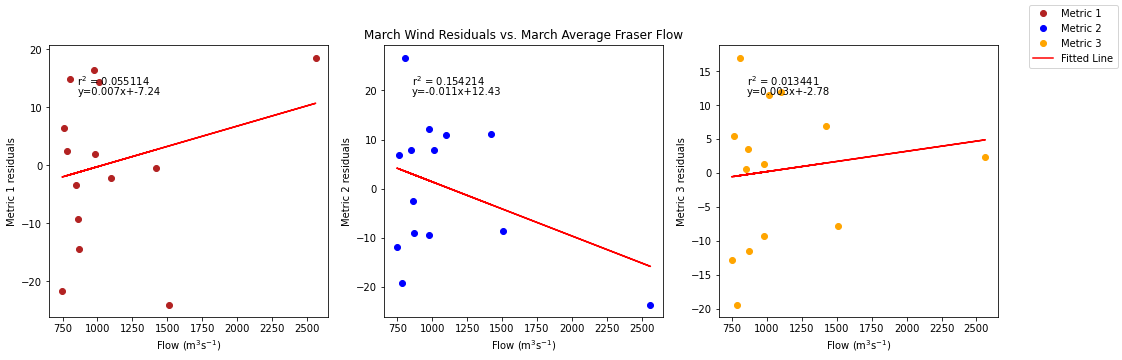

In [55]:
# ---------- Fraser ---------
fig4,ax4=plt.subplots(1,3,figsize=(17,5))
ax4[0].plot(frasermar,windresid1,'o',color='firebrick',label='Metric 1')
ax4[0].set_xlabel('Flow (m$^3$s$^{-1}$)')
ax4[0].set_ylabel('Metric 1 residuals')
y,r2,m,b=bloomdrivers.reg_r2(frasermar,windresid1)
ax4[0].plot(frasermar, y, 'r')
ax4[0].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[0].transAxes)
ax4[0].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[0].transAxes)

ax4[1].plot(frasermar,windresid2,'o',color='b',label='Metric 2')
ax4[1].set_xlabel('Flow (m$^3$s$^{-1}$)')
ax4[1].set_ylabel('Metric 2 residuals')
ax4[1].set_title('March Wind Residuals vs. March Average Fraser Flow')
y,r2,m,b=bloomdrivers.reg_r2(frasermar,windresid2)
ax4[1].plot(frasermar, y, 'r')
ax4[1].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[1].transAxes)
ax4[1].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[1].transAxes)

ax4[2].plot(frasermar,windresid3,'o',color='orange',label='Metric 3')
ax4[2].set_xlabel('Flow (m$^3$s$^{-1}$)')
ax4[2].set_ylabel('Metric 3 residuals')
y,r2,m,b=bloomdrivers.reg_r2(frasermar,windresid3)
ax4[2].plot(frasermar, y, 'r', label='Fitted Line')
ax4[2].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[2].transAxes)
ax4[2].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[2].transAxes)
fig4.legend()

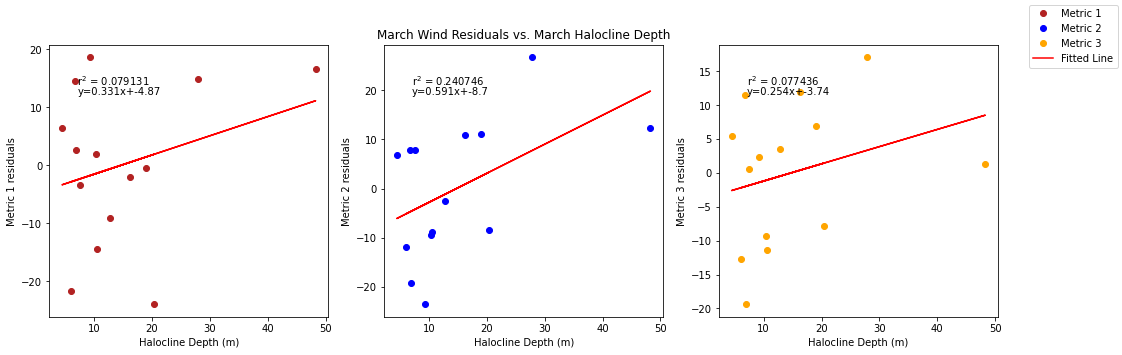

In [56]:
# ---------- Halocline ---------
fig4,ax4=plt.subplots(1,3,figsize=(17,5))
ax4[0].plot(halomar,windresid1,'o',color='firebrick',label='Metric 1')
ax4[0].set_xlabel('Halocline Depth (m)')
ax4[0].set_ylabel('Metric 1 residuals')
y,r2,m,b=bloomdrivers.reg_r2(halomar,windresid1)
ax4[0].plot(halomar, y, 'r')
ax4[0].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[0].transAxes)
ax4[0].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[0].transAxes)

ax4[1].plot(halomar,windresid2,'o',color='b',label='Metric 2')
ax4[1].set_xlabel('Halocline Depth (m)')
ax4[1].set_ylabel('Metric 2 residuals')
ax4[1].set_title('March Wind Residuals vs. March Halocline Depth')
y,r2,m,b=bloomdrivers.reg_r2(halomar,windresid2)
ax4[1].plot(halomar, y, 'r')
ax4[1].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[1].transAxes)
ax4[1].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[1].transAxes)

ax4[2].plot(halomar,windresid3,'o',color='orange',label='Metric 3')
ax4[2].set_xlabel('Halocline Depth (m)')
ax4[2].set_ylabel('Metric 3 residuals')
y,r2,m,b=bloomdrivers.reg_r2(halomar,windresid3)
ax4[2].plot(halomar, y, 'r', label='Fitted Line')
ax4[2].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[2].transAxes)
ax4[2].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[2].transAxes)
fig4.legend()

### Correlation plots of solar residuals

In [57]:
#  residual calculations for each metric
solarresid1=list()
y,r2,m,b=bloomdrivers.reg_r2(solarmar,yearday1)
for ind,y in enumerate(yearday1):
    x=solarmar[ind]
    solarresid1.append(y-(m*x+b))

solarresid2=list()
y,r2,m,b=bloomdrivers.reg_r2(solarmar,yearday2)
for ind,y in enumerate(yearday2):
    x=solarmar[ind]
    solarresid2.append(y-(m*x+b))
    
solarresid3=list()
y,r2,m,b=bloomdrivers.reg_r2(solarmar,yearday3)
for ind,y in enumerate(yearday3):
    x=solarmar[ind]
    solarresid3.append(y-(m*x+b))

In [58]:
dfsolar=pd.DataFrame({'solar':solarmar,'solarresid1':solarresid1,'solarresid2':solarresid2,'solarresid3':solarresid3,'wind':windmar,
                  'temp':tempmar,'sal':salmar,'midno3':midno3mar,'fraser':frasermar,'deepno3':deepno3mar,'halocine':halomar})

<AxesSubplot:>

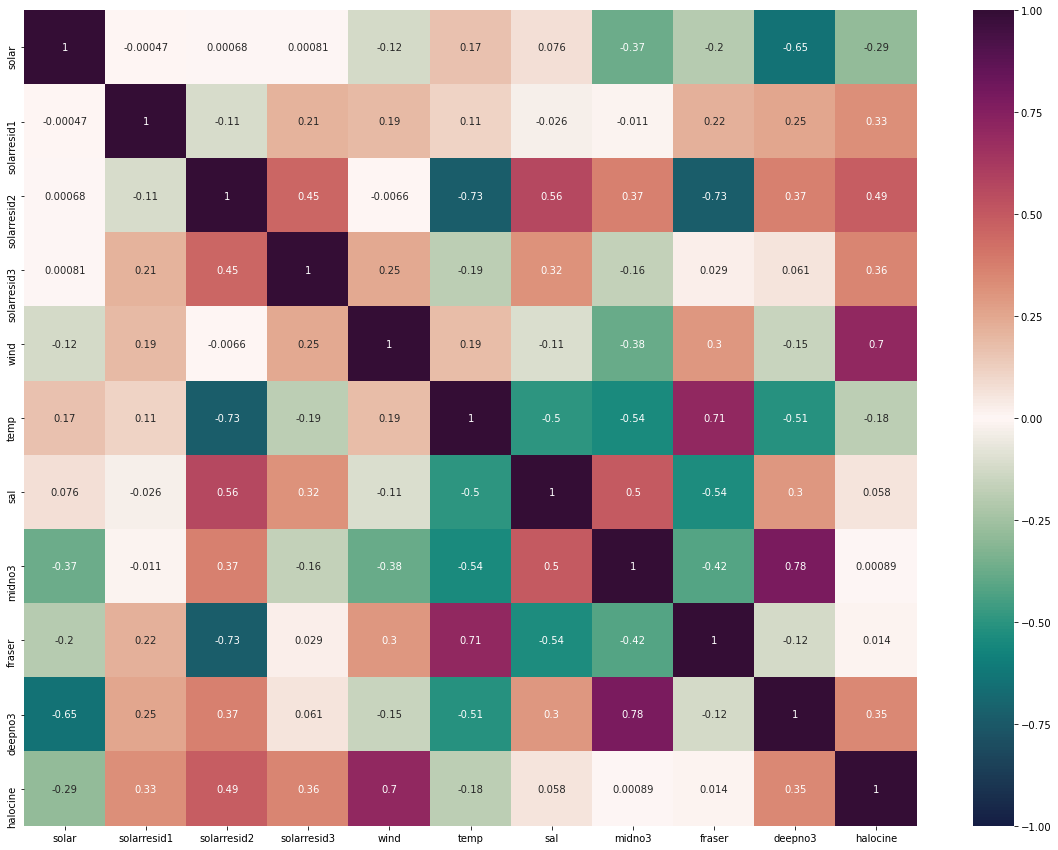

In [59]:
plt.subplots(figsize=(20,15))
cm1=cmocean.cm.curl
sns.heatmap(dfsolar.corr(), annot = True,cmap=cm1,vmin=-1,vmax=1)

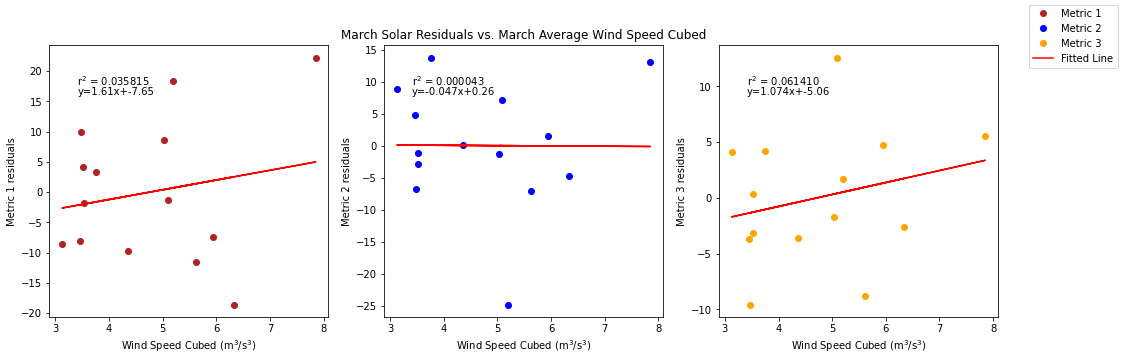

In [60]:
# ---------- wind ---------
fig4,ax4=plt.subplots(1,3,figsize=(17,5))
ax4[0].plot(windmar,solarresid1,'o',color='firebrick',label='Metric 1')
ax4[0].set_xlabel('Wind Speed Cubed ($\mathregular{m^3}$/$\mathregular{s^3}$)')
ax4[0].set_ylabel('Metric 1 residuals')
y,r2,m,b=bloomdrivers.reg_r2(windmar,solarresid1)
ax4[0].plot(windmar, y, 'r')
ax4[0].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[0].transAxes)
ax4[0].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[0].transAxes)

ax4[1].plot(windmar,solarresid2,'o',color='b',label='Metric 2')
ax4[1].set_xlabel('Wind Speed Cubed ($\mathregular{m^3}$/$\mathregular{s^3}$)')
ax4[1].set_ylabel('Metric 2 residuals')
ax4[1].set_title('March Solar Residuals vs. March Average Wind Speed Cubed')
y,r2,m,b=bloomdrivers.reg_r2(windmar,solarresid2)
ax4[1].plot(windmar, y, 'r')
ax4[1].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[1].transAxes)
ax4[1].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[1].transAxes)

ax4[2].plot(windmar,solarresid3,'o',color='orange',label='Metric 3')
ax4[2].set_xlabel('Wind Speed Cubed ($\mathregular{m^3}$/$\mathregular{s^3}$)')
ax4[2].set_ylabel('Metric 3 residuals')
y,r2,m,b=bloomdrivers.reg_r2(windmar,solarresid3)
ax4[2].plot(windmar, y, 'r', label='Fitted Line')
ax4[2].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[2].transAxes)
ax4[2].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[2].transAxes)
fig4.legend()

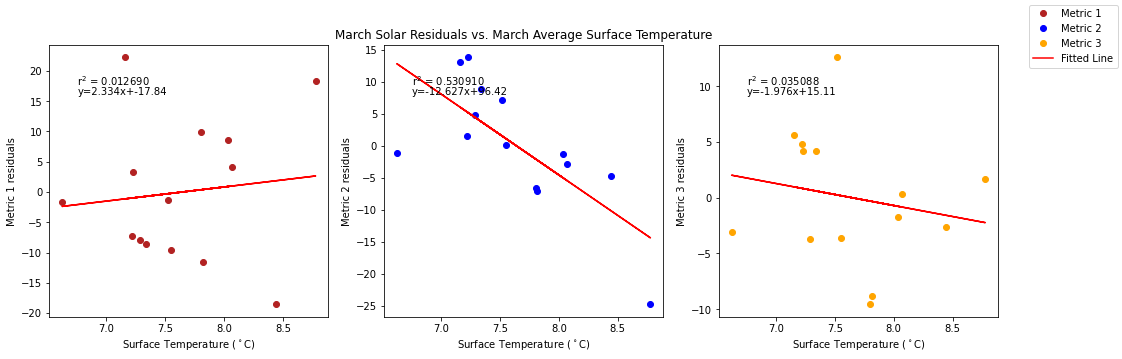

In [61]:
# ---------- Temperature ---------
fig4,ax4=plt.subplots(1,3,figsize=(17,5))
ax4[0].plot(tempmar,solarresid1,'o',color='firebrick',label='Metric 1')
ax4[0].set_xlabel('Surface Temperature ($^\circ$C)')
ax4[0].set_ylabel('Metric 1 residuals')
y,r2,m,b=bloomdrivers.reg_r2(tempmar,solarresid1)
ax4[0].plot(tempmar, y, 'r')
ax4[0].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[0].transAxes)
ax4[0].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[0].transAxes)

ax4[1].plot(tempmar,solarresid2,'o',color='b',label='Metric 2')
ax4[1].set_xlabel('Surface Temperature ($^\circ$C)')
ax4[1].set_ylabel('Metric 2 residuals')
ax4[1].set_title('March Solar Residuals vs. March Average Surface Temperature')
y,r2,m,b=bloomdrivers.reg_r2(tempmar,solarresid2)
ax4[1].plot(tempmar, y, 'r')
ax4[1].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[1].transAxes)
ax4[1].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[1].transAxes)

ax4[2].plot(tempmar,solarresid3,'o',color='orange',label='Metric 3')
ax4[2].set_xlabel('Surface Temperature ($^\circ$C)')
ax4[2].set_ylabel('Metric 3 residuals')
y,r2,m,b=bloomdrivers.reg_r2(tempmar,solarresid3)
ax4[2].plot(tempmar, y, 'r', label='Fitted Line')
ax4[2].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[2].transAxes)
ax4[2].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[2].transAxes)
fig4.legend()

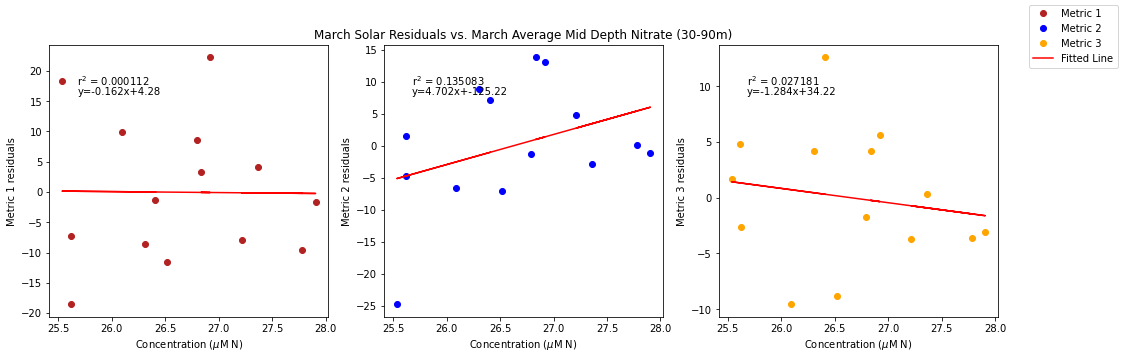

In [62]:
# ---------- Mid NO3 ---------
fig4,ax4=plt.subplots(1,3,figsize=(17,5))
ax4[0].plot(midno3mar,solarresid1,'o',color='firebrick',label='Metric 1')
ax4[0].set_xlabel('Concentration ($\mu$M N)')
ax4[0].set_ylabel('Metric 1 residuals')
y,r2,m,b=bloomdrivers.reg_r2(midno3mar,solarresid1)
ax4[0].plot(midno3mar, y, 'r')
ax4[0].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[0].transAxes)
ax4[0].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[0].transAxes)

ax4[1].plot(midno3mar,solarresid2,'o',color='b',label='Metric 2')
ax4[1].set_xlabel('Concentration ($\mu$M N)')
ax4[1].set_ylabel('Metric 2 residuals')
ax4[1].set_title('March Solar Residuals vs. March Average Mid Depth Nitrate (30-90m)')
y,r2,m,b=bloomdrivers.reg_r2(midno3mar,solarresid2)
ax4[1].plot(midno3mar, y, 'r')
ax4[1].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[1].transAxes)
ax4[1].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[1].transAxes)

ax4[2].plot(midno3mar,solarresid3,'o',color='orange',label='Metric 3')
ax4[2].set_xlabel('Concentration ($\mu$M N)')
ax4[2].set_ylabel('Metric 3 residuals')
y,r2,m,b=bloomdrivers.reg_r2(midno3mar,solarresid3)
ax4[2].plot(midno3mar, y, 'r', label='Fitted Line')
ax4[2].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[2].transAxes)
ax4[2].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[2].transAxes)
fig4.legend()

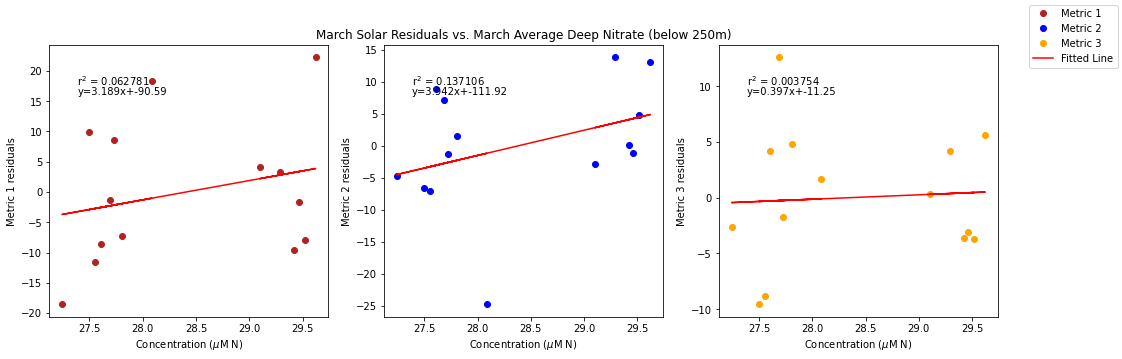

In [63]:
# ---------- Deep NO3 ---------
fig4,ax4=plt.subplots(1,3,figsize=(17,5))
ax4[0].plot(deepno3mar,solarresid1,'o',color='firebrick',label='Metric 1')
ax4[0].set_xlabel('Concentration ($\mu$M N)')
ax4[0].set_ylabel('Metric 1 residuals')
y,r2,m,b=bloomdrivers.reg_r2(deepno3mar,solarresid1)
ax4[0].plot(deepno3mar, y, 'r')
ax4[0].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[0].transAxes)
ax4[0].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[0].transAxes)

ax4[1].plot(deepno3mar,solarresid2,'o',color='b',label='Metric 2')
ax4[1].set_xlabel('Concentration ($\mu$M N)')
ax4[1].set_ylabel('Metric 2 residuals')
ax4[1].set_title('March Solar Residuals vs. March Average Deep Nitrate (below 250m)')
y,r2,m,b=bloomdrivers.reg_r2(deepno3mar,solarresid2)
ax4[1].plot(deepno3mar, y, 'r')
ax4[1].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[1].transAxes)
ax4[1].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[1].transAxes)

ax4[2].plot(deepno3mar,solarresid3,'o',color='orange',label='Metric 3')
ax4[2].set_xlabel('Concentration ($\mu$M N)')
ax4[2].set_ylabel('Metric 3 residuals')
y,r2,m,b=bloomdrivers.reg_r2(deepno3mar,solarresid3)
ax4[2].plot(deepno3mar, y, 'r', label='Fitted Line')
ax4[2].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[2].transAxes)
ax4[2].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[2].transAxes)
fig4.legend()

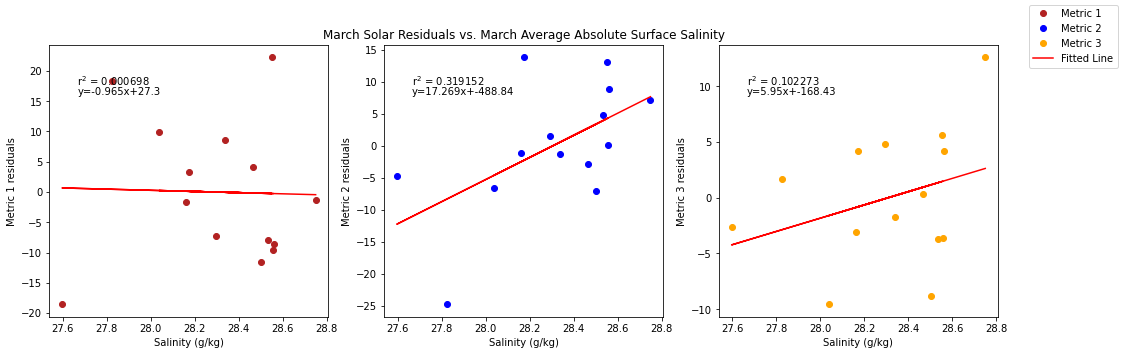

In [64]:
# ---------- Salinity ---------
fig4,ax4=plt.subplots(1,3,figsize=(17,5))
ax4[0].plot(salmar,solarresid1,'o',color='firebrick',label='Metric 1')
ax4[0].set_xlabel('Salinity (g/kg)')
ax4[0].set_ylabel('Metric 1 residuals')
y,r2,m,b=bloomdrivers.reg_r2(salmar,solarresid1)
ax4[0].plot(salmar, y, 'r')
ax4[0].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[0].transAxes)
ax4[0].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[0].transAxes)

ax4[1].plot(salmar,solarresid2,'o',color='b',label='Metric 2')
ax4[1].set_xlabel('Salinity (g/kg)')
ax4[1].set_ylabel('Metric 2 residuals')
ax4[1].set_title('March Solar Residuals vs. March Average Absolute Surface Salinity')
y,r2,m,b=bloomdrivers.reg_r2(salmar,solarresid2)
ax4[1].plot(salmar, y, 'r')
ax4[1].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[1].transAxes)
ax4[1].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[1].transAxes)

ax4[2].plot(salmar,solarresid3,'o',color='orange',label='Metric 3')
ax4[2].set_xlabel('Salinity (g/kg)')
ax4[2].set_ylabel('Metric 3 residuals')
y,r2,m,b=bloomdrivers.reg_r2(salmar,solarresid3)
ax4[2].plot(salmar, y, 'r', label='Fitted Line')
ax4[2].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[2].transAxes)
ax4[2].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[2].transAxes)
fig4.legend()

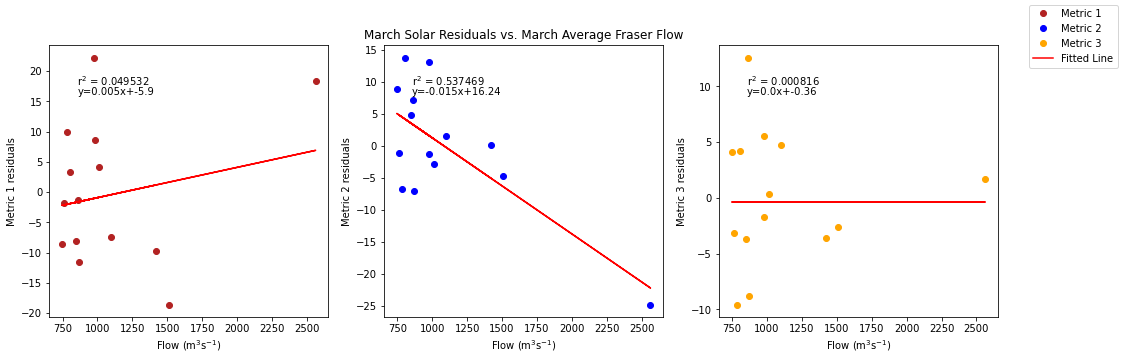

In [65]:
# ---------- Fraser ---------
fig4,ax4=plt.subplots(1,3,figsize=(17,5))
ax4[0].plot(frasermar,solarresid1,'o',color='firebrick',label='Metric 1')
ax4[0].set_xlabel('Flow (m$^3$s$^{-1}$)')
ax4[0].set_ylabel('Metric 1 residuals')
y,r2,m,b=bloomdrivers.reg_r2(frasermar,solarresid1)
ax4[0].plot(frasermar, y, 'r')
ax4[0].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[0].transAxes)
ax4[0].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[0].transAxes)

ax4[1].plot(frasermar,solarresid2,'o',color='b',label='Metric 2')
ax4[1].set_xlabel('Flow (m$^3$s$^{-1}$)')
ax4[1].set_ylabel('Metric 2 residuals')
ax4[1].set_title('March Solar Residuals vs. March Average Fraser Flow')
y,r2,m,b=bloomdrivers.reg_r2(frasermar,solarresid2)
ax4[1].plot(frasermar, y, 'r')
ax4[1].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[1].transAxes)
ax4[1].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[1].transAxes)

ax4[2].plot(frasermar,solarresid3,'o',color='orange',label='Metric 3')
ax4[2].set_xlabel('Flow (m$^3$s$^{-1}$)')
ax4[2].set_ylabel('Metric 3 residuals')
y,r2,m,b=bloomdrivers.reg_r2(frasermar,solarresid3)
ax4[2].plot(frasermar, y, 'r', label='Fitted Line')
ax4[2].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[2].transAxes)
ax4[2].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[2].transAxes)
fig4.legend()

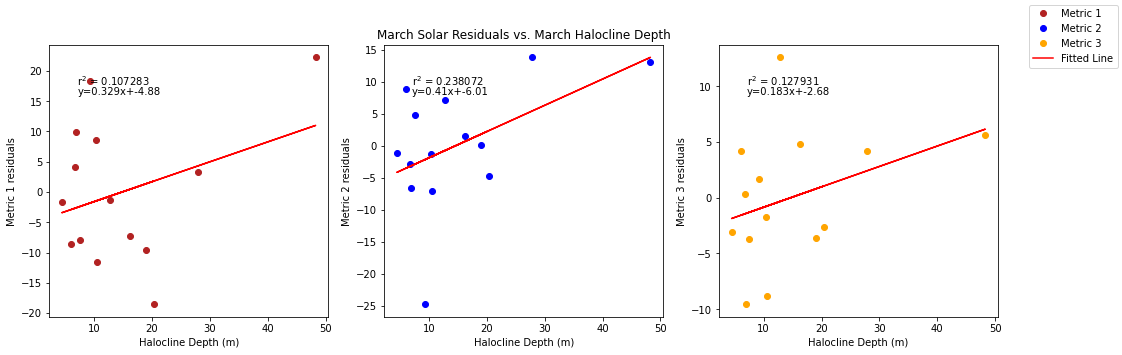

In [66]:
# ---------- Halocline ---------
fig4,ax4=plt.subplots(1,3,figsize=(17,5))
ax4[0].plot(halomar,solarresid1,'o',color='firebrick',label='Metric 1')
ax4[0].set_xlabel('Halocline Depth (m)')
ax4[0].set_ylabel('Metric 1 residuals')
y,r2,m,b=bloomdrivers.reg_r2(halomar,solarresid1)
ax4[0].plot(halomar, y, 'r')
ax4[0].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[0].transAxes)
ax4[0].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[0].transAxes)

ax4[1].plot(halomar,solarresid2,'o',color='b',label='Metric 2')
ax4[1].set_xlabel('Halocline Depth (m)')
ax4[1].set_ylabel('Metric 2 residuals')
ax4[1].set_title('March Solar Residuals vs. March Halocline Depth')
y,r2,m,b=bloomdrivers.reg_r2(halomar,solarresid2)
ax4[1].plot(halomar, y, 'r')
ax4[1].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[1].transAxes)
ax4[1].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[1].transAxes)

ax4[2].plot(halomar,solarresid3,'o',color='orange',label='Metric 3')
ax4[2].set_xlabel('Halocline Depth (m)')
ax4[2].set_ylabel('Metric 3 residuals')
y,r2,m,b=bloomdrivers.reg_r2(halomar,solarresid3)
ax4[2].plot(halomar, y, 'r', label='Fitted Line')
ax4[2].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[2].transAxes)
ax4[2].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[2].transAxes)
fig4.legend()

### Correlation plots of temperature residuals

In [67]:
#  residual calculations for each metric
tempresid1=list()
y,r2,m,b=bloomdrivers.reg_r2(tempmar,yearday1)
for ind,y in enumerate(yearday1):
    x=tempmar[ind]
    tempresid1.append(y-(m*x+b))

tempresid2=list()
y,r2,m,b=bloomdrivers.reg_r2(tempmar,yearday2)
for ind,y in enumerate(yearday2):
    x=tempmar[ind]
    tempresid2.append(y-(m*x+b))
    
tempresid3=list()
y,r2,m,b=bloomdrivers.reg_r2(tempmar,yearday3)
for ind,y in enumerate(yearday3):
    x=tempmar[ind]
    tempresid3.append(y-(m*x+b))

In [68]:
dftemp=pd.DataFrame({'temp':tempmar,'tempresid1':tempresid1,'tempresid2':tempresid2,'tempresid3':tempresid3,'wind':windmar,'solar':solarmar,
                  'sal':salmar,'midno3':midno3mar,'fraser':frasermar,'deepno3':deepno3mar,'halocine':halomar})

<AxesSubplot:>

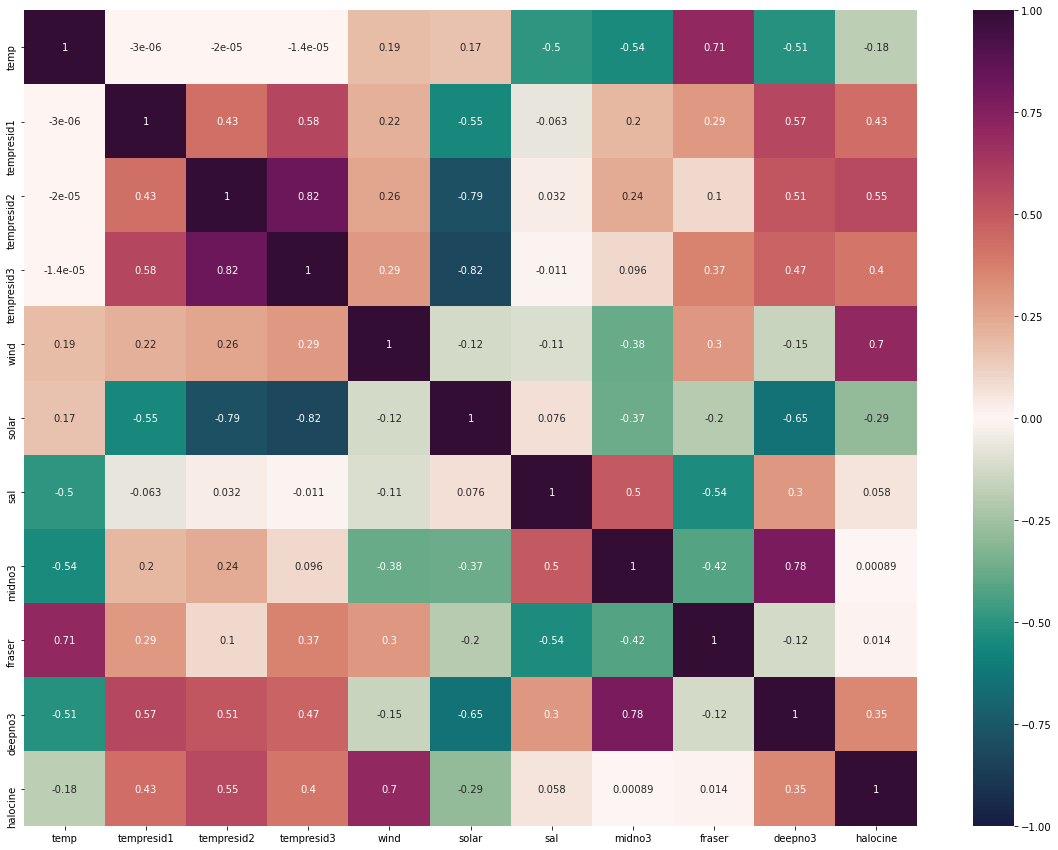

In [69]:
plt.subplots(figsize=(20,15))
cm1=cmocean.cm.curl
sns.heatmap(dftemp.corr(), annot = True,cmap=cm1,vmin=-1,vmax=1)

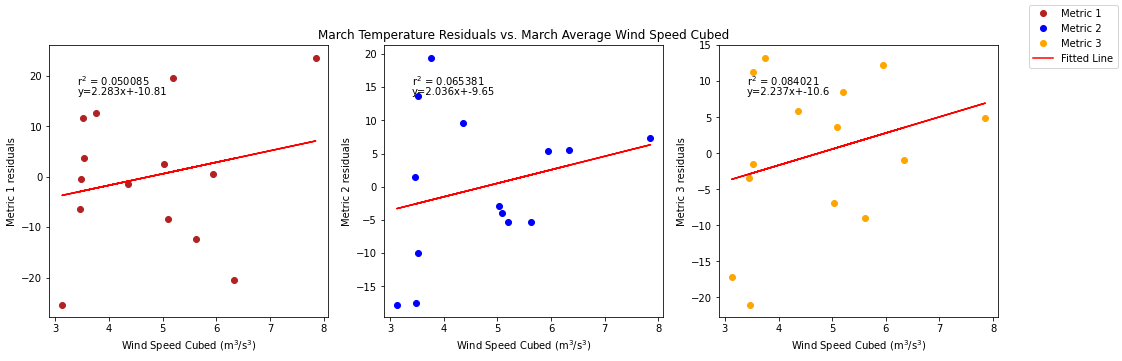

In [70]:
# ---------- wind ---------
fig4,ax4=plt.subplots(1,3,figsize=(17,5))
ax4[0].plot(windmar,tempresid1,'o',color='firebrick',label='Metric 1')
ax4[0].set_xlabel('Wind Speed Cubed ($\mathregular{m^3}$/$\mathregular{s^3}$)')
ax4[0].set_ylabel('Metric 1 residuals')
y,r2,m,b=bloomdrivers.reg_r2(windmar,tempresid1)
ax4[0].plot(windmar, y, 'r')
ax4[0].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[0].transAxes)
ax4[0].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[0].transAxes)

ax4[1].plot(windmar,tempresid2,'o',color='b',label='Metric 2')
ax4[1].set_xlabel('Wind Speed Cubed ($\mathregular{m^3}$/$\mathregular{s^3}$)')
ax4[1].set_ylabel('Metric 2 residuals')
ax4[1].set_title('March Temperature Residuals vs. March Average Wind Speed Cubed')
y,r2,m,b=bloomdrivers.reg_r2(windmar,tempresid2)
ax4[1].plot(windmar, y, 'r')
ax4[1].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[1].transAxes)
ax4[1].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[1].transAxes)

ax4[2].plot(windmar,tempresid3,'o',color='orange',label='Metric 3')
ax4[2].set_xlabel('Wind Speed Cubed ($\mathregular{m^3}$/$\mathregular{s^3}$)')
ax4[2].set_ylabel('Metric 3 residuals')
y,r2,m,b=bloomdrivers.reg_r2(windmar,tempresid3)
ax4[2].plot(windmar, y, 'r', label='Fitted Line')
ax4[2].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[2].transAxes)
ax4[2].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[2].transAxes)
fig4.legend()

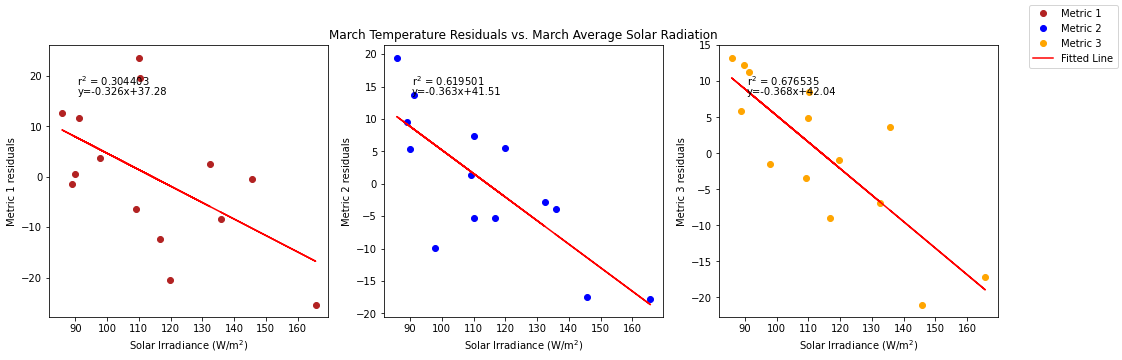

In [71]:
# ---------- Solar ---------
fig4,ax4=plt.subplots(1,3,figsize=(17,5))
ax4[0].plot(solarmar,tempresid1,'o',color='firebrick',label='Metric 1')
ax4[0].set_xlabel('Solar Irradiance (W/$\mathregular{m^2}$)')
ax4[0].set_ylabel('Metric 1 residuals')
y,r2,m,b=bloomdrivers.reg_r2(solarmar,tempresid1)
ax4[0].plot(solarmar, y, 'r')
ax4[0].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[0].transAxes)
ax4[0].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[0].transAxes)

ax4[1].plot(solarmar,tempresid2,'o',color='b',label='Metric 2')
ax4[1].set_xlabel('Solar Irradiance (W/$\mathregular{m^2}$)')
ax4[1].set_ylabel('Metric 2 residuals')
ax4[1].set_title('March Temperature Residuals vs. March Average Solar Radiation')
y,r2,m,b=bloomdrivers.reg_r2(solarmar,tempresid2)
ax4[1].plot(solarmar, y, 'r')
ax4[1].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[1].transAxes)
ax4[1].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[1].transAxes)

ax4[2].plot(solarmar,tempresid3,'o',color='orange',label='Metric 3')
ax4[2].set_xlabel('Solar Irradiance (W/$\mathregular{m^2}$)')
ax4[2].set_ylabel('Metric 3 residuals')
y,r2,m,b=bloomdrivers.reg_r2(solarmar,tempresid3)
ax4[2].plot(solarmar, y, 'r', label='Fitted Line')
ax4[2].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[2].transAxes)
ax4[2].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[2].transAxes)
fig4.legend()

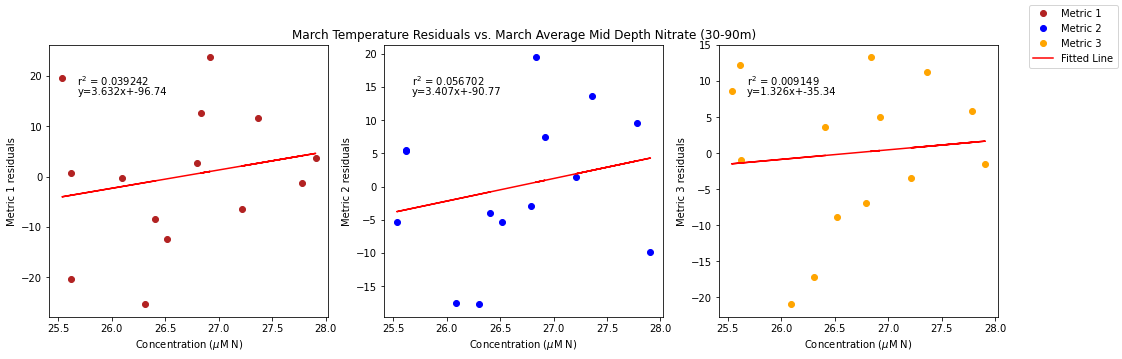

In [72]:
# ---------- Mid NO3 ---------
fig4,ax4=plt.subplots(1,3,figsize=(17,5))
ax4[0].plot(midno3mar,tempresid1,'o',color='firebrick',label='Metric 1')
ax4[0].set_xlabel('Concentration ($\mu$M N)')
ax4[0].set_ylabel('Metric 1 residuals')
y,r2,m,b=bloomdrivers.reg_r2(midno3mar,tempresid1)
ax4[0].plot(midno3mar, y, 'r')
ax4[0].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[0].transAxes)
ax4[0].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[0].transAxes)

ax4[1].plot(midno3mar,tempresid2,'o',color='b',label='Metric 2')
ax4[1].set_xlabel('Concentration ($\mu$M N)')
ax4[1].set_ylabel('Metric 2 residuals')
ax4[1].set_title('March Temperature Residuals vs. March Average Mid Depth Nitrate (30-90m)')
y,r2,m,b=bloomdrivers.reg_r2(midno3mar,tempresid2)
ax4[1].plot(midno3mar, y, 'r')
ax4[1].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[1].transAxes)
ax4[1].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[1].transAxes)

ax4[2].plot(midno3mar,tempresid3,'o',color='orange',label='Metric 3')
ax4[2].set_xlabel('Concentration ($\mu$M N)')
ax4[2].set_ylabel('Metric 3 residuals')
y,r2,m,b=bloomdrivers.reg_r2(midno3mar,tempresid3)
ax4[2].plot(midno3mar, y, 'r', label='Fitted Line')
ax4[2].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[2].transAxes)
ax4[2].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[2].transAxes)
fig4.legend()

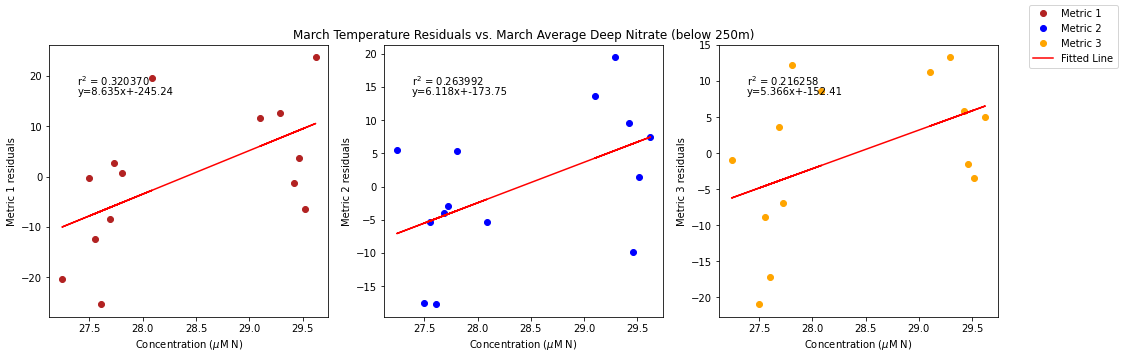

In [73]:
# ---------- Deep NO3 ---------
fig4,ax4=plt.subplots(1,3,figsize=(17,5))
ax4[0].plot(deepno3mar,tempresid1,'o',color='firebrick',label='Metric 1')
ax4[0].set_xlabel('Concentration ($\mu$M N)')
ax4[0].set_ylabel('Metric 1 residuals')
y,r2,m,b=bloomdrivers.reg_r2(deepno3mar,tempresid1)
ax4[0].plot(deepno3mar, y, 'r')
ax4[0].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[0].transAxes)
ax4[0].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[0].transAxes)

ax4[1].plot(deepno3mar,tempresid2,'o',color='b',label='Metric 2')
ax4[1].set_xlabel('Concentration ($\mu$M N)')
ax4[1].set_ylabel('Metric 2 residuals')
ax4[1].set_title('March Temperature Residuals vs. March Average Deep Nitrate (below 250m)')
y,r2,m,b=bloomdrivers.reg_r2(deepno3mar,tempresid2)
ax4[1].plot(deepno3mar, y, 'r')
ax4[1].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[1].transAxes)
ax4[1].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[1].transAxes)

ax4[2].plot(deepno3mar,tempresid3,'o',color='orange',label='Metric 3')
ax4[2].set_xlabel('Concentration ($\mu$M N)')
ax4[2].set_ylabel('Metric 3 residuals')
y,r2,m,b=bloomdrivers.reg_r2(deepno3mar,tempresid3)
ax4[2].plot(deepno3mar, y, 'r', label='Fitted Line')
ax4[2].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[2].transAxes)
ax4[2].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[2].transAxes)
fig4.legend()

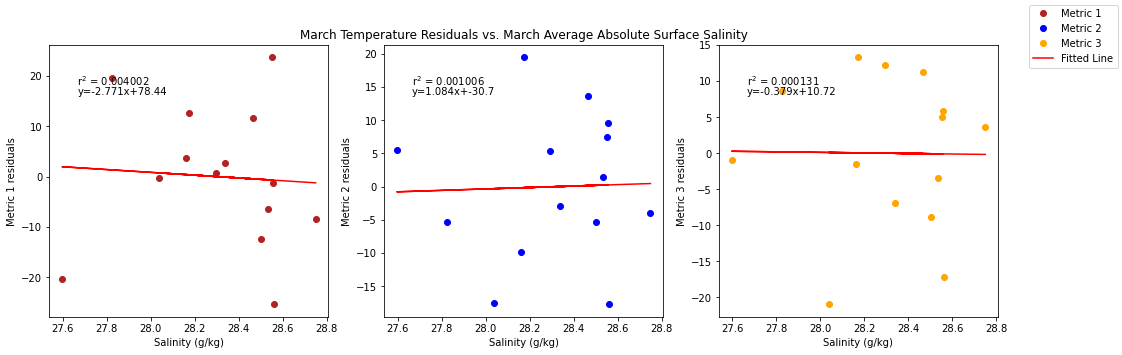

In [74]:
# ---------- Salinity ---------
fig4,ax4=plt.subplots(1,3,figsize=(17,5))
ax4[0].plot(salmar,tempresid1,'o',color='firebrick',label='Metric 1')
ax4[0].set_xlabel('Salinity (g/kg)')
ax4[0].set_ylabel('Metric 1 residuals')
y,r2,m,b=bloomdrivers.reg_r2(salmar,tempresid1)
ax4[0].plot(salmar, y, 'r')
ax4[0].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[0].transAxes)
ax4[0].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[0].transAxes)

ax4[1].plot(salmar,tempresid2,'o',color='b',label='Metric 2')
ax4[1].set_xlabel('Salinity (g/kg)')
ax4[1].set_ylabel('Metric 2 residuals')
ax4[1].set_title('March Temperature Residuals vs. March Average Absolute Surface Salinity')
y,r2,m,b=bloomdrivers.reg_r2(salmar,tempresid2)
ax4[1].plot(salmar, y, 'r')
ax4[1].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[1].transAxes)
ax4[1].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[1].transAxes)

ax4[2].plot(salmar,tempresid3,'o',color='orange',label='Metric 3')
ax4[2].set_xlabel('Salinity (g/kg)')
ax4[2].set_ylabel('Metric 3 residuals')
y,r2,m,b=bloomdrivers.reg_r2(salmar,tempresid3)
ax4[2].plot(salmar, y, 'r', label='Fitted Line')
ax4[2].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[2].transAxes)
ax4[2].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[2].transAxes)
fig4.legend()

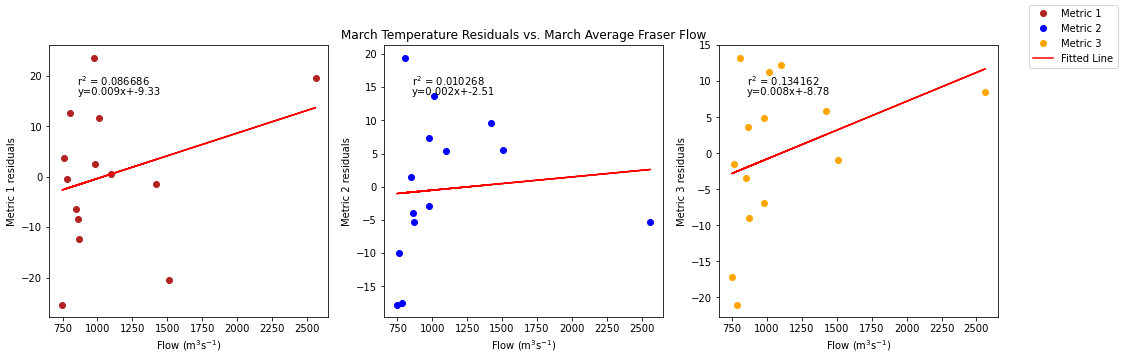

In [75]:
# ---------- Fraser ---------
fig4,ax4=plt.subplots(1,3,figsize=(17,5))
ax4[0].plot(frasermar,tempresid1,'o',color='firebrick',label='Metric 1')
ax4[0].set_xlabel('Flow (m$^3$s$^{-1}$)')
ax4[0].set_ylabel('Metric 1 residuals')
y,r2,m,b=bloomdrivers.reg_r2(frasermar,tempresid1)
ax4[0].plot(frasermar, y, 'r')
ax4[0].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[0].transAxes)
ax4[0].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[0].transAxes)

ax4[1].plot(frasermar,tempresid2,'o',color='b',label='Metric 2')
ax4[1].set_xlabel('Flow (m$^3$s$^{-1}$)')
ax4[1].set_ylabel('Metric 2 residuals')
ax4[1].set_title('March Temperature Residuals vs. March Average Fraser Flow')
y,r2,m,b=bloomdrivers.reg_r2(frasermar,tempresid2)
ax4[1].plot(frasermar, y, 'r')
ax4[1].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[1].transAxes)
ax4[1].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[1].transAxes)

ax4[2].plot(frasermar,tempresid3,'o',color='orange',label='Metric 3')
ax4[2].set_xlabel('Flow (m$^3$s$^{-1}$)')
ax4[2].set_ylabel('Metric 3 residuals')
y,r2,m,b=bloomdrivers.reg_r2(frasermar,tempresid3)
ax4[2].plot(frasermar, y, 'r', label='Fitted Line')
ax4[2].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[2].transAxes)
ax4[2].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[2].transAxes)
fig4.legend()

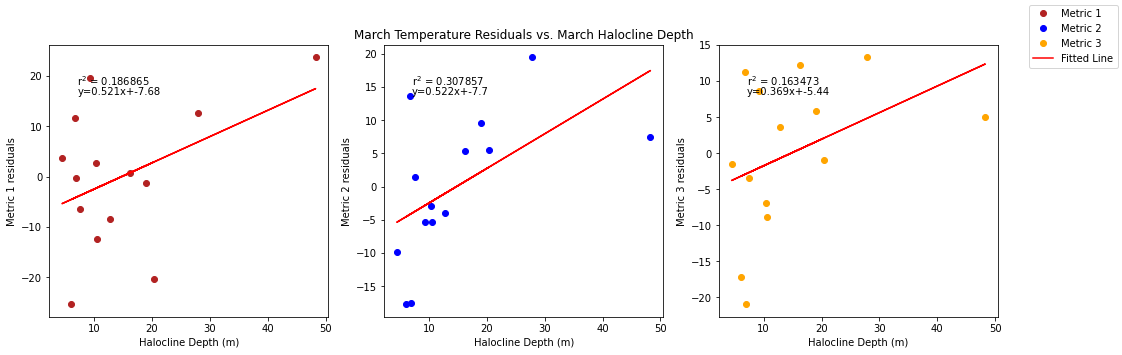

In [76]:
# ---------- Halocline ---------
fig4,ax4=plt.subplots(1,3,figsize=(17,5))
ax4[0].plot(halomar,tempresid1,'o',color='firebrick',label='Metric 1')
ax4[0].set_xlabel('Halocline Depth (m)')
ax4[0].set_ylabel('Metric 1 residuals')
y,r2,m,b=bloomdrivers.reg_r2(halomar,tempresid1)
ax4[0].plot(halomar, y, 'r')
ax4[0].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[0].transAxes)
ax4[0].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[0].transAxes)

ax4[1].plot(halomar,tempresid2,'o',color='b',label='Metric 2')
ax4[1].set_xlabel('Halocline Depth (m)')
ax4[1].set_ylabel('Metric 2 residuals')
ax4[1].set_title('March Temperature Residuals vs. March Halocline Depth')
y,r2,m,b=bloomdrivers.reg_r2(halomar,tempresid2)
ax4[1].plot(halomar, y, 'r')
ax4[1].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[1].transAxes)
ax4[1].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[1].transAxes)

ax4[2].plot(halomar,tempresid3,'o',color='orange',label='Metric 3')
ax4[2].set_xlabel('Halocline Depth (m)')
ax4[2].set_ylabel('Metric 3 residuals')
y,r2,m,b=bloomdrivers.reg_r2(halomar,tempresid3)
ax4[2].plot(halomar, y, 'r', label='Fitted Line')
ax4[2].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[2].transAxes)
ax4[2].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[2].transAxes)
fig4.legend()

### Correlation plots of mid NO3 residuals

In [77]:
#  residual calculations for each metric
midno3resid1=list()
y,r2,m,b=bloomdrivers.reg_r2(midno3mar,yearday1)
for ind,y in enumerate(yearday1):
    x=midno3mar[ind]
    midno3resid1.append(y-(m*x+b))

midno3resid2=list()
y,r2,m,b=bloomdrivers.reg_r2(midno3mar,yearday2)
for ind,y in enumerate(yearday2):
    x=midno3mar[ind]
    midno3resid2.append(y-(m*x+b))
    
midno3resid3=list()
y,r2,m,b=bloomdrivers.reg_r2(midno3mar,yearday3)
for ind,y in enumerate(yearday3):
    x=midno3mar[ind]
    midno3resid3.append(y-(m*x+b))

In [78]:
dfmidno3=pd.DataFrame({'midno3':midno3mar,'midno3resid1':midno3resid1,'midno3resid2':midno3resid2,'midno3resid3':midno3resid3,'wind':windmar,'solar':solarmar,
                       'temp':tempmar,'sal':salmar,'fraser':frasermar,'deepno3':deepno3mar,'halocine':halomar})

<AxesSubplot:>

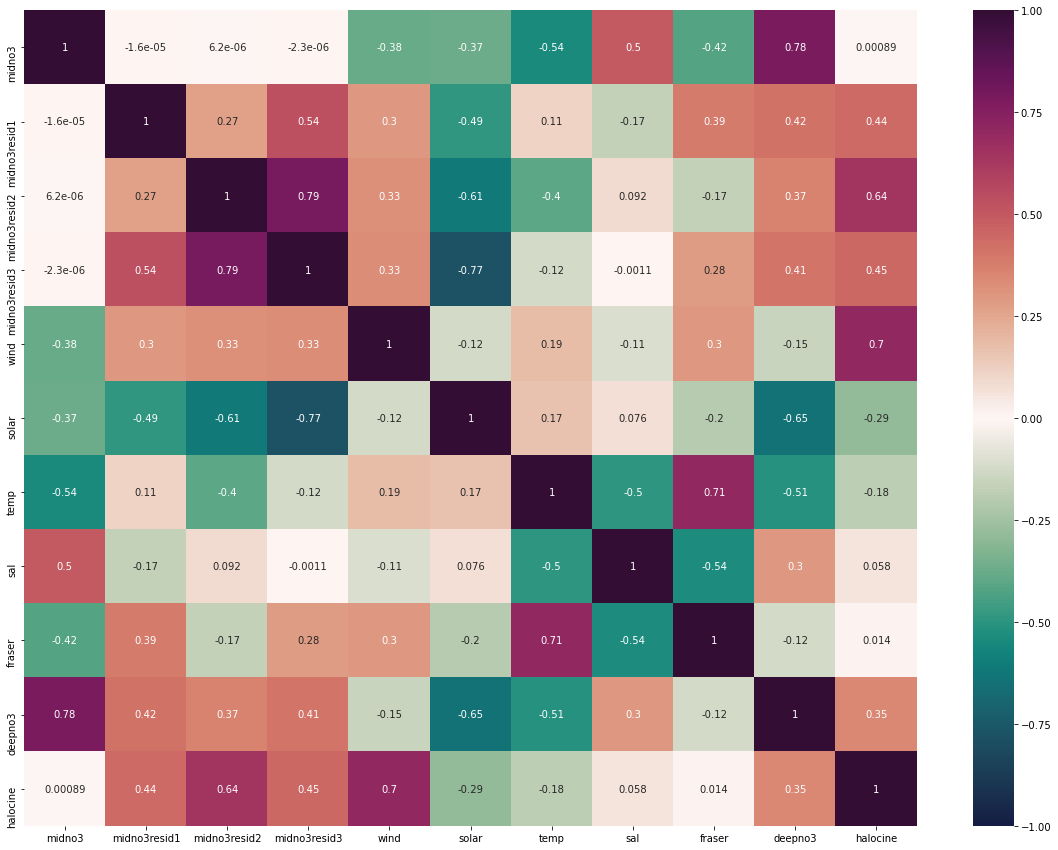

In [79]:
plt.subplots(figsize=(20,15))
cm1=cmocean.cm.curl
sns.heatmap(dfmidno3.corr(), annot = True,cmap=cm1,vmin=-1,vmax=1)

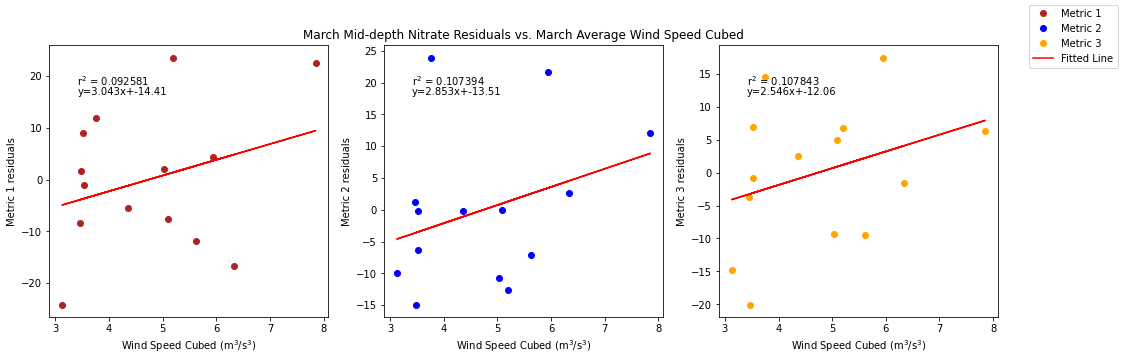

In [80]:
# ---------- wind ---------
fig4,ax4=plt.subplots(1,3,figsize=(17,5))
ax4[0].plot(windmar,midno3resid1,'o',color='firebrick',label='Metric 1')
ax4[0].set_xlabel('Wind Speed Cubed ($\mathregular{m^3}$/$\mathregular{s^3}$)')
ax4[0].set_ylabel('Metric 1 residuals')
y,r2,m,b=bloomdrivers.reg_r2(windmar,midno3resid1)
ax4[0].plot(windmar, y, 'r')
ax4[0].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[0].transAxes)
ax4[0].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[0].transAxes)

ax4[1].plot(windmar,midno3resid2,'o',color='b',label='Metric 2')
ax4[1].set_xlabel('Wind Speed Cubed ($\mathregular{m^3}$/$\mathregular{s^3}$)')
ax4[1].set_ylabel('Metric 2 residuals')
ax4[1].set_title('March Mid-depth Nitrate Residuals vs. March Average Wind Speed Cubed')
y,r2,m,b=bloomdrivers.reg_r2(windmar,midno3resid2)
ax4[1].plot(windmar, y, 'r')
ax4[1].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[1].transAxes)
ax4[1].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[1].transAxes)

ax4[2].plot(windmar,midno3resid3,'o',color='orange',label='Metric 3')
ax4[2].set_xlabel('Wind Speed Cubed ($\mathregular{m^3}$/$\mathregular{s^3}$)')
ax4[2].set_ylabel('Metric 3 residuals')
y,r2,m,b=bloomdrivers.reg_r2(windmar,midno3resid3)
ax4[2].plot(windmar, y, 'r', label='Fitted Line')
ax4[2].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[2].transAxes)
ax4[2].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[2].transAxes)
fig4.legend()

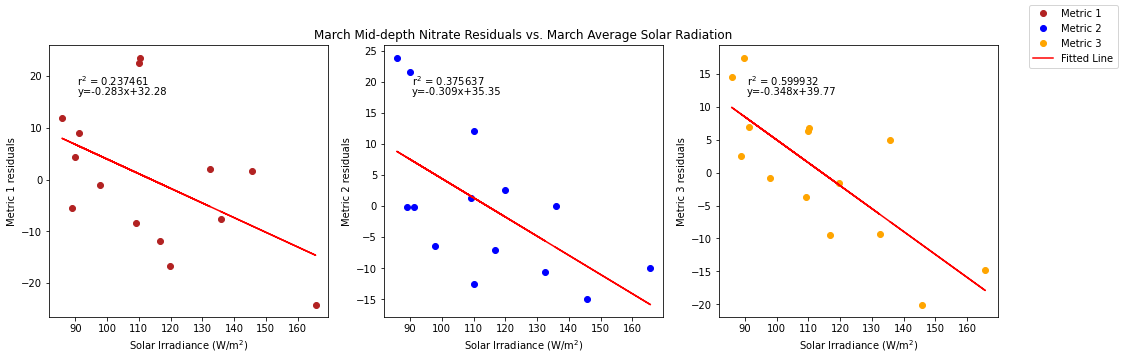

In [81]:
# ---------- Solar ---------
fig4,ax4=plt.subplots(1,3,figsize=(17,5))
ax4[0].plot(solarmar,midno3resid1,'o',color='firebrick',label='Metric 1')
ax4[0].set_xlabel('Solar Irradiance (W/$\mathregular{m^2}$)')
ax4[0].set_ylabel('Metric 1 residuals')
y,r2,m,b=bloomdrivers.reg_r2(solarmar,midno3resid1)
ax4[0].plot(solarmar, y, 'r')
ax4[0].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[0].transAxes)
ax4[0].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[0].transAxes)

ax4[1].plot(solarmar,midno3resid2,'o',color='b',label='Metric 2')
ax4[1].set_xlabel('Solar Irradiance (W/$\mathregular{m^2}$)')
ax4[1].set_ylabel('Metric 2 residuals')
ax4[1].set_title('March Mid-depth Nitrate Residuals vs. March Average Solar Radiation')
y,r2,m,b=bloomdrivers.reg_r2(solarmar,midno3resid2)
ax4[1].plot(solarmar, y, 'r')
ax4[1].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[1].transAxes)
ax4[1].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[1].transAxes)

ax4[2].plot(solarmar,midno3resid3,'o',color='orange',label='Metric 3')
ax4[2].set_xlabel('Solar Irradiance (W/$\mathregular{m^2}$)')
ax4[2].set_ylabel('Metric 3 residuals')
y,r2,m,b=bloomdrivers.reg_r2(solarmar,midno3resid3)
ax4[2].plot(solarmar, y, 'r', label='Fitted Line')
ax4[2].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[2].transAxes)
ax4[2].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[2].transAxes)
fig4.legend()

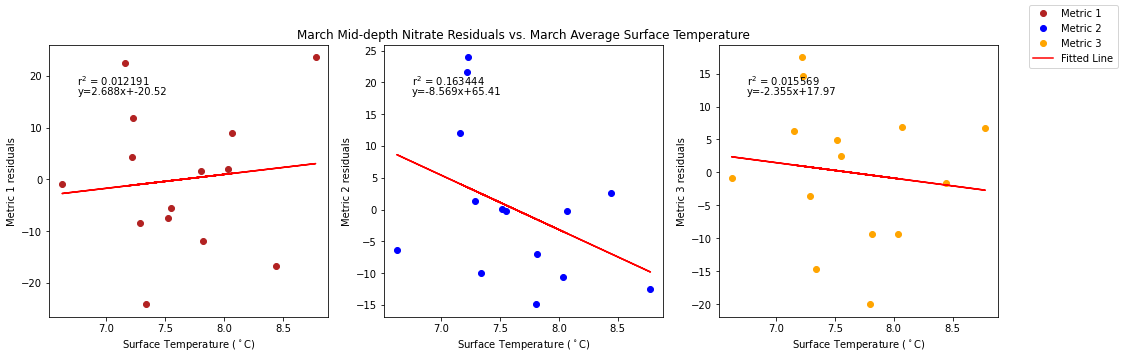

In [82]:
# ---------- Temperature ---------
fig4,ax4=plt.subplots(1,3,figsize=(17,5))
ax4[0].plot(tempmar,midno3resid1,'o',color='firebrick',label='Metric 1')
ax4[0].set_xlabel('Surface Temperature ($^\circ$C)')
ax4[0].set_ylabel('Metric 1 residuals')
y,r2,m,b=bloomdrivers.reg_r2(tempmar,midno3resid1)
ax4[0].plot(tempmar, y, 'r')
ax4[0].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[0].transAxes)
ax4[0].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[0].transAxes)

ax4[1].plot(tempmar,midno3resid2,'o',color='b',label='Metric 2')
ax4[1].set_xlabel('Surface Temperature ($^\circ$C)')
ax4[1].set_ylabel('Metric 2 residuals')
ax4[1].set_title('March Mid-depth Nitrate Residuals vs. March Average Surface Temperature')
y,r2,m,b=bloomdrivers.reg_r2(tempmar,midno3resid2)
ax4[1].plot(tempmar, y, 'r')
ax4[1].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[1].transAxes)
ax4[1].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[1].transAxes)

ax4[2].plot(tempmar,midno3resid3,'o',color='orange',label='Metric 3')
ax4[2].set_xlabel('Surface Temperature ($^\circ$C)')
ax4[2].set_ylabel('Metric 3 residuals')
y,r2,m,b=bloomdrivers.reg_r2(tempmar,midno3resid3)
ax4[2].plot(tempmar, y, 'r', label='Fitted Line')
ax4[2].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[2].transAxes)
ax4[2].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[2].transAxes)
fig4.legend()

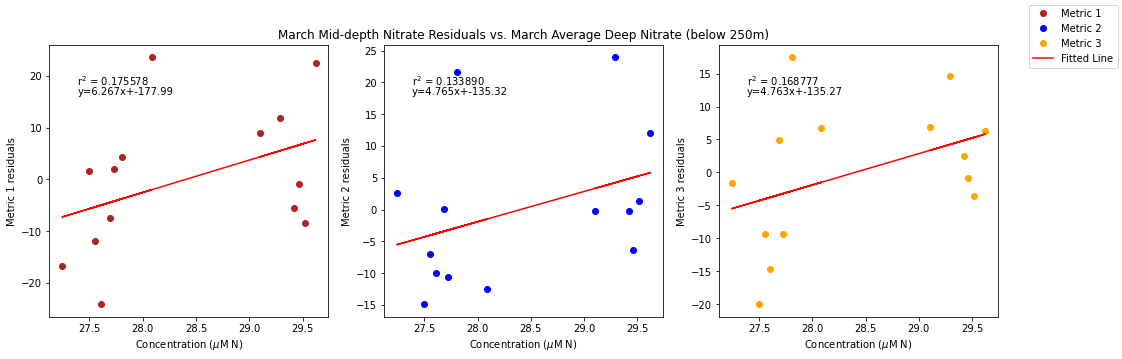

In [83]:
# ---------- Deep NO3 ---------
fig4,ax4=plt.subplots(1,3,figsize=(17,5))
ax4[0].plot(deepno3mar,midno3resid1,'o',color='firebrick',label='Metric 1')
ax4[0].set_xlabel('Concentration ($\mu$M N)')
ax4[0].set_ylabel('Metric 1 residuals')
y,r2,m,b=bloomdrivers.reg_r2(deepno3mar,midno3resid1)
ax4[0].plot(deepno3mar, y, 'r')
ax4[0].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[0].transAxes)
ax4[0].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[0].transAxes)

ax4[1].plot(deepno3mar,midno3resid2,'o',color='b',label='Metric 2')
ax4[1].set_xlabel('Concentration ($\mu$M N)')
ax4[1].set_ylabel('Metric 2 residuals')
ax4[1].set_title('March Mid-depth Nitrate Residuals vs. March Average Deep Nitrate (below 250m)')
y,r2,m,b=bloomdrivers.reg_r2(deepno3mar,midno3resid2)
ax4[1].plot(deepno3mar, y, 'r')
ax4[1].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[1].transAxes)
ax4[1].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[1].transAxes)

ax4[2].plot(deepno3mar,midno3resid3,'o',color='orange',label='Metric 3')
ax4[2].set_xlabel('Concentration ($\mu$M N)')
ax4[2].set_ylabel('Metric 3 residuals')
y,r2,m,b=bloomdrivers.reg_r2(deepno3mar,midno3resid3)
ax4[2].plot(deepno3mar, y, 'r', label='Fitted Line')
ax4[2].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[2].transAxes)
ax4[2].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[2].transAxes)
fig4.legend()

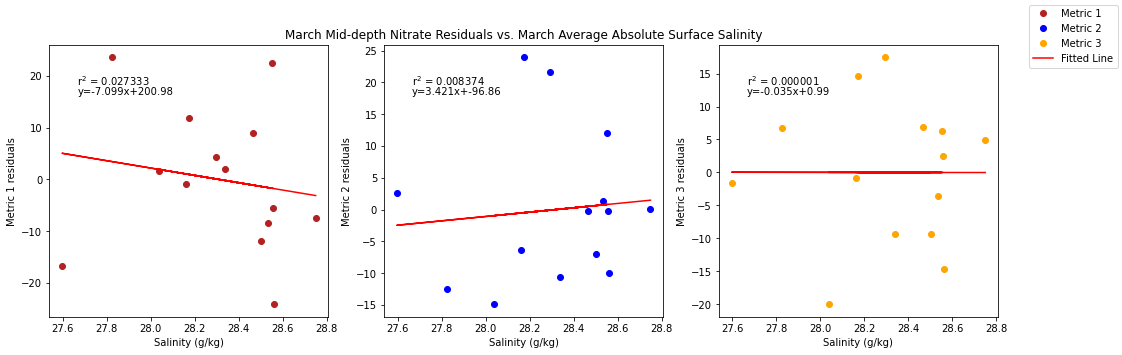

In [84]:
# ---------- Salinity ---------
fig4,ax4=plt.subplots(1,3,figsize=(17,5))
ax4[0].plot(salmar,midno3resid1,'o',color='firebrick',label='Metric 1')
ax4[0].set_xlabel('Salinity (g/kg)')
ax4[0].set_ylabel('Metric 1 residuals')
y,r2,m,b=bloomdrivers.reg_r2(salmar,midno3resid1)
ax4[0].plot(salmar, y, 'r')
ax4[0].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[0].transAxes)
ax4[0].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[0].transAxes)

ax4[1].plot(salmar,midno3resid2,'o',color='b',label='Metric 2')
ax4[1].set_xlabel('Salinity (g/kg)')
ax4[1].set_ylabel('Metric 2 residuals')
ax4[1].set_title('March Mid-depth Nitrate Residuals vs. March Average Absolute Surface Salinity')
y,r2,m,b=bloomdrivers.reg_r2(salmar,midno3resid2)
ax4[1].plot(salmar, y, 'r')
ax4[1].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[1].transAxes)
ax4[1].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[1].transAxes)

ax4[2].plot(salmar,midno3resid3,'o',color='orange',label='Metric 3')
ax4[2].set_xlabel('Salinity (g/kg)')
ax4[2].set_ylabel('Metric 3 residuals')
y,r2,m,b=bloomdrivers.reg_r2(salmar,midno3resid3)
ax4[2].plot(salmar, y, 'r', label='Fitted Line')
ax4[2].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[2].transAxes)
ax4[2].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[2].transAxes)
fig4.legend()

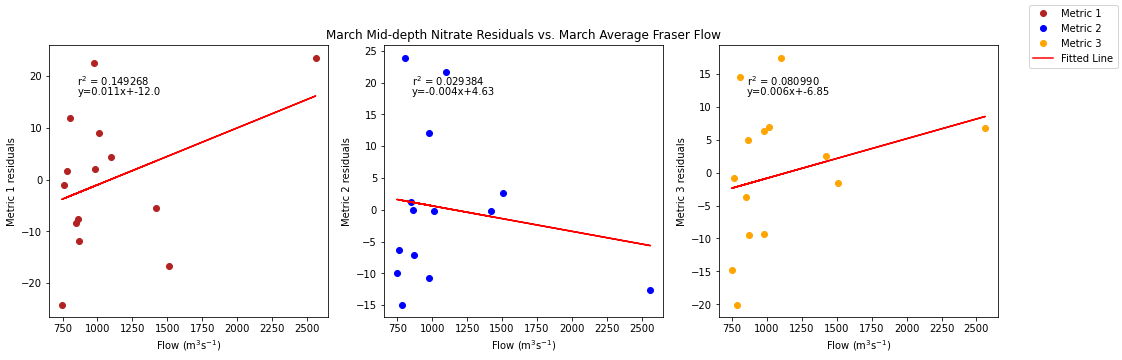

In [85]:
# ---------- Fraser ---------
fig4,ax4=plt.subplots(1,3,figsize=(17,5))
ax4[0].plot(frasermar,midno3resid1,'o',color='firebrick',label='Metric 1')
ax4[0].set_xlabel('Flow (m$^3$s$^{-1}$)')
ax4[0].set_ylabel('Metric 1 residuals')
y,r2,m,b=bloomdrivers.reg_r2(frasermar,midno3resid1)
ax4[0].plot(frasermar, y, 'r')
ax4[0].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[0].transAxes)
ax4[0].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[0].transAxes)

ax4[1].plot(frasermar,midno3resid2,'o',color='b',label='Metric 2')
ax4[1].set_xlabel('Flow (m$^3$s$^{-1}$)')
ax4[1].set_ylabel('Metric 2 residuals')
ax4[1].set_title('March Mid-depth Nitrate Residuals vs. March Average Fraser Flow')
y,r2,m,b=bloomdrivers.reg_r2(frasermar,midno3resid2)
ax4[1].plot(frasermar, y, 'r')
ax4[1].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[1].transAxes)
ax4[1].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[1].transAxes)

ax4[2].plot(frasermar,midno3resid3,'o',color='orange',label='Metric 3')
ax4[2].set_xlabel('Flow (m$^3$s$^{-1}$)')
ax4[2].set_ylabel('Metric 3 residuals')
y,r2,m,b=bloomdrivers.reg_r2(frasermar,midno3resid3)
ax4[2].plot(frasermar, y, 'r', label='Fitted Line')
ax4[2].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[2].transAxes)
ax4[2].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[2].transAxes)
fig4.legend()

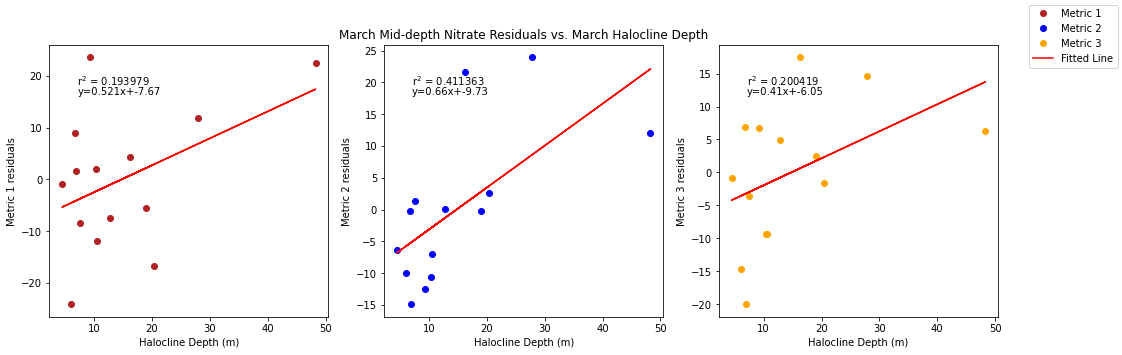

In [86]:
# ---------- Halocline ---------
fig4,ax4=plt.subplots(1,3,figsize=(17,5))
ax4[0].plot(halomar,midno3resid1,'o',color='firebrick',label='Metric 1')
ax4[0].set_xlabel('Halocline Depth (m)')
ax4[0].set_ylabel('Metric 1 residuals')
y,r2,m,b=bloomdrivers.reg_r2(halomar,midno3resid1)
ax4[0].plot(halomar, y, 'r')
ax4[0].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[0].transAxes)
ax4[0].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[0].transAxes)

ax4[1].plot(halomar,midno3resid2,'o',color='b',label='Metric 2')
ax4[1].set_xlabel('Halocline Depth (m)')
ax4[1].set_ylabel('Metric 2 residuals')
ax4[1].set_title('March Mid-depth Nitrate Residuals vs. March Halocline Depth')
y,r2,m,b=bloomdrivers.reg_r2(halomar,midno3resid2)
ax4[1].plot(halomar, y, 'r')
ax4[1].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[1].transAxes)
ax4[1].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[1].transAxes)

ax4[2].plot(halomar,midno3resid3,'o',color='orange',label='Metric 3')
ax4[2].set_xlabel('Halocline Depth (m)')
ax4[2].set_ylabel('Metric 3 residuals')
y,r2,m,b=bloomdrivers.reg_r2(halomar,midno3resid3)
ax4[2].plot(halomar, y, 'r', label='Fitted Line')
ax4[2].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[2].transAxes)
ax4[2].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[2].transAxes)
fig4.legend()

### Correlation plots of deep NO3 residuals

In [87]:
#  residual calculations for each metric
deepno3resid1=list()
y,r2,m,b=bloomdrivers.reg_r2(deepno3mar,yearday1)
for ind,y in enumerate(yearday1):
    x=deepno3mar[ind]
    deepno3resid1.append(y-(m*x+b))

deepno3resid2=list()
y,r2,m,b=bloomdrivers.reg_r2(deepno3mar,yearday2)
for ind,y in enumerate(yearday2):
    x=deepno3mar[ind]
    deepno3resid2.append(y-(m*x+b))
    
deepno3resid3=list()
y,r2,m,b=bloomdrivers.reg_r2(deepno3mar,yearday3)
for ind,y in enumerate(yearday3):
    x=deepno3mar[ind]
    deepno3resid3.append(y-(m*x+b))

In [88]:
dfdeepno3=pd.DataFrame({'deepno3':deepno3mar,'deepno3resid1':deepno3resid1,'deepno3resid2':deepno3resid2,'deepno3resid3':deepno3resid3,'wind':windmar,'solar':solarmar,
                        'temp':tempmar,'sal':salmar,'fraser':frasermar,'midno3':midno3mar,'halocine':halomar})

<AxesSubplot:>

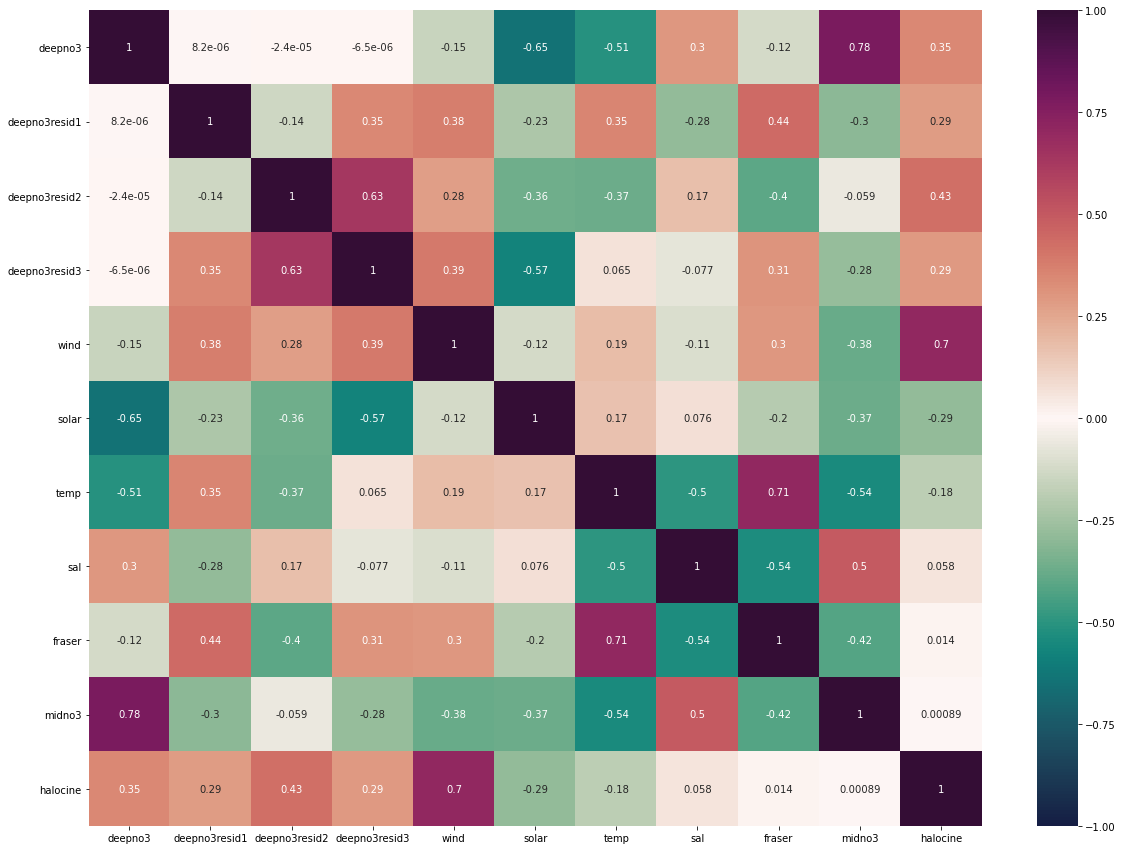

In [89]:
plt.subplots(figsize=(20,15))
cm1=cmocean.cm.curl
sns.heatmap(dfdeepno3.corr(), annot = True,cmap=cm1,vmin=-1,vmax=1)

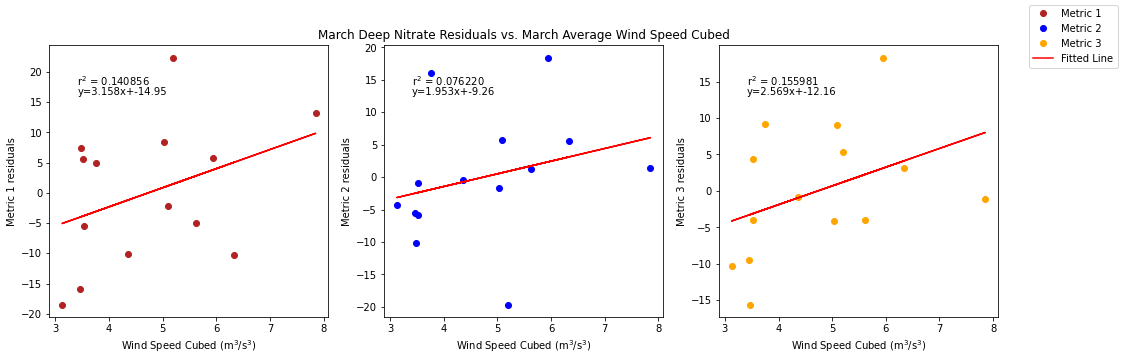

In [90]:
# ---------- wind ---------
fig4,ax4=plt.subplots(1,3,figsize=(17,5))
ax4[0].plot(windmar,deepno3resid1,'o',color='firebrick',label='Metric 1')
ax4[0].set_xlabel('Wind Speed Cubed ($\mathregular{m^3}$/$\mathregular{s^3}$)')
ax4[0].set_ylabel('Metric 1 residuals')
y,r2,m,b=bloomdrivers.reg_r2(windmar,deepno3resid1)
ax4[0].plot(windmar, y, 'r')
ax4[0].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[0].transAxes)
ax4[0].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[0].transAxes)

ax4[1].plot(windmar,deepno3resid2,'o',color='b',label='Metric 2')
ax4[1].set_xlabel('Wind Speed Cubed ($\mathregular{m^3}$/$\mathregular{s^3}$)')
ax4[1].set_ylabel('Metric 2 residuals')
ax4[1].set_title('March Deep Nitrate Residuals vs. March Average Wind Speed Cubed')
y,r2,m,b=bloomdrivers.reg_r2(windmar,deepno3resid2)
ax4[1].plot(windmar, y, 'r')
ax4[1].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[1].transAxes)
ax4[1].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[1].transAxes)

ax4[2].plot(windmar,deepno3resid3,'o',color='orange',label='Metric 3')
ax4[2].set_xlabel('Wind Speed Cubed ($\mathregular{m^3}$/$\mathregular{s^3}$)')
ax4[2].set_ylabel('Metric 3 residuals')
y,r2,m,b=bloomdrivers.reg_r2(windmar,deepno3resid3)
ax4[2].plot(windmar, y, 'r', label='Fitted Line')
ax4[2].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[2].transAxes)
ax4[2].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[2].transAxes)
fig4.legend()

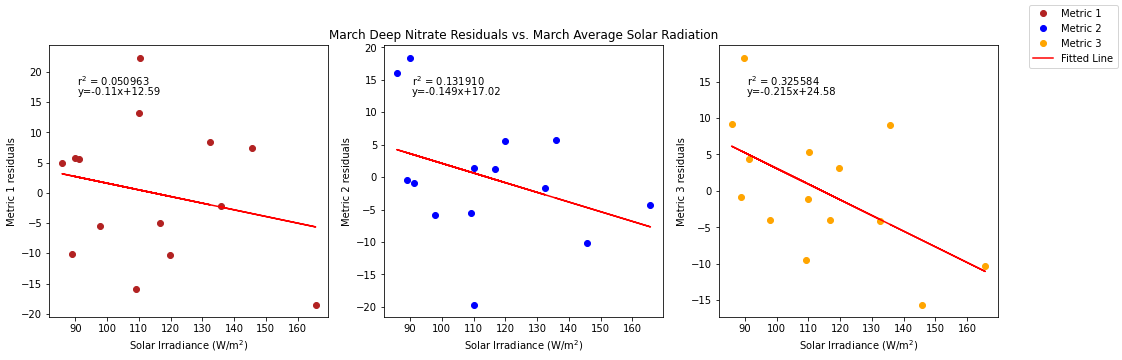

In [91]:
# ---------- Solar ---------
fig4,ax4=plt.subplots(1,3,figsize=(17,5))
ax4[0].plot(solarmar,deepno3resid1,'o',color='firebrick',label='Metric 1')
ax4[0].set_xlabel('Solar Irradiance (W/$\mathregular{m^2}$)')
ax4[0].set_ylabel('Metric 1 residuals')
y,r2,m,b=bloomdrivers.reg_r2(solarmar,deepno3resid1)
ax4[0].plot(solarmar, y, 'r')
ax4[0].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[0].transAxes)
ax4[0].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[0].transAxes)

ax4[1].plot(solarmar,deepno3resid2,'o',color='b',label='Metric 2')
ax4[1].set_xlabel('Solar Irradiance (W/$\mathregular{m^2}$)')
ax4[1].set_ylabel('Metric 2 residuals')
ax4[1].set_title('March Deep Nitrate Residuals vs. March Average Solar Radiation')
y,r2,m,b=bloomdrivers.reg_r2(solarmar,deepno3resid2)
ax4[1].plot(solarmar, y, 'r')
ax4[1].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[1].transAxes)
ax4[1].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[1].transAxes)

ax4[2].plot(solarmar,deepno3resid3,'o',color='orange',label='Metric 3')
ax4[2].set_xlabel('Solar Irradiance (W/$\mathregular{m^2}$)')
ax4[2].set_ylabel('Metric 3 residuals')
y,r2,m,b=bloomdrivers.reg_r2(solarmar,deepno3resid3)
ax4[2].plot(solarmar, y, 'r', label='Fitted Line')
ax4[2].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[2].transAxes)
ax4[2].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[2].transAxes)
fig4.legend()

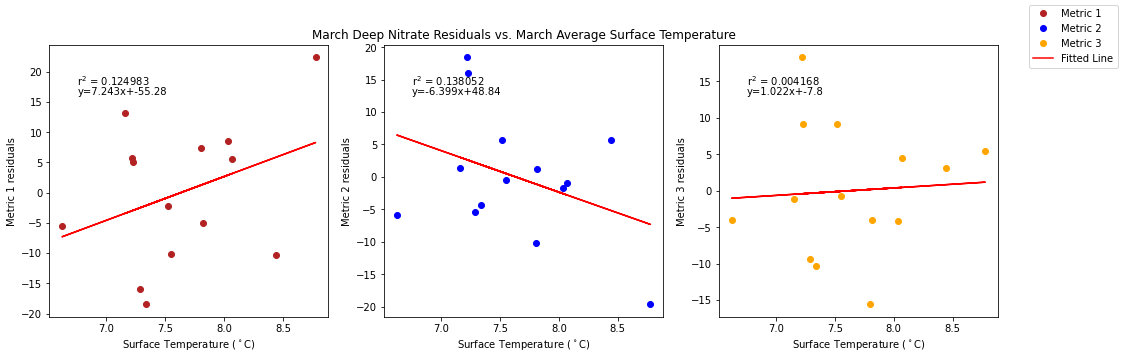

In [92]:
# ---------- Temperature ---------
fig4,ax4=plt.subplots(1,3,figsize=(17,5))
ax4[0].plot(tempmar,deepno3resid1,'o',color='firebrick',label='Metric 1')
ax4[0].set_xlabel('Surface Temperature ($^\circ$C)')
ax4[0].set_ylabel('Metric 1 residuals')
y,r2,m,b=bloomdrivers.reg_r2(tempmar,deepno3resid1)
ax4[0].plot(tempmar, y, 'r')
ax4[0].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[0].transAxes)
ax4[0].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[0].transAxes)

ax4[1].plot(tempmar,deepno3resid2,'o',color='b',label='Metric 2')
ax4[1].set_xlabel('Surface Temperature ($^\circ$C)')
ax4[1].set_ylabel('Metric 2 residuals')
ax4[1].set_title('March Deep Nitrate Residuals vs. March Average Surface Temperature')
y,r2,m,b=bloomdrivers.reg_r2(tempmar,deepno3resid2)
ax4[1].plot(tempmar, y, 'r')
ax4[1].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[1].transAxes)
ax4[1].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[1].transAxes)

ax4[2].plot(tempmar,deepno3resid3,'o',color='orange',label='Metric 3')
ax4[2].set_xlabel('Surface Temperature ($^\circ$C)')
ax4[2].set_ylabel('Metric 3 residuals')
y,r2,m,b=bloomdrivers.reg_r2(tempmar,deepno3resid3)
ax4[2].plot(tempmar, y, 'r', label='Fitted Line')
ax4[2].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[2].transAxes)
ax4[2].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[2].transAxes)
fig4.legend()

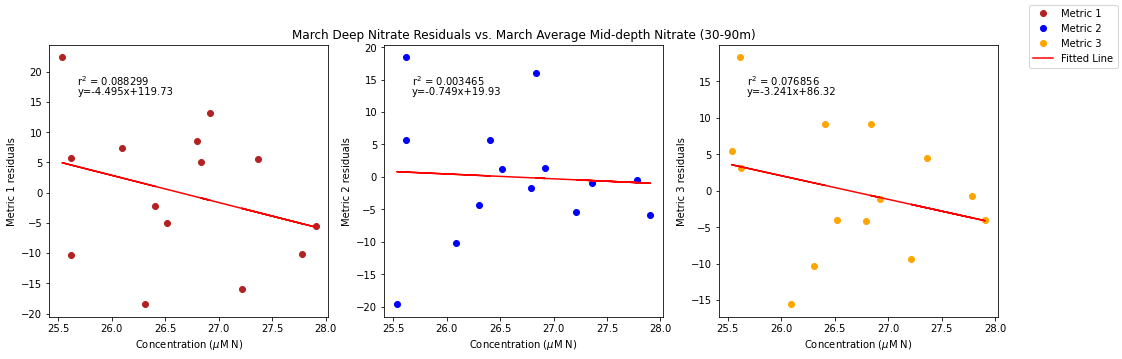

In [93]:
# ---------- Deep NO3 ---------
fig4,ax4=plt.subplots(1,3,figsize=(17,5))
ax4[0].plot(midno3mar,deepno3resid1,'o',color='firebrick',label='Metric 1')
ax4[0].set_xlabel('Concentration ($\mu$M N)')
ax4[0].set_ylabel('Metric 1 residuals')
y,r2,m,b=bloomdrivers.reg_r2(midno3mar,deepno3resid1)
ax4[0].plot(midno3mar, y, 'r')
ax4[0].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[0].transAxes)
ax4[0].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[0].transAxes)

ax4[1].plot(midno3mar,deepno3resid2,'o',color='b',label='Metric 2')
ax4[1].set_xlabel('Concentration ($\mu$M N)')
ax4[1].set_ylabel('Metric 2 residuals')
ax4[1].set_title('March Deep Nitrate Residuals vs. March Average Mid-depth Nitrate (30-90m)')
y,r2,m,b=bloomdrivers.reg_r2(midno3mar,deepno3resid2)
ax4[1].plot(midno3mar, y, 'r')
ax4[1].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[1].transAxes)
ax4[1].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[1].transAxes)

ax4[2].plot(midno3mar,deepno3resid3,'o',color='orange',label='Metric 3')
ax4[2].set_xlabel('Concentration ($\mu$M N)')
ax4[2].set_ylabel('Metric 3 residuals')
y,r2,m,b=bloomdrivers.reg_r2(midno3mar,deepno3resid3)
ax4[2].plot(midno3mar, y, 'r', label='Fitted Line')
ax4[2].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[2].transAxes)
ax4[2].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[2].transAxes)
fig4.legend()

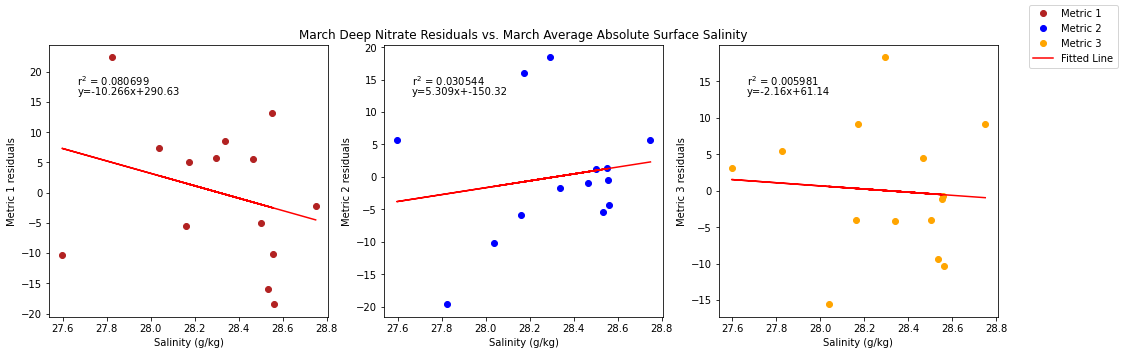

In [94]:
# ---------- Salinity ---------
fig4,ax4=plt.subplots(1,3,figsize=(17,5))
ax4[0].plot(salmar,deepno3resid1,'o',color='firebrick',label='Metric 1')
ax4[0].set_xlabel('Salinity (g/kg)')
ax4[0].set_ylabel('Metric 1 residuals')
y,r2,m,b=bloomdrivers.reg_r2(salmar,deepno3resid1)
ax4[0].plot(salmar, y, 'r')
ax4[0].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[0].transAxes)
ax4[0].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[0].transAxes)

ax4[1].plot(salmar,deepno3resid2,'o',color='b',label='Metric 2')
ax4[1].set_xlabel('Salinity (g/kg)')
ax4[1].set_ylabel('Metric 2 residuals')
ax4[1].set_title('March Deep Nitrate Residuals vs. March Average Absolute Surface Salinity')
y,r2,m,b=bloomdrivers.reg_r2(salmar,deepno3resid2)
ax4[1].plot(salmar, y, 'r')
ax4[1].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[1].transAxes)
ax4[1].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[1].transAxes)

ax4[2].plot(salmar,deepno3resid3,'o',color='orange',label='Metric 3')
ax4[2].set_xlabel('Salinity (g/kg)')
ax4[2].set_ylabel('Metric 3 residuals')
y,r2,m,b=bloomdrivers.reg_r2(salmar,deepno3resid3)
ax4[2].plot(salmar, y, 'r', label='Fitted Line')
ax4[2].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[2].transAxes)
ax4[2].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[2].transAxes)
fig4.legend()

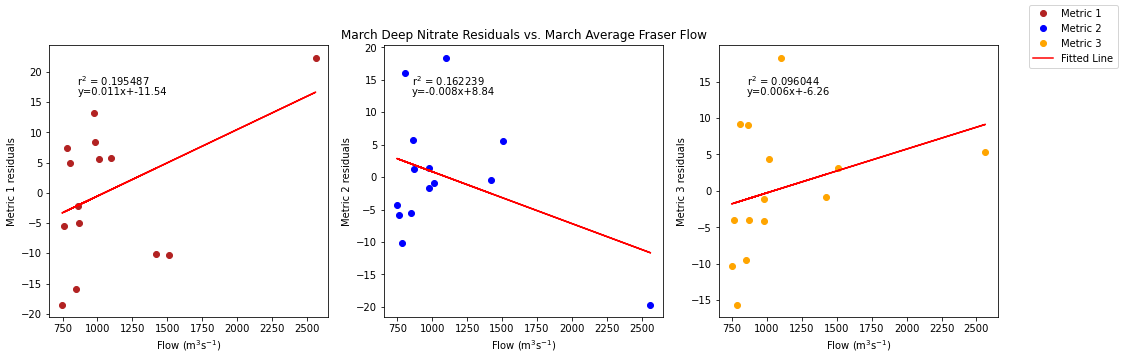

In [95]:
# ---------- Fraser ---------
fig4,ax4=plt.subplots(1,3,figsize=(17,5))
ax4[0].plot(frasermar,deepno3resid1,'o',color='firebrick',label='Metric 1')
ax4[0].set_xlabel('Flow (m$^3$s$^{-1}$)')
ax4[0].set_ylabel('Metric 1 residuals')
y,r2,m,b=bloomdrivers.reg_r2(frasermar,deepno3resid1)
ax4[0].plot(frasermar, y, 'r')
ax4[0].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[0].transAxes)
ax4[0].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[0].transAxes)

ax4[1].plot(frasermar,deepno3resid2,'o',color='b',label='Metric 2')
ax4[1].set_xlabel('Flow (m$^3$s$^{-1}$)')
ax4[1].set_ylabel('Metric 2 residuals')
ax4[1].set_title('March Deep Nitrate Residuals vs. March Average Fraser Flow')
y,r2,m,b=bloomdrivers.reg_r2(frasermar,deepno3resid2)
ax4[1].plot(frasermar, y, 'r')
ax4[1].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[1].transAxes)
ax4[1].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[1].transAxes)

ax4[2].plot(frasermar,deepno3resid3,'o',color='orange',label='Metric 3')
ax4[2].set_xlabel('Flow (m$^3$s$^{-1}$)')
ax4[2].set_ylabel('Metric 3 residuals')
y,r2,m,b=bloomdrivers.reg_r2(frasermar,deepno3resid3)
ax4[2].plot(frasermar, y, 'r', label='Fitted Line')
ax4[2].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[2].transAxes)
ax4[2].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[2].transAxes)
fig4.legend()

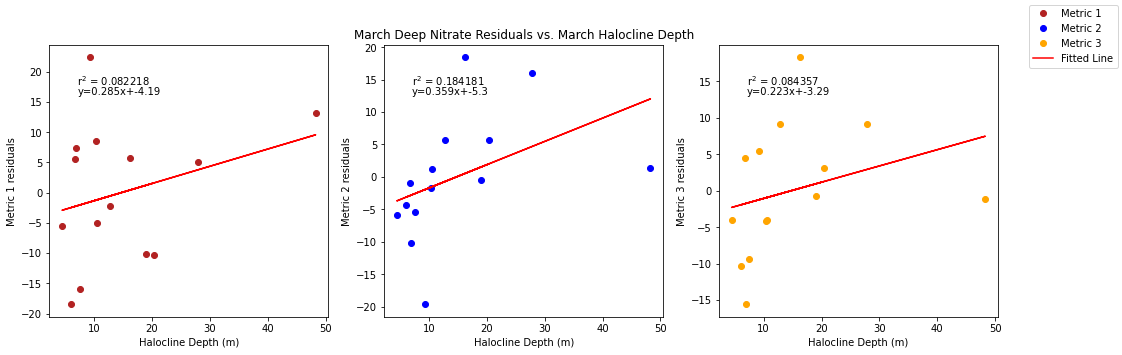

In [96]:
# ---------- Halocline ---------
fig4,ax4=plt.subplots(1,3,figsize=(17,5))
ax4[0].plot(halomar,deepno3resid1,'o',color='firebrick',label='Metric 1')
ax4[0].set_xlabel('Halocline Depth (m)')
ax4[0].set_ylabel('Metric 1 residuals')
y,r2,m,b=bloomdrivers.reg_r2(halomar,deepno3resid1)
ax4[0].plot(halomar, y, 'r')
ax4[0].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[0].transAxes)
ax4[0].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[0].transAxes)

ax4[1].plot(halomar,deepno3resid2,'o',color='b',label='Metric 2')
ax4[1].set_xlabel('Halocline Depth (m)')
ax4[1].set_ylabel('Metric 2 residuals')
ax4[1].set_title('March Deep Nitrate Residuals vs. March Halocline Depth')
y,r2,m,b=bloomdrivers.reg_r2(halomar,deepno3resid2)
ax4[1].plot(halomar, y, 'r')
ax4[1].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[1].transAxes)
ax4[1].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[1].transAxes)

ax4[2].plot(halomar,deepno3resid3,'o',color='orange',label='Metric 3')
ax4[2].set_xlabel('Halocline Depth (m)')
ax4[2].set_ylabel('Metric 3 residuals')
y,r2,m,b=bloomdrivers.reg_r2(halomar,deepno3resid3)
ax4[2].plot(halomar, y, 'r', label='Fitted Line')
ax4[2].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[2].transAxes)
ax4[2].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[2].transAxes)
fig4.legend()

### Correlation plots of Salinity residuals

In [97]:
#  residual calculations for each metric
salresid1=list()
y,r2,m,b=bloomdrivers.reg_r2(salmar,yearday1)
for ind,y in enumerate(yearday1):
    x=salmar[ind]
    salresid1.append(y-(m*x+b))

salresid2=list()
y,r2,m,b=bloomdrivers.reg_r2(salmar,yearday2)
for ind,y in enumerate(yearday2):
    x=salmar[ind]
    salresid2.append(y-(m*x+b))
    
salresid3=list()
y,r2,m,b=bloomdrivers.reg_r2(salmar,yearday3)
for ind,y in enumerate(yearday3):
    x=salmar[ind]
    salresid3.append(y-(m*x+b))

In [98]:
dfsal=pd.DataFrame({'sal':salmar,'salresid1':salresid1,'salresid2':salresid2,'salresid3':salresid3,'wind':windmar,'solar':solarmar,
                    'temp':tempmar,'fraser':frasermar,'midno3':midno3mar,'deepno3':deepno3mar,'halocine':halomar})

<AxesSubplot:>

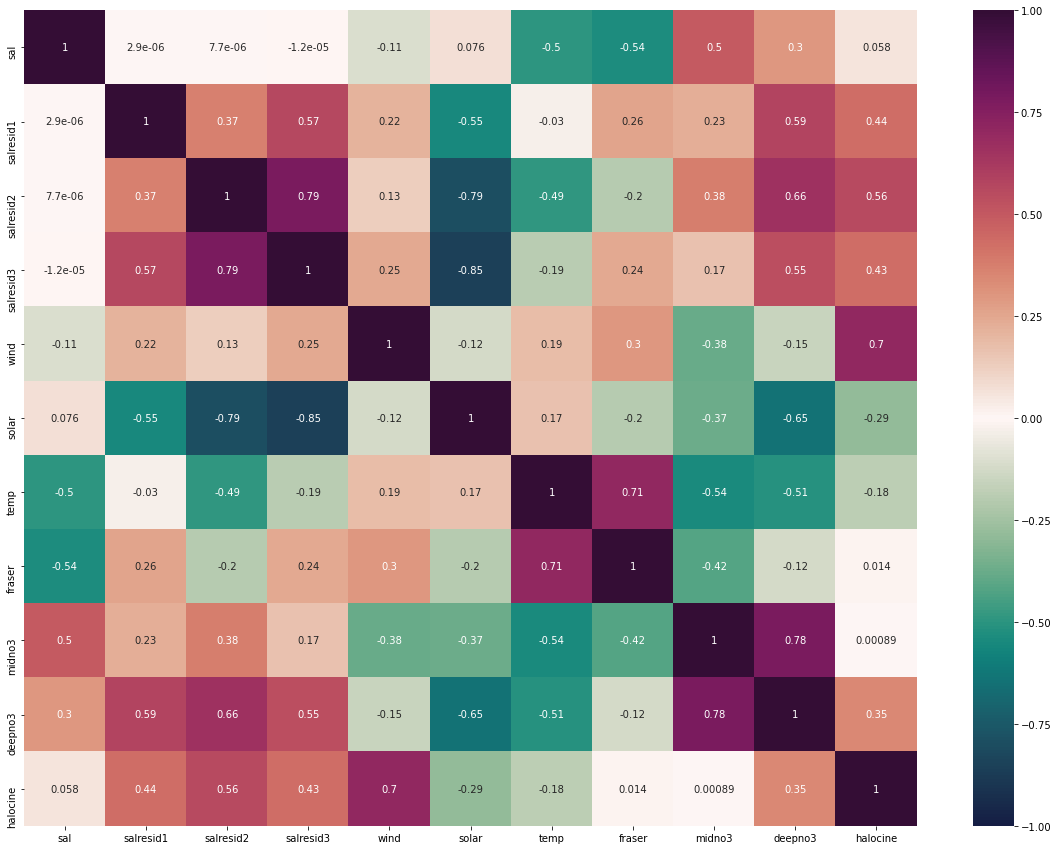

In [99]:
plt.subplots(figsize=(20,15))
cm1=cmocean.cm.curl
sns.heatmap(dfsal.corr(), annot = True,cmap=cm1,vmin=-1,vmax=1)

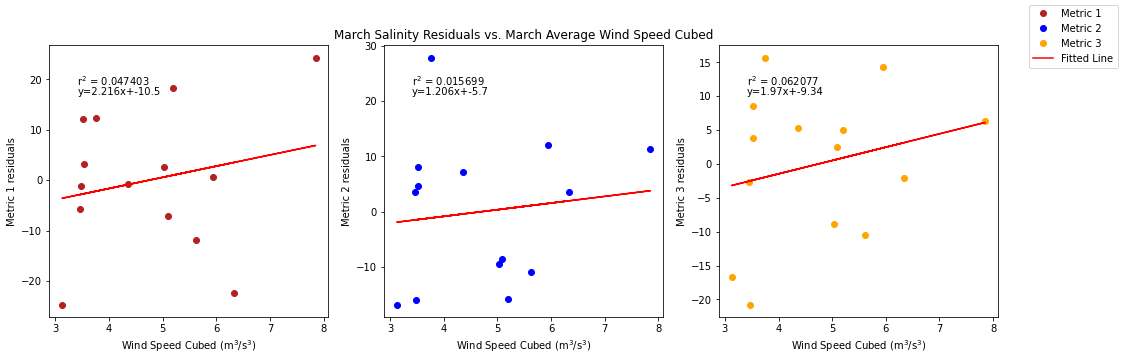

In [100]:
# ---------- wind ---------
fig4,ax4=plt.subplots(1,3,figsize=(17,5))
ax4[0].plot(windmar,salresid1,'o',color='firebrick',label='Metric 1')
ax4[0].set_xlabel('Wind Speed Cubed ($\mathregular{m^3}$/$\mathregular{s^3}$)')
ax4[0].set_ylabel('Metric 1 residuals')
y,r2,m,b=bloomdrivers.reg_r2(windmar,salresid1)
ax4[0].plot(windmar, y, 'r')
ax4[0].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[0].transAxes)
ax4[0].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[0].transAxes)

ax4[1].plot(windmar,salresid2,'o',color='b',label='Metric 2')
ax4[1].set_xlabel('Wind Speed Cubed ($\mathregular{m^3}$/$\mathregular{s^3}$)')
ax4[1].set_ylabel('Metric 2 residuals')
ax4[1].set_title('March Salinity Residuals vs. March Average Wind Speed Cubed')
y,r2,m,b=bloomdrivers.reg_r2(windmar,salresid2)
ax4[1].plot(windmar, y, 'r')
ax4[1].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[1].transAxes)
ax4[1].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[1].transAxes)

ax4[2].plot(windmar,salresid3,'o',color='orange',label='Metric 3')
ax4[2].set_xlabel('Wind Speed Cubed ($\mathregular{m^3}$/$\mathregular{s^3}$)')
ax4[2].set_ylabel('Metric 3 residuals')
y,r2,m,b=bloomdrivers.reg_r2(windmar,salresid3)
ax4[2].plot(windmar, y, 'r', label='Fitted Line')
ax4[2].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[2].transAxes)
ax4[2].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[2].transAxes)
fig4.legend()

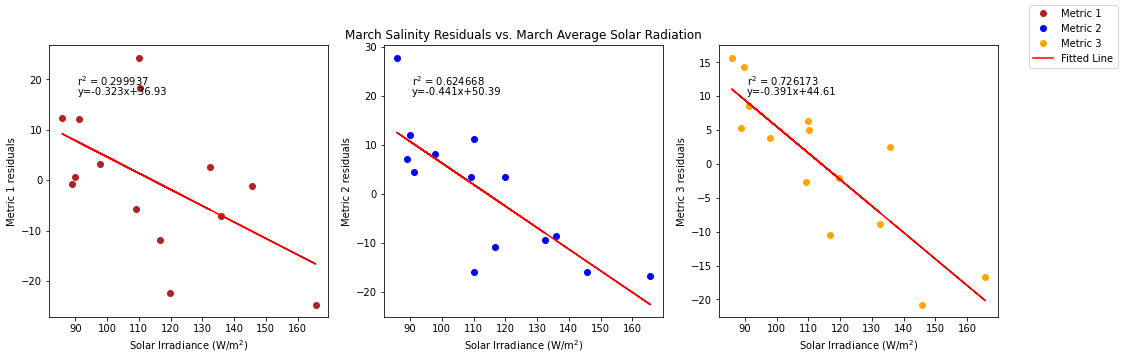

In [101]:
# ---------- Solar ---------
fig4,ax4=plt.subplots(1,3,figsize=(17,5))
ax4[0].plot(solarmar,salresid1,'o',color='firebrick',label='Metric 1')
ax4[0].set_xlabel('Solar Irradiance (W/$\mathregular{m^2}$)')
ax4[0].set_ylabel('Metric 1 residuals')
y,r2,m,b=bloomdrivers.reg_r2(solarmar,salresid1)
ax4[0].plot(solarmar, y, 'r')
ax4[0].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[0].transAxes)
ax4[0].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[0].transAxes)

ax4[1].plot(solarmar,salresid2,'o',color='b',label='Metric 2')
ax4[1].set_xlabel('Solar Irradiance (W/$\mathregular{m^2}$)')
ax4[1].set_ylabel('Metric 2 residuals')
ax4[1].set_title('March Salinity Residuals vs. March Average Solar Radiation')
y,r2,m,b=bloomdrivers.reg_r2(solarmar,salresid2)
ax4[1].plot(solarmar, y, 'r')
ax4[1].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[1].transAxes)
ax4[1].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[1].transAxes)

ax4[2].plot(solarmar,salresid3,'o',color='orange',label='Metric 3')
ax4[2].set_xlabel('Solar Irradiance (W/$\mathregular{m^2}$)')
ax4[2].set_ylabel('Metric 3 residuals')
y,r2,m,b=bloomdrivers.reg_r2(solarmar,salresid3)
ax4[2].plot(solarmar, y, 'r', label='Fitted Line')
ax4[2].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[2].transAxes)
ax4[2].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[2].transAxes)
fig4.legend()

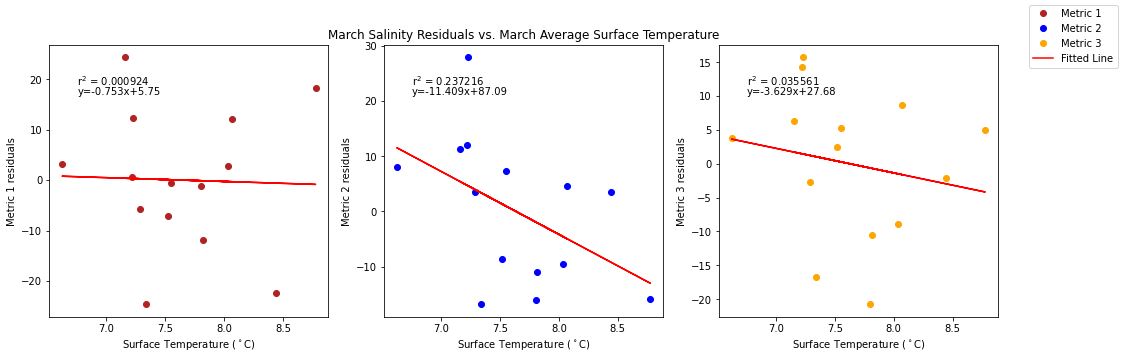

In [102]:
# ---------- Temperature ---------
fig4,ax4=plt.subplots(1,3,figsize=(17,5))
ax4[0].plot(tempmar,salresid1,'o',color='firebrick',label='Metric 1')
ax4[0].set_xlabel('Surface Temperature ($^\circ$C)')
ax4[0].set_ylabel('Metric 1 residuals')
y,r2,m,b=bloomdrivers.reg_r2(tempmar,salresid1)
ax4[0].plot(tempmar, y, 'r')
ax4[0].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[0].transAxes)
ax4[0].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[0].transAxes)

ax4[1].plot(tempmar,salresid2,'o',color='b',label='Metric 2')
ax4[1].set_xlabel('Surface Temperature ($^\circ$C)')
ax4[1].set_ylabel('Metric 2 residuals')
ax4[1].set_title('March Salinity Residuals vs. March Average Surface Temperature')
y,r2,m,b=bloomdrivers.reg_r2(tempmar,salresid2)
ax4[1].plot(tempmar, y, 'r')
ax4[1].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[1].transAxes)
ax4[1].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[1].transAxes)

ax4[2].plot(tempmar,salresid3,'o',color='orange',label='Metric 3')
ax4[2].set_xlabel('Surface Temperature ($^\circ$C)')
ax4[2].set_ylabel('Metric 3 residuals')
y,r2,m,b=bloomdrivers.reg_r2(tempmar,salresid3)
ax4[2].plot(tempmar, y, 'r', label='Fitted Line')
ax4[2].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[2].transAxes)
ax4[2].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[2].transAxes)
fig4.legend()

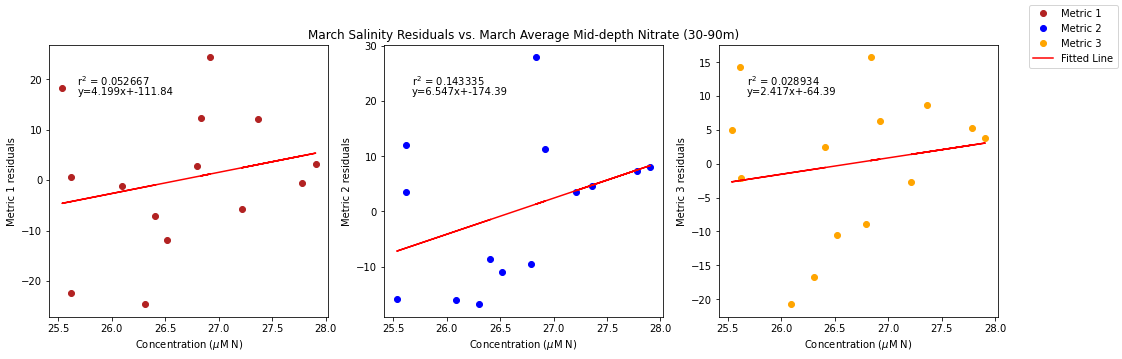

In [103]:
# ---------- Deep NO3 ---------
fig4,ax4=plt.subplots(1,3,figsize=(17,5))
ax4[0].plot(midno3mar,salresid1,'o',color='firebrick',label='Metric 1')
ax4[0].set_xlabel('Concentration ($\mu$M N)')
ax4[0].set_ylabel('Metric 1 residuals')
y,r2,m,b=bloomdrivers.reg_r2(midno3mar,salresid1)
ax4[0].plot(midno3mar, y, 'r')
ax4[0].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[0].transAxes)
ax4[0].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[0].transAxes)

ax4[1].plot(midno3mar,salresid2,'o',color='b',label='Metric 2')
ax4[1].set_xlabel('Concentration ($\mu$M N)')
ax4[1].set_ylabel('Metric 2 residuals')
ax4[1].set_title('March Salinity Residuals vs. March Average Mid-depth Nitrate (30-90m)')
y,r2,m,b=bloomdrivers.reg_r2(midno3mar,salresid2)
ax4[1].plot(midno3mar, y, 'r')
ax4[1].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[1].transAxes)
ax4[1].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[1].transAxes)

ax4[2].plot(midno3mar,salresid3,'o',color='orange',label='Metric 3')
ax4[2].set_xlabel('Concentration ($\mu$M N)')
ax4[2].set_ylabel('Metric 3 residuals')
y,r2,m,b=bloomdrivers.reg_r2(midno3mar,salresid3)
ax4[2].plot(midno3mar, y, 'r', label='Fitted Line')
ax4[2].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[2].transAxes)
ax4[2].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[2].transAxes)
fig4.legend()

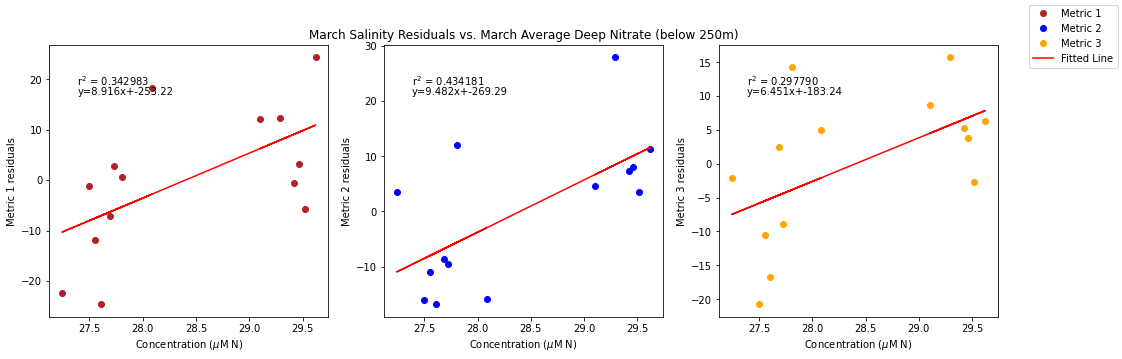

In [104]:
# ---------- Deep NO3 ---------
fig4,ax4=plt.subplots(1,3,figsize=(17,5))
ax4[0].plot(deepno3mar,salresid1,'o',color='firebrick',label='Metric 1')
ax4[0].set_xlabel('Concentration ($\mu$M N)')
ax4[0].set_ylabel('Metric 1 residuals')
y,r2,m,b=bloomdrivers.reg_r2(deepno3mar,salresid1)
ax4[0].plot(deepno3mar, y, 'r')
ax4[0].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[0].transAxes)
ax4[0].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[0].transAxes)

ax4[1].plot(deepno3mar,salresid2,'o',color='b',label='Metric 2')
ax4[1].set_xlabel('Concentration ($\mu$M N)')
ax4[1].set_ylabel('Metric 2 residuals')
ax4[1].set_title('March Salinity Residuals vs. March Average Deep Nitrate (below 250m)')
y,r2,m,b=bloomdrivers.reg_r2(deepno3mar,salresid2)
ax4[1].plot(deepno3mar, y, 'r')
ax4[1].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[1].transAxes)
ax4[1].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[1].transAxes)

ax4[2].plot(deepno3mar,salresid3,'o',color='orange',label='Metric 3')
ax4[2].set_xlabel('Concentration ($\mu$M N)')
ax4[2].set_ylabel('Metric 3 residuals')
y,r2,m,b=bloomdrivers.reg_r2(deepno3mar,salresid3)
ax4[2].plot(deepno3mar, y, 'r', label='Fitted Line')
ax4[2].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[2].transAxes)
ax4[2].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[2].transAxes)
fig4.legend()

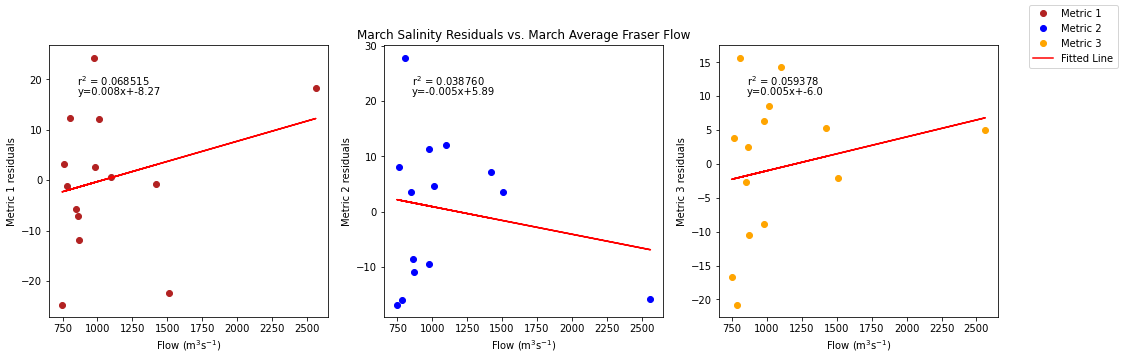

In [105]:
# ---------- Fraser ---------
fig4,ax4=plt.subplots(1,3,figsize=(17,5))
ax4[0].plot(frasermar,salresid1,'o',color='firebrick',label='Metric 1')
ax4[0].set_xlabel('Flow (m$^3$s$^{-1}$)')
ax4[0].set_ylabel('Metric 1 residuals')
y,r2,m,b=bloomdrivers.reg_r2(frasermar,salresid1)
ax4[0].plot(frasermar, y, 'r')
ax4[0].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[0].transAxes)
ax4[0].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[0].transAxes)

ax4[1].plot(frasermar,salresid2,'o',color='b',label='Metric 2')
ax4[1].set_xlabel('Flow (m$^3$s$^{-1}$)')
ax4[1].set_ylabel('Metric 2 residuals')
ax4[1].set_title('March Salinity Residuals vs. March Average Fraser Flow')
y,r2,m,b=bloomdrivers.reg_r2(frasermar,salresid2)
ax4[1].plot(frasermar, y, 'r')
ax4[1].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[1].transAxes)
ax4[1].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[1].transAxes)

ax4[2].plot(frasermar,salresid3,'o',color='orange',label='Metric 3')
ax4[2].set_xlabel('Flow (m$^3$s$^{-1}$)')
ax4[2].set_ylabel('Metric 3 residuals')
y,r2,m,b=bloomdrivers.reg_r2(frasermar,salresid3)
ax4[2].plot(frasermar, y, 'r', label='Fitted Line')
ax4[2].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[2].transAxes)
ax4[2].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[2].transAxes)
fig4.legend()

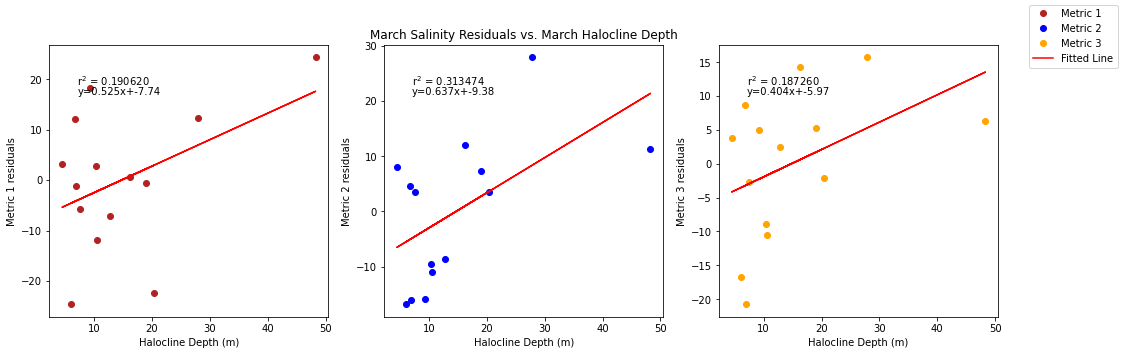

In [106]:
# ---------- Halocline ---------
fig4,ax4=plt.subplots(1,3,figsize=(17,5))
ax4[0].plot(halomar,salresid1,'o',color='firebrick',label='Metric 1')
ax4[0].set_xlabel('Halocline Depth (m)')
ax4[0].set_ylabel('Metric 1 residuals')
y,r2,m,b=bloomdrivers.reg_r2(halomar,salresid1)
ax4[0].plot(halomar, y, 'r')
ax4[0].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[0].transAxes)
ax4[0].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[0].transAxes)

ax4[1].plot(halomar,salresid2,'o',color='b',label='Metric 2')
ax4[1].set_xlabel('Halocline Depth (m)')
ax4[1].set_ylabel('Metric 2 residuals')
ax4[1].set_title('March Salinity Residuals vs. March Halocline Depth')
y,r2,m,b=bloomdrivers.reg_r2(halomar,salresid2)
ax4[1].plot(halomar, y, 'r')
ax4[1].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[1].transAxes)
ax4[1].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[1].transAxes)

ax4[2].plot(halomar,salresid3,'o',color='orange',label='Metric 3')
ax4[2].set_xlabel('Halocline Depth (m)')
ax4[2].set_ylabel('Metric 3 residuals')
y,r2,m,b=bloomdrivers.reg_r2(halomar,salresid3)
ax4[2].plot(halomar, y, 'r', label='Fitted Line')
ax4[2].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[2].transAxes)
ax4[2].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[2].transAxes)
fig4.legend()

### Correlation plots of Fraser residuals

In [107]:
#  residual calculations for each metric
fraserresid1=list()
y,r2,m,b=bloomdrivers.reg_r2(frasermar,yearday1)
for ind,y in enumerate(yearday1):
    x=frasermar[ind]
    fraserresid1.append(y-(m*x+b))

fraserresid2=list()
y,r2,m,b=bloomdrivers.reg_r2(frasermar,yearday2)
for ind,y in enumerate(yearday2):
    x=frasermar[ind]
    fraserresid2.append(y-(m*x+b))
    
fraserresid3=list()
y,r2,m,b=bloomdrivers.reg_r2(frasermar,yearday3)
for ind,y in enumerate(yearday3):
    x=frasermar[ind]
    fraserresid3.append(y-(m*x+b))

In [108]:
dffraser=pd.DataFrame({'fraser':frasermar,'fraserresid1':fraserresid1,'fraserresid2':fraserresid2,'fraserresid3':fraserresid3,'wind':windmar,'solar':solarmar,
                    'temp':tempmar,'midno3':midno3mar,'deepno3':deepno3mar,'halocine':halomar})

<AxesSubplot:>

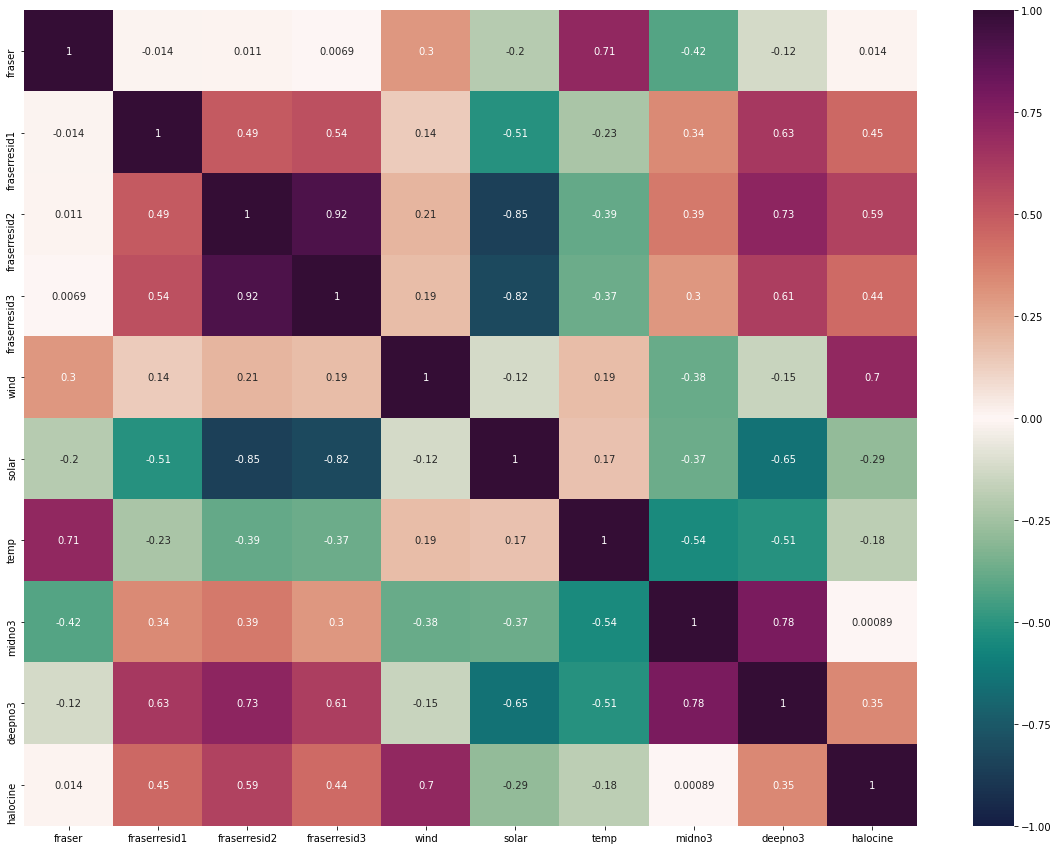

In [109]:
plt.subplots(figsize=(20,15))
cm1=cmocean.cm.curl
sns.heatmap(dffraser.corr(), annot = True,cmap=cm1,vmin=-1,vmax=1)

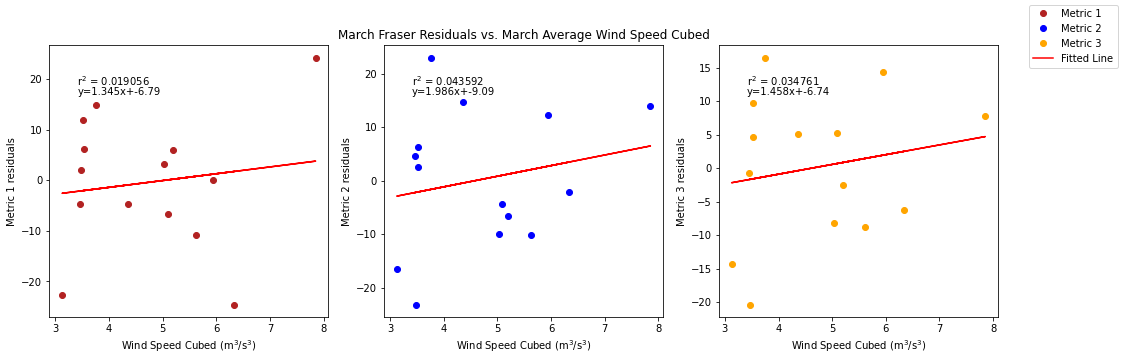

In [110]:
# ---------- wind ---------
fig4,ax4=plt.subplots(1,3,figsize=(17,5))
ax4[0].plot(windmar,fraserresid1,'o',color='firebrick',label='Metric 1')
ax4[0].set_xlabel('Wind Speed Cubed ($\mathregular{m^3}$/$\mathregular{s^3}$)')
ax4[0].set_ylabel('Metric 1 residuals')
y,r2,m,b=bloomdrivers.reg_r2(windmar,fraserresid1)
ax4[0].plot(windmar, y, 'r')
ax4[0].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[0].transAxes)
ax4[0].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[0].transAxes)

ax4[1].plot(windmar,fraserresid2,'o',color='b',label='Metric 2')
ax4[1].set_xlabel('Wind Speed Cubed ($\mathregular{m^3}$/$\mathregular{s^3}$)')
ax4[1].set_ylabel('Metric 2 residuals')
ax4[1].set_title('March Fraser Residuals vs. March Average Wind Speed Cubed')
y,r2,m,b=bloomdrivers.reg_r2(windmar,fraserresid2)
ax4[1].plot(windmar, y, 'r')
ax4[1].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[1].transAxes)
ax4[1].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[1].transAxes)

ax4[2].plot(windmar,fraserresid3,'o',color='orange',label='Metric 3')
ax4[2].set_xlabel('Wind Speed Cubed ($\mathregular{m^3}$/$\mathregular{s^3}$)')
ax4[2].set_ylabel('Metric 3 residuals')
y,r2,m,b=bloomdrivers.reg_r2(windmar,fraserresid3)
ax4[2].plot(windmar, y, 'r', label='Fitted Line')
ax4[2].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[2].transAxes)
ax4[2].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[2].transAxes)
fig4.legend()

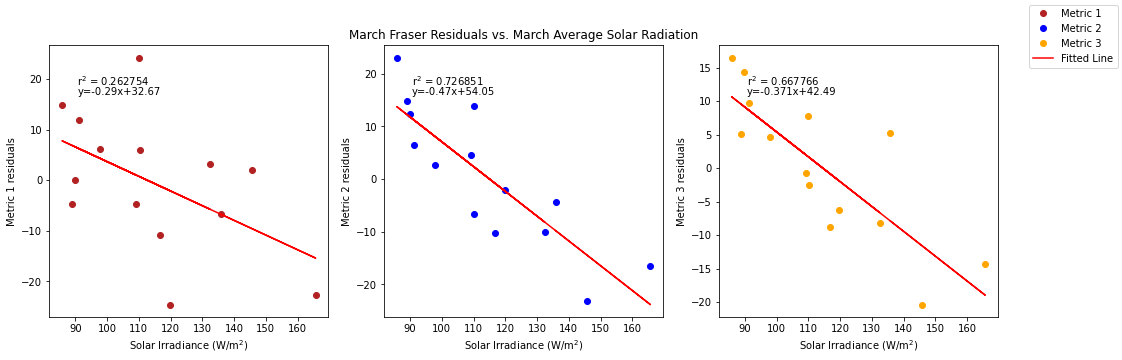

In [111]:
# ---------- Solar ---------
fig4,ax4=plt.subplots(1,3,figsize=(17,5))
ax4[0].plot(solarmar, fraserresid1,'o',color='firebrick',label='Metric 1')
ax4[0].set_xlabel('Solar Irradiance (W/$\mathregular{m^2}$)')
ax4[0].set_ylabel('Metric 1 residuals')
y,r2,m,b=bloomdrivers.reg_r2(solarmar,fraserresid1)
ax4[0].plot(solarmar, y, 'r')
ax4[0].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[0].transAxes)
ax4[0].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[0].transAxes)

ax4[1].plot(solarmar,fraserresid2,'o',color='b',label='Metric 2')
ax4[1].set_xlabel('Solar Irradiance (W/$\mathregular{m^2}$)')
ax4[1].set_ylabel('Metric 2 residuals')
ax4[1].set_title('March Fraser Residuals vs. March Average Solar Radiation')
y,r2,m,b=bloomdrivers.reg_r2(solarmar,fraserresid2)
ax4[1].plot(solarmar, y, 'r')
ax4[1].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[1].transAxes)
ax4[1].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[1].transAxes)

ax4[2].plot(solarmar,fraserresid3,'o',color='orange',label='Metric 3')
ax4[2].set_xlabel('Solar Irradiance (W/$\mathregular{m^2}$)')
ax4[2].set_ylabel('Metric 3 residuals')
y,r2,m,b=bloomdrivers.reg_r2(solarmar,fraserresid3)
ax4[2].plot(solarmar, y, 'r', label='Fitted Line')
ax4[2].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[2].transAxes)
ax4[2].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[2].transAxes)
fig4.legend()

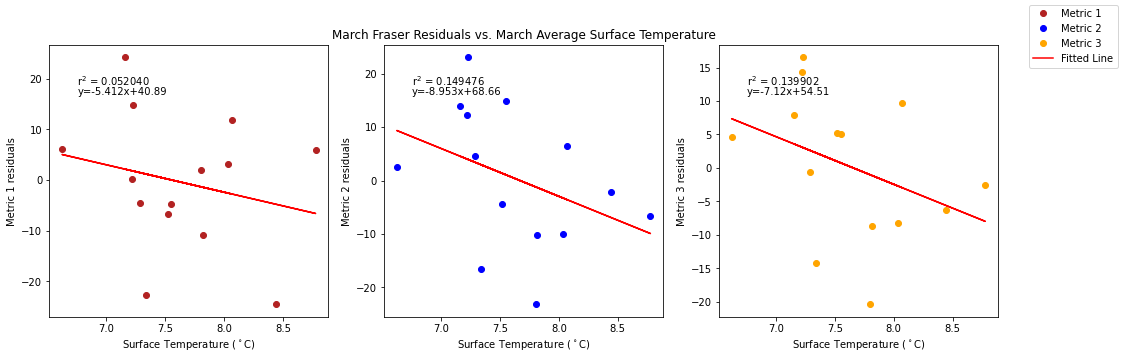

In [112]:
# ---------- Temperature ---------
fig4,ax4=plt.subplots(1,3,figsize=(17,5))
ax4[0].plot(tempmar,fraserresid1,'o',color='firebrick',label='Metric 1')
ax4[0].set_xlabel('Surface Temperature ($^\circ$C)')
ax4[0].set_ylabel('Metric 1 residuals')
y,r2,m,b=bloomdrivers.reg_r2(tempmar,fraserresid1)
ax4[0].plot(tempmar, y, 'r')
ax4[0].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[0].transAxes)
ax4[0].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[0].transAxes)

ax4[1].plot(tempmar,fraserresid2,'o',color='b',label='Metric 2')
ax4[1].set_xlabel('Surface Temperature ($^\circ$C)')
ax4[1].set_ylabel('Metric 2 residuals')
ax4[1].set_title('March Fraser Residuals vs. March Average Surface Temperature')
y,r2,m,b=bloomdrivers.reg_r2(tempmar,fraserresid2)
ax4[1].plot(tempmar, y, 'r')
ax4[1].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[1].transAxes)
ax4[1].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[1].transAxes)

ax4[2].plot(tempmar,fraserresid3,'o',color='orange',label='Metric 3')
ax4[2].set_xlabel('Surface Temperature ($^\circ$C)')
ax4[2].set_ylabel('Metric 3 residuals')
y,r2,m,b=bloomdrivers.reg_r2(tempmar,fraserresid3)
ax4[2].plot(tempmar, y, 'r', label='Fitted Line')
ax4[2].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[2].transAxes)
ax4[2].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[2].transAxes)
fig4.legend()

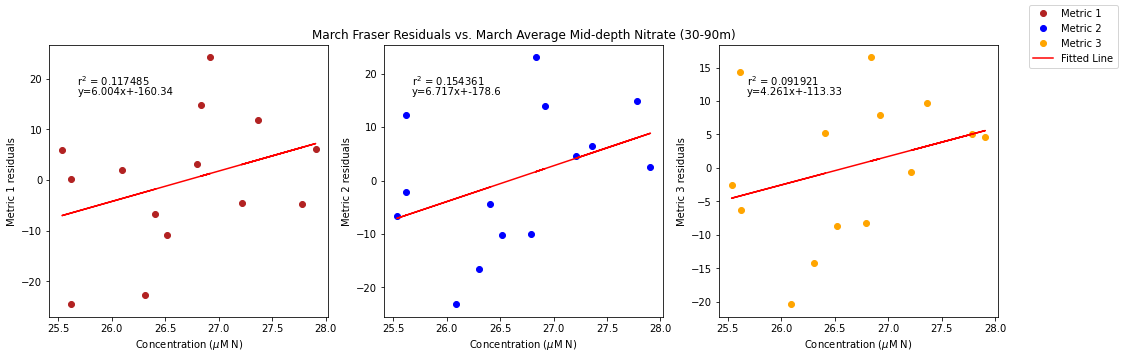

In [113]:
# ---------- Deep NO3 ---------
fig4,ax4=plt.subplots(1,3,figsize=(17,5))
ax4[0].plot(midno3mar,fraserresid1,'o',color='firebrick',label='Metric 1')
ax4[0].set_xlabel('Concentration ($\mu$M N)')
ax4[0].set_ylabel('Metric 1 residuals')
y,r2,m,b=bloomdrivers.reg_r2(midno3mar,fraserresid1)
ax4[0].plot(midno3mar, y, 'r')
ax4[0].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[0].transAxes)
ax4[0].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[0].transAxes)

ax4[1].plot(midno3mar,fraserresid2,'o',color='b',label='Metric 2')
ax4[1].set_xlabel('Concentration ($\mu$M N)')
ax4[1].set_ylabel('Metric 2 residuals')
ax4[1].set_title('March Fraser Residuals vs. March Average Mid-depth Nitrate (30-90m)')
y,r2,m,b=bloomdrivers.reg_r2(midno3mar,fraserresid2)
ax4[1].plot(midno3mar, y, 'r')
ax4[1].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[1].transAxes)
ax4[1].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[1].transAxes)

ax4[2].plot(midno3mar,fraserresid3,'o',color='orange',label='Metric 3')
ax4[2].set_xlabel('Concentration ($\mu$M N)')
ax4[2].set_ylabel('Metric 3 residuals')
y,r2,m,b=bloomdrivers.reg_r2(midno3mar,fraserresid3)
ax4[2].plot(midno3mar, y, 'r', label='Fitted Line')
ax4[2].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[2].transAxes)
ax4[2].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[2].transAxes)
fig4.legend()

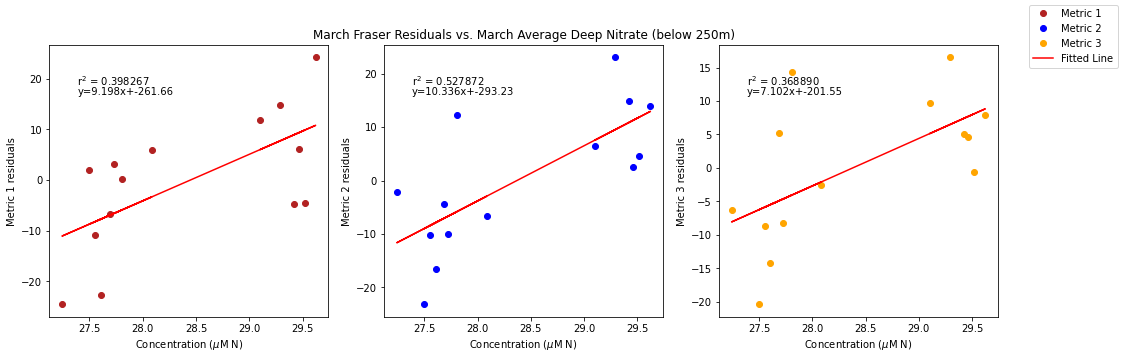

In [114]:
# ---------- Deep NO3 ---------
fig4,ax4=plt.subplots(1,3,figsize=(17,5))
ax4[0].plot(deepno3mar,fraserresid1,'o',color='firebrick',label='Metric 1')
ax4[0].set_xlabel('Concentration ($\mu$M N)')
ax4[0].set_ylabel('Metric 1 residuals')
y,r2,m,b=bloomdrivers.reg_r2(deepno3mar,fraserresid1)
ax4[0].plot(deepno3mar, y, 'r')
ax4[0].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[0].transAxes)
ax4[0].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[0].transAxes)

ax4[1].plot(deepno3mar,fraserresid2,'o',color='b',label='Metric 2')
ax4[1].set_xlabel('Concentration ($\mu$M N)')
ax4[1].set_ylabel('Metric 2 residuals')
ax4[1].set_title('March Fraser Residuals vs. March Average Deep Nitrate (below 250m)')
y,r2,m,b=bloomdrivers.reg_r2(deepno3mar,fraserresid2)
ax4[1].plot(deepno3mar, y, 'r')
ax4[1].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[1].transAxes)
ax4[1].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[1].transAxes)

ax4[2].plot(deepno3mar,fraserresid3,'o',color='orange',label='Metric 3')
ax4[2].set_xlabel('Concentration ($\mu$M N)')
ax4[2].set_ylabel('Metric 3 residuals')
y,r2,m,b=bloomdrivers.reg_r2(deepno3mar,fraserresid3)
ax4[2].plot(deepno3mar, y, 'r', label='Fitted Line')
ax4[2].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[2].transAxes)
ax4[2].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[2].transAxes)
fig4.legend()

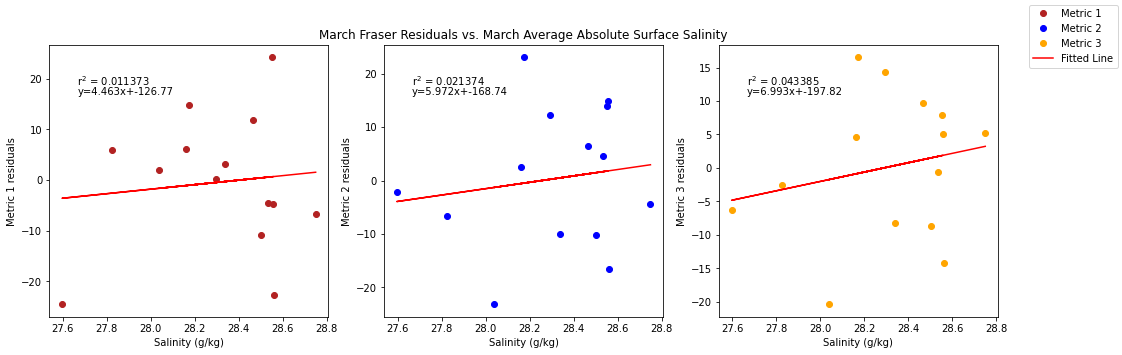

In [115]:
# ---------- Salinity ---------
fig4,ax4=plt.subplots(1,3,figsize=(17,5))
ax4[0].plot(salmar,fraserresid1,'o',color='firebrick',label='Metric 1')
ax4[0].set_xlabel('Salinity (g/kg)')
ax4[0].set_ylabel('Metric 1 residuals')
y,r2,m,b=bloomdrivers.reg_r2(salmar,fraserresid1)
ax4[0].plot(salmar, y, 'r')
ax4[0].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[0].transAxes)
ax4[0].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[0].transAxes)

ax4[1].plot(salmar,fraserresid2,'o',color='b',label='Metric 2')
ax4[1].set_xlabel('Salinity (g/kg)')
ax4[1].set_ylabel('Metric 2 residuals')
ax4[1].set_title('March Fraser Residuals vs. March Average Absolute Surface Salinity')
y,r2,m,b=bloomdrivers.reg_r2(salmar,fraserresid2)
ax4[1].plot(salmar, y, 'r')
ax4[1].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[1].transAxes)
ax4[1].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[1].transAxes)

ax4[2].plot(salmar,fraserresid3,'o',color='orange',label='Metric 3')
ax4[2].set_xlabel('Salinity (g/kg)')
ax4[2].set_ylabel('Metric 3 residuals')
y,r2,m,b=bloomdrivers.reg_r2(salmar,fraserresid3)
ax4[2].plot(salmar, y, 'r', label='Fitted Line')
ax4[2].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[2].transAxes)
ax4[2].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[2].transAxes)
fig4.legend()

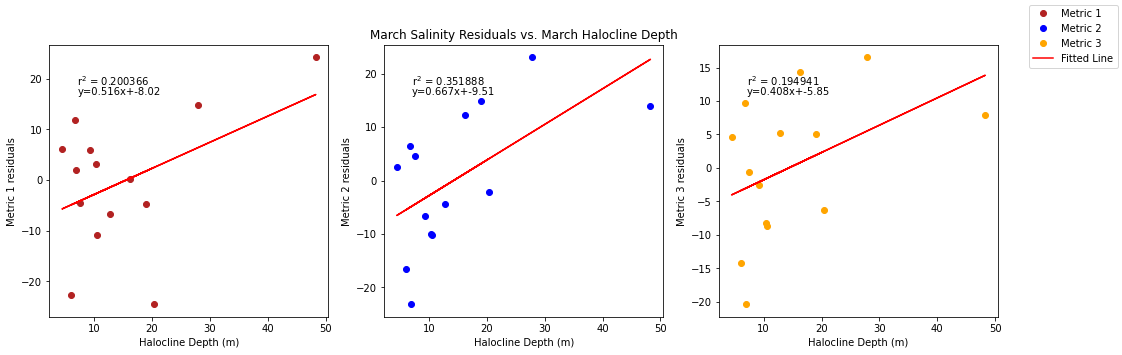

In [116]:
# ---------- Halocline ---------
fig4,ax4=plt.subplots(1,3,figsize=(17,5))
ax4[0].plot(halomar,fraserresid1,'o',color='firebrick',label='Metric 1')
ax4[0].set_xlabel('Halocline Depth (m)')
ax4[0].set_ylabel('Metric 1 residuals')
y,r2,m,b=bloomdrivers.reg_r2(halomar,fraserresid1)
ax4[0].plot(halomar, y, 'r')
ax4[0].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[0].transAxes)
ax4[0].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[0].transAxes)

ax4[1].plot(halomar,fraserresid2,'o',color='b',label='Metric 2')
ax4[1].set_xlabel('Halocline Depth (m)')
ax4[1].set_ylabel('Metric 2 residuals')
ax4[1].set_title('March Salinity Residuals vs. March Halocline Depth')
y,r2,m,b=bloomdrivers.reg_r2(halomar,fraserresid2)
ax4[1].plot(halomar, y, 'r')
ax4[1].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[1].transAxes)
ax4[1].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[1].transAxes)

ax4[2].plot(halomar,fraserresid3,'o',color='orange',label='Metric 3')
ax4[2].set_xlabel('Halocline Depth (m)')
ax4[2].set_ylabel('Metric 3 residuals')
y,r2,m,b=bloomdrivers.reg_r2(halomar,fraserresid3)
ax4[2].plot(halomar, y, 'r', label='Fitted Line')
ax4[2].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[2].transAxes)
ax4[2].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[2].transAxes)
fig4.legend()

### Correlation plots of Halocline residuals

In [117]:
#  residual calculations for each metric
haloresid1=list()
y,r2,m,b=bloomdrivers.reg_r2(halomar,yearday1)
for ind,y in enumerate(yearday1):
    x=halomar[ind]
    haloresid1.append(y-(m*x+b))

haloresid2=list()
y,r2,m,b=bloomdrivers.reg_r2(halomar,yearday2)
for ind,y in enumerate(yearday2):
    x=halomar[ind]
    haloresid2.append(y-(m*x+b))
    
haloresid3=list()
y,r2,m,b=bloomdrivers.reg_r2(halomar,yearday3)
for ind,y in enumerate(yearday3):
    x=halomar[ind]
    haloresid3.append(y-(m*x+b))

In [118]:
dfhalo=pd.DataFrame({'halocine':halomar,'haloresid1':haloresid1,'haloresid2':haloresid2,'haloresid3':haloresid3,'wind':windmar,'solar':solarmar,
                    'temp':tempmar,'fraser':frasermar,'midno3':midno3mar,'deepno3':deepno3mar})

<AxesSubplot:>

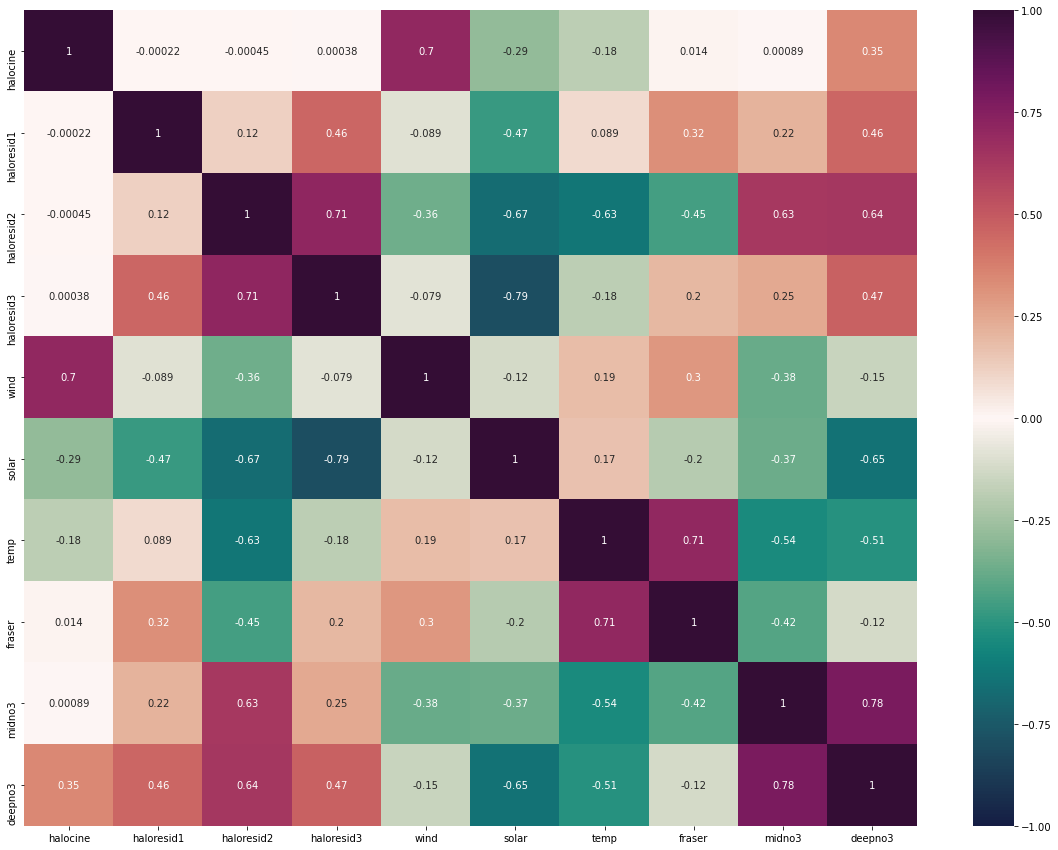

In [119]:
plt.subplots(figsize=(20,15))
cm1=cmocean.cm.curl
sns.heatmap(dfhalo.corr(), annot = True,cmap=cm1,vmin=-1,vmax=1)

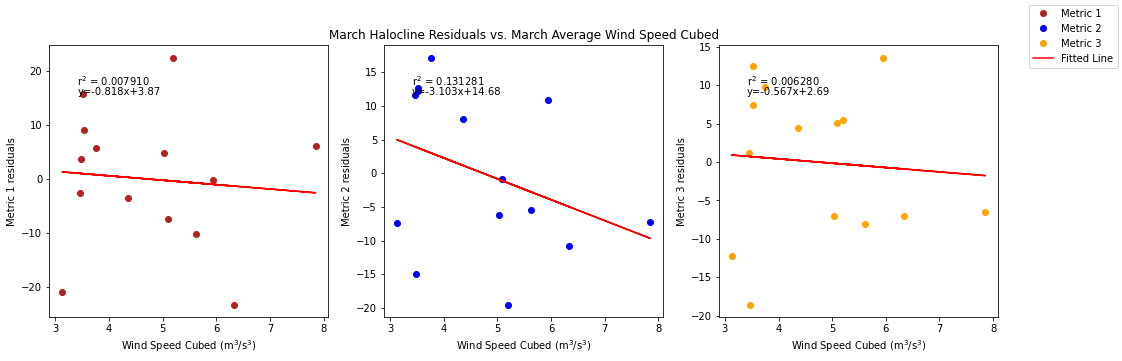

In [120]:
# ---------- wind ---------
fig4,ax4=plt.subplots(1,3,figsize=(17,5))
ax4[0].plot(windmar,haloresid1,'o',color='firebrick',label='Metric 1')
ax4[0].set_xlabel('Wind Speed Cubed ($\mathregular{m^3}$/$\mathregular{s^3}$)')
ax4[0].set_ylabel('Metric 1 residuals')
y,r2,m,b=bloomdrivers.reg_r2(windmar,haloresid1)
ax4[0].plot(windmar, y, 'r')
ax4[0].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[0].transAxes)
ax4[0].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[0].transAxes)

ax4[1].plot(windmar,haloresid2,'o',color='b',label='Metric 2')
ax4[1].set_xlabel('Wind Speed Cubed ($\mathregular{m^3}$/$\mathregular{s^3}$)')
ax4[1].set_ylabel('Metric 2 residuals')
ax4[1].set_title('March Halocline Residuals vs. March Average Wind Speed Cubed')
y,r2,m,b=bloomdrivers.reg_r2(windmar,haloresid2)
ax4[1].plot(windmar, y, 'r')
ax4[1].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[1].transAxes)
ax4[1].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[1].transAxes)

ax4[2].plot(windmar,haloresid3,'o',color='orange',label='Metric 3')
ax4[2].set_xlabel('Wind Speed Cubed ($\mathregular{m^3}$/$\mathregular{s^3}$)')
ax4[2].set_ylabel('Metric 3 residuals')
y,r2,m,b=bloomdrivers.reg_r2(windmar,haloresid3)
ax4[2].plot(windmar, y, 'r', label='Fitted Line')
ax4[2].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[2].transAxes)
ax4[2].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[2].transAxes)
fig4.legend()

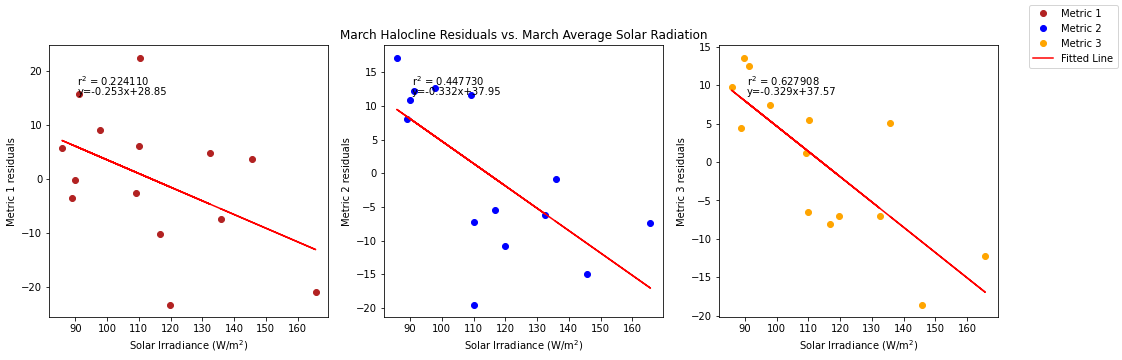

In [121]:
# ---------- Solar ---------
fig4,ax4=plt.subplots(1,3,figsize=(17,5))
ax4[0].plot(solarmar, haloresid1,'o',color='firebrick',label='Metric 1')
ax4[0].set_xlabel('Solar Irradiance (W/$\mathregular{m^2}$)')
ax4[0].set_ylabel('Metric 1 residuals')
y,r2,m,b=bloomdrivers.reg_r2(solarmar,haloresid1)
ax4[0].plot(solarmar, y, 'r')
ax4[0].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[0].transAxes)
ax4[0].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[0].transAxes)

ax4[1].plot(solarmar,haloresid2,'o',color='b',label='Metric 2')
ax4[1].set_xlabel('Solar Irradiance (W/$\mathregular{m^2}$)')
ax4[1].set_ylabel('Metric 2 residuals')
ax4[1].set_title('March Halocline Residuals vs. March Average Solar Radiation')
y,r2,m,b=bloomdrivers.reg_r2(solarmar,haloresid2)
ax4[1].plot(solarmar, y, 'r')
ax4[1].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[1].transAxes)
ax4[1].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[1].transAxes)

ax4[2].plot(solarmar,haloresid3,'o',color='orange',label='Metric 3')
ax4[2].set_xlabel('Solar Irradiance (W/$\mathregular{m^2}$)')
ax4[2].set_ylabel('Metric 3 residuals')
y,r2,m,b=bloomdrivers.reg_r2(solarmar,haloresid3)
ax4[2].plot(solarmar, y, 'r', label='Fitted Line')
ax4[2].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[2].transAxes)
ax4[2].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[2].transAxes)
fig4.legend()

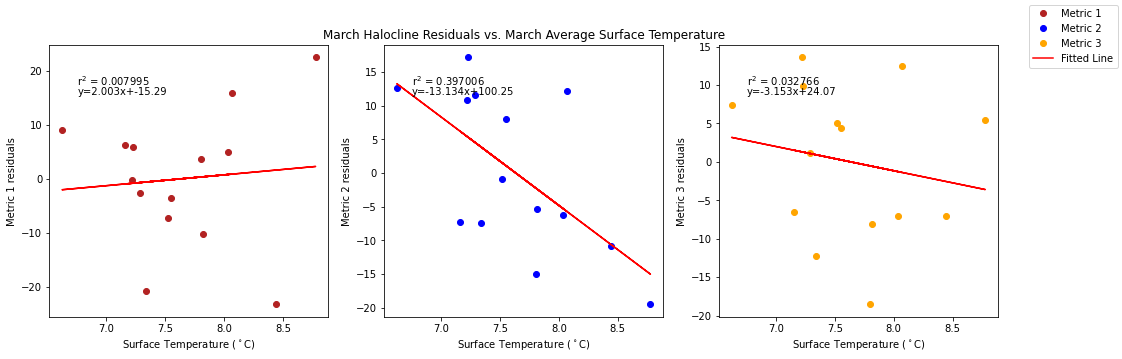

In [122]:
# ---------- Temperature ---------
fig4,ax4=plt.subplots(1,3,figsize=(17,5))
ax4[0].plot(tempmar,haloresid1,'o',color='firebrick',label='Metric 1')
ax4[0].set_xlabel('Surface Temperature ($^\circ$C)')
ax4[0].set_ylabel('Metric 1 residuals')
y,r2,m,b=bloomdrivers.reg_r2(tempmar,haloresid1)
ax4[0].plot(tempmar, y, 'r')
ax4[0].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[0].transAxes)
ax4[0].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[0].transAxes)

ax4[1].plot(tempmar,haloresid2,'o',color='b',label='Metric 2')
ax4[1].set_xlabel('Surface Temperature ($^\circ$C)')
ax4[1].set_ylabel('Metric 2 residuals')
ax4[1].set_title('March Halocline Residuals vs. March Average Surface Temperature')
y,r2,m,b=bloomdrivers.reg_r2(tempmar,haloresid2)
ax4[1].plot(tempmar, y, 'r')
ax4[1].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[1].transAxes)
ax4[1].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[1].transAxes)

ax4[2].plot(tempmar,haloresid3,'o',color='orange',label='Metric 3')
ax4[2].set_xlabel('Surface Temperature ($^\circ$C)')
ax4[2].set_ylabel('Metric 3 residuals')
y,r2,m,b=bloomdrivers.reg_r2(tempmar,haloresid3)
ax4[2].plot(tempmar, y, 'r', label='Fitted Line')
ax4[2].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[2].transAxes)
ax4[2].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[2].transAxes)
fig4.legend()

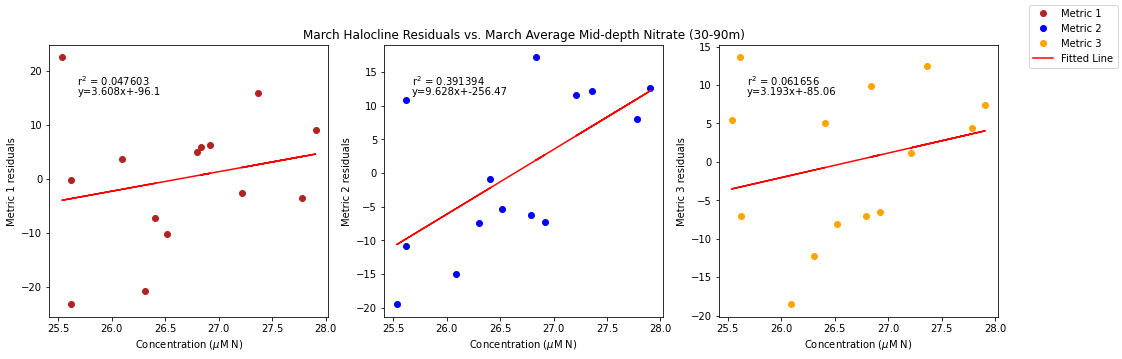

In [123]:
# ---------- Deep NO3 ---------
fig4,ax4=plt.subplots(1,3,figsize=(17,5))
ax4[0].plot(midno3mar,haloresid1,'o',color='firebrick',label='Metric 1')
ax4[0].set_xlabel('Concentration ($\mu$M N)')
ax4[0].set_ylabel('Metric 1 residuals')
y,r2,m,b=bloomdrivers.reg_r2(midno3mar,haloresid1)
ax4[0].plot(midno3mar, y, 'r')
ax4[0].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[0].transAxes)
ax4[0].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[0].transAxes)

ax4[1].plot(midno3mar,haloresid2,'o',color='b',label='Metric 2')
ax4[1].set_xlabel('Concentration ($\mu$M N)')
ax4[1].set_ylabel('Metric 2 residuals')
ax4[1].set_title('March Halocline Residuals vs. March Average Mid-depth Nitrate (30-90m)')
y,r2,m,b=bloomdrivers.reg_r2(midno3mar,haloresid2)
ax4[1].plot(midno3mar, y, 'r')
ax4[1].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[1].transAxes)
ax4[1].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[1].transAxes)

ax4[2].plot(midno3mar,haloresid3,'o',color='orange',label='Metric 3')
ax4[2].set_xlabel('Concentration ($\mu$M N)')
ax4[2].set_ylabel('Metric 3 residuals')
y,r2,m,b=bloomdrivers.reg_r2(midno3mar,haloresid3)
ax4[2].plot(midno3mar, y, 'r', label='Fitted Line')
ax4[2].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[2].transAxes)
ax4[2].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[2].transAxes)
fig4.legend()

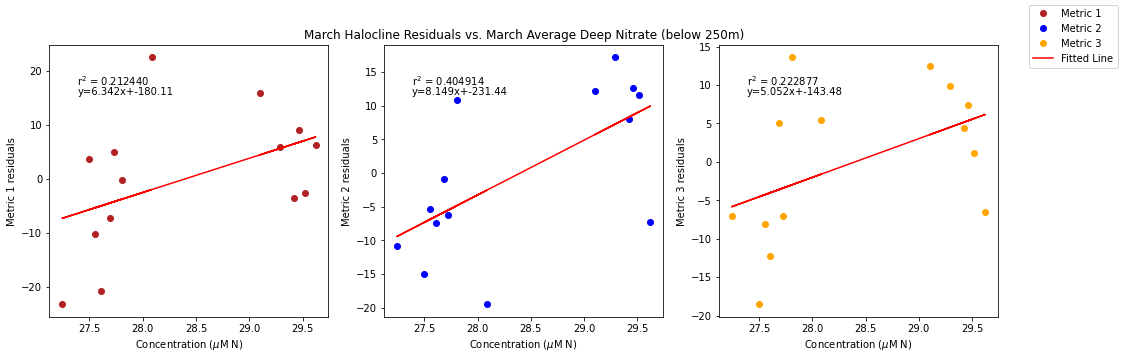

In [124]:
# ---------- Deep NO3 ---------
fig4,ax4=plt.subplots(1,3,figsize=(17,5))
ax4[0].plot(deepno3mar,haloresid1,'o',color='firebrick',label='Metric 1')
ax4[0].set_xlabel('Concentration ($\mu$M N)')
ax4[0].set_ylabel('Metric 1 residuals')
y,r2,m,b=bloomdrivers.reg_r2(deepno3mar,haloresid1)
ax4[0].plot(deepno3mar, y, 'r')
ax4[0].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[0].transAxes)
ax4[0].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[0].transAxes)

ax4[1].plot(deepno3mar,haloresid2,'o',color='b',label='Metric 2')
ax4[1].set_xlabel('Concentration ($\mu$M N)')
ax4[1].set_ylabel('Metric 2 residuals')
ax4[1].set_title('March Halocline Residuals vs. March Average Deep Nitrate (below 250m)')
y,r2,m,b=bloomdrivers.reg_r2(deepno3mar,haloresid2)
ax4[1].plot(deepno3mar, y, 'r')
ax4[1].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[1].transAxes)
ax4[1].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[1].transAxes)

ax4[2].plot(deepno3mar,haloresid3,'o',color='orange',label='Metric 3')
ax4[2].set_xlabel('Concentration ($\mu$M N)')
ax4[2].set_ylabel('Metric 3 residuals')
y,r2,m,b=bloomdrivers.reg_r2(deepno3mar,haloresid3)
ax4[2].plot(deepno3mar, y, 'r', label='Fitted Line')
ax4[2].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[2].transAxes)
ax4[2].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[2].transAxes)
fig4.legend()

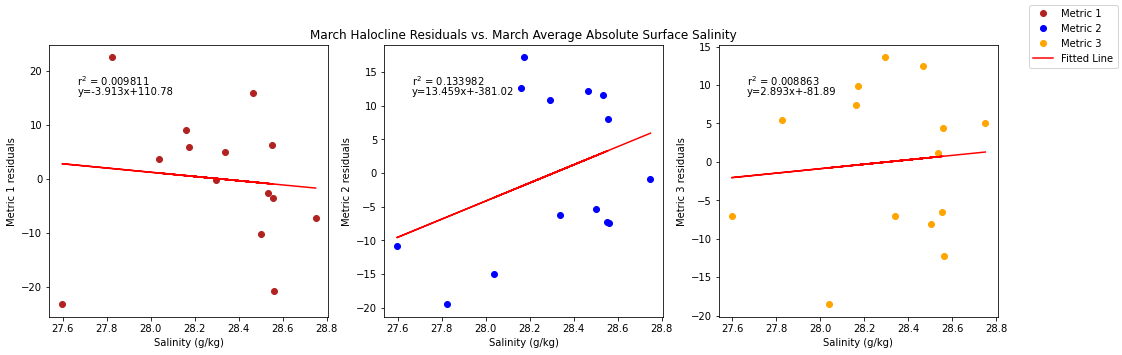

In [125]:
# ---------- Salinity ---------
fig4,ax4=plt.subplots(1,3,figsize=(17,5))
ax4[0].plot(salmar,haloresid1,'o',color='firebrick',label='Metric 1')
ax4[0].set_xlabel('Salinity (g/kg)')
ax4[0].set_ylabel('Metric 1 residuals')
y,r2,m,b=bloomdrivers.reg_r2(salmar,haloresid1)
ax4[0].plot(salmar, y, 'r')
ax4[0].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[0].transAxes)
ax4[0].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[0].transAxes)

ax4[1].plot(salmar,haloresid2,'o',color='b',label='Metric 2')
ax4[1].set_xlabel('Salinity (g/kg)')
ax4[1].set_ylabel('Metric 2 residuals')
ax4[1].set_title('March Halocline Residuals vs. March Average Absolute Surface Salinity')
y,r2,m,b=bloomdrivers.reg_r2(salmar,haloresid2)
ax4[1].plot(salmar, y, 'r')
ax4[1].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[1].transAxes)
ax4[1].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[1].transAxes)

ax4[2].plot(salmar,haloresid3,'o',color='orange',label='Metric 3')
ax4[2].set_xlabel('Salinity (g/kg)')
ax4[2].set_ylabel('Metric 3 residuals')
y,r2,m,b=bloomdrivers.reg_r2(salmar,haloresid3)
ax4[2].plot(salmar, y, 'r', label='Fitted Line')
ax4[2].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[2].transAxes)
ax4[2].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[2].transAxes)
fig4.legend()

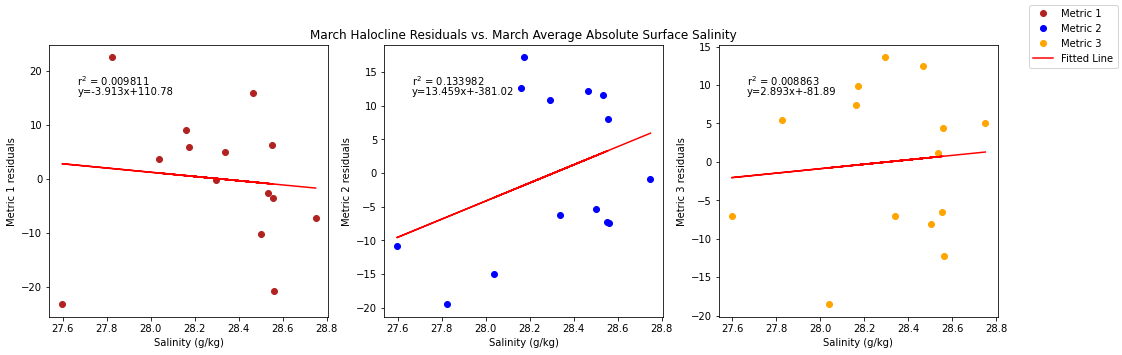

In [126]:
# ---------- Salinity ---------
fig4,ax4=plt.subplots(1,3,figsize=(17,5))
ax4[0].plot(salmar,haloresid1,'o',color='firebrick',label='Metric 1')
ax4[0].set_xlabel('Salinity (g/kg)')
ax4[0].set_ylabel('Metric 1 residuals')
y,r2,m,b=bloomdrivers.reg_r2(salmar,haloresid1)
ax4[0].plot(salmar, y, 'r')
ax4[0].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[0].transAxes)
ax4[0].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[0].transAxes)

ax4[1].plot(salmar,haloresid2,'o',color='b',label='Metric 2')
ax4[1].set_xlabel('Salinity (g/kg)')
ax4[1].set_ylabel('Metric 2 residuals')
ax4[1].set_title('March Halocline Residuals vs. March Average Absolute Surface Salinity')
y,r2,m,b=bloomdrivers.reg_r2(salmar,haloresid2)
ax4[1].plot(salmar, y, 'r')
ax4[1].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[1].transAxes)
ax4[1].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[1].transAxes)

ax4[2].plot(salmar,haloresid3,'o',color='orange',label='Metric 3')
ax4[2].set_xlabel('Salinity (g/kg)')
ax4[2].set_ylabel('Metric 3 residuals')
y,r2,m,b=bloomdrivers.reg_r2(salmar,haloresid3)
ax4[2].plot(salmar, y, 'r', label='Fitted Line')
ax4[2].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[2].transAxes)
ax4[2].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[2].transAxes)
fig4.legend()

### Multiple linear regression

**Correlation with winds (least to greatest)**
* Fraser, temp, salinity, density diffs, midno3, deepno3, halocline, solar, eddy30, eddy15, turbocline

**Correlation with solar**
* Fraser, temp, midno3, halo, sal, density diffs, deepno3, eddy30, eddy15, turbo, wind

**Correlation with temperature**
* density diffs, salinity, halo, solar, turbo, eddy30, eddy15, wind, deepno3, midno3, fraser

**Correlation with midno3**
* density diffs, solar/salinity, halocline, fraser/temp, turbo/eddy30, wind/eddy15, deepno3

**Correlation with deep no3**
* density diffs, Fraser, salinity, halo, solar, turbo, temp, eddy30/eddy15, wind, midno3

**Correlation with salinity**
* Temp, deepno3, midno3, solar, fraser, wind, eddy30,eddy15, turbo, halo, density diffs

**Correlation with fraser**
* Wind, halo, deepno3, eddy30, eddy15, solar/turbo, density diffs, sal, midno3, temp

**Correlation with halocline**
* Fraser, temp, deep no3, midno3/solar, wind, salinity, density diffs, turbo, eddy15, eddy30


**MLR with wind+fraser, and bloom date:**

In [127]:
A=np.vstack((windmar,frasermar,np.ones(np.shape(windmar)))).T
b=yearday2
m=np.linalg.lstsq(A,b,rcond=None)[0]
model, resid = np.linalg.lstsq(A, b,rcond=None)[:2]
r2 = 1 - resid / (len(b) * np.var(b))
p=2 # number of parameters
ar2= 1-(len(b)-1)/(len(b)-p)*(1-r2)
print('Coefficients and intercept:')
print(m)
print('r2 value:')
print(r2)
print('adjusted r2 value:')
print(ar2)

Coefficients and intercept:
[ 2.14687314e+00 -1.25380092e-02  1.03616530e+02]
r2 value:
[0.17484053]
adjusted r2 value:
[0.10607725]


**MLR with wind+temperature, and bloom date:**

In [128]:
A=np.vstack((windmar,tempmar,np.ones(np.shape(windmar)))).T
b=yearday2
m=np.linalg.lstsq(A,b,rcond=None)[0]
model, resid = np.linalg.lstsq(A, b,rcond=None)[:2]
r2 = 1 - resid / (len(b) * np.var(b))
p=2 # number of parameters
ar2= 1-(len(b)-1)/(len(b)-p)*(1-r2)
print('Coefficients and intercept:')
print(m)
print('r2 value:')
print(r2)
print('adjusted r2 value:')
print(ar2)

Coefficients and intercept:
[  2.10951897 -16.58050062 216.71743487]
r2 value:
[0.43483915]
adjusted r2 value:
[0.38774241]


**MLR with wind+temperature+fraser, and bloom date:**

In [129]:
A=np.vstack((windmar,tempmar,frasermar,np.ones(np.shape(windmar)))).T
b=yearday2
m=np.linalg.lstsq(A,b,rcond=None)[0]
model, resid = np.linalg.lstsq(A, b,rcond=None)[:2]
r2 = 1 - resid / (len(b) * np.var(b))
p=3 # number of parameters
ar2= 1-(len(b)-1)/(len(b)-p)*(1-r2)
print('Coefficients and intercept:')
print(m)
print('r2 value:')
print(r2)
print('adjusted r2 value:')
print(ar2)

Coefficients and intercept:
[ 1.94130605e+00 -1.82006613e+01  2.79929885e-03  2.26835849e+02]
r2 value:
[0.43913309]
adjusted r2 value:
[0.33715728]


**MLR with solar+fraser, and bloom date:**

In [130]:
A=np.vstack((solarmar,frasermar,np.ones(np.shape(solarmar)))).T
b=yearday2
m=np.linalg.lstsq(A,b,rcond=None)[0]
model, resid = np.linalg.lstsq(A, b,rcond=None)[:2]
r2 = 1 - resid / (len(b) * np.var(b))
p=2 # number of parameters
ar2= 1-(len(b)-1)/(len(b)-p)*(1-r2)
print('Coefficients and intercept:')
print(m)
print('r2 value:')
print(r2)
print('adjusted r2 value:')
print(ar2)

Coefficients and intercept:
[-4.88632508e-01 -1.55096622e-02  1.72831667e+02]
r2 value:
[0.78654076]
adjusted r2 value:
[0.76875249]


**MLR with solar+temperature, and bloom date:**

In [131]:
A=np.vstack((solarmar,tempmar,np.ones(np.shape(solarmar)))).T
b=yearday2
m=np.linalg.lstsq(A,b,rcond=None)[0]
model, resid = np.linalg.lstsq(A, b,rcond=None)[:2]
r2 = 1 - resid / (len(b) * np.var(b))
p=2 # number of parameters
ar2= 1-(len(b)-1)/(len(b)-p)*(1-r2)
print('Coefficients and intercept:')
print(m)
print('r2 value:')
print(r2)
print('adjusted r2 value:')
print(ar2)

Coefficients and intercept:
[ -0.37390399 -12.99306369 242.03357034]
r2 value:
[0.7801531]
adjusted r2 value:
[0.76183252]


**MLR with solar+fraser+temperature, and bloom date:**

In [132]:
A=np.vstack((solarmar,frasermar,tempmar,np.ones(np.shape(solarmar)))).T
b=yearday2
m=np.linalg.lstsq(A,b,rcond=None)[0]
model, resid = np.linalg.lstsq(A, b,rcond=None)[:2]
r2 = 1 - resid / (len(b) * np.var(b))
p=3 # number of parameters
ar2= 1-(len(b)-1)/(len(b)-p)*(1-r2)
print('Coefficients and intercept:')
print(m)
print('r2 value:')
print(r2)
print('adjusted r2 value:')
print(ar2)

Coefficients and intercept:
[-4.34575239e-01 -9.10957082e-03 -7.04521981e+00  2.13472455e+02]
r2 value:
[0.8182183]
adjusted r2 value:
[0.78516709]


**MLR with solar+wind+fraser, and bloom date:**

In [133]:
A=np.vstack((solarmar,windmar,frasermar,np.ones(np.shape(solarmar)))).T
b=yearday2
m=np.linalg.lstsq(A,b,rcond=None)[0]
model, resid = np.linalg.lstsq(A, b,rcond=None)[:2]
r2 = 1 - resid / (len(b) * np.var(b))
p=3 # number of parameters
ar2= 1-(len(b)-1)/(len(b)-p)*(1-r2)
print('Coefficients and intercept:')
print(m)
print('r2 value:')
print(r2)
print('adjusted r2 value:')
print(ar2)

Coefficients and intercept:
[-4.82796975e-01  1.59249499e+00 -1.68083496e-02  1.66036934e+02]
r2 value:
[0.80854334]
adjusted r2 value:
[0.77373304]


**MLR with solar+wind+temperature, and bloom date:**

In [134]:
A=np.vstack((solarmar,windmar,tempmar,np.ones(np.shape(solarmar)))).T
b=yearday2
m=np.linalg.lstsq(A,b,rcond=None)[0]
model, resid = np.linalg.lstsq(A, b,rcond=None)[:2]
r2 = 1 - resid / (len(b) * np.var(b))
p=3 # number of parameters
ar2= 1-(len(b)-1)/(len(b)-p)*(1-r2)
print('Coefficients and intercept:')
print(m)
print('r2 value:')
print(r2)
print('adjusted r2 value:')
print(ar2)

Coefficients and intercept:
[ -0.36373481   1.12481379 -13.57646466 239.99888187]
r2 value:
[0.79154472]
adjusted r2 value:
[0.75364376]


**MLR with density differences+temperature, and bloom date:**

In [135]:
A=np.vstack((densdiff10mar,tempmar,np.ones(np.shape(densdiff10mar)))).T
b=yearday2
m=np.linalg.lstsq(A,b,rcond=None)[0]
model, resid = np.linalg.lstsq(A, b,rcond=None)[:2]
r2 = 1 - resid / (len(b) * np.var(b))
p=2 # number of parameters
ar2= 1-(len(b)-1)/(len(b)-p)*(1-r2)
print('Coefficients and intercept:')
print(m)
print('r2 value:')
print(r2)
print('adjusted r2 value:')
print(ar2)

Coefficients and intercept:
[-21.80444922 -15.98658661 231.80771898]
r2 value:
[0.48849434]
adjusted r2 value:
[0.44586886]


**MLR with midno3+solar, and bloom date:**

In [136]:
A=np.vstack((solarmar,midno3mar,np.ones(np.shape(solarmar)))).T
b=yearday2
m=np.linalg.lstsq(A,b,rcond=None)[0]
model, resid = np.linalg.lstsq(A, b,rcond=None)[:2]
r2 = 1 - resid / (len(b) * np.var(b))
p=2 # number of parameters
ar2= 1-(len(b)-1)/(len(b)-p)*(1-r2)
print('Coefficients and intercept:')
print(m)
print('r2 value:')
print(r2)
print('adjusted r2 value:')
print(ar2)

Coefficients and intercept:
[-0.35974618  5.46987316 -4.46106616]
r2 value:
[0.59154945]
adjusted r2 value:
[0.5575119]


**MLR with midno3+wind, and bloom date:**

In [137]:
A=np.vstack((windmar,midno3mar,np.ones(np.shape(solarmar)))).T
b=yearday2
m=np.linalg.lstsq(A,b,rcond=None)[0]
model, resid = np.linalg.lstsq(A, b,rcond=None)[:2]
r2 = 1 - resid / (len(b) * np.var(b))
p=2 # number of parameters
ar2= 1-(len(b)-1)/(len(b)-p)*(1-r2)
print('Coefficients and intercept:')
print(m)
print('r2 value:')
print(r2)
print('adjusted r2 value:')
print(ar2)

Coefficients and intercept:
[   3.32371453   11.88440853 -232.15342312]
r2 value:
[0.36567374]
adjusted r2 value:
[0.31281322]


**MLR with midno3+solar+wind, and bloom date:**

In [138]:
A=np.vstack((solarmar,windmar,midno3mar,np.ones(np.shape(solarmar)))).T
b=yearday2
m=np.linalg.lstsq(A,b,rcond=None)[0]
model, resid = np.linalg.lstsq(A, b,rcond=None)[:2]
r2 = 1 - resid / (len(b) * np.var(b))
p=3 # number of parameters
ar2= 1-(len(b)-1)/(len(b)-p)*(1-r2)
print('Coefficients and intercept:')
print(m)
print('r2 value:')
print(r2)
print('adjusted r2 value:')
print(ar2)

Coefficients and intercept:
[ -0.33187456   1.58500972   6.86442791 -52.29620558]
r2 value:
[0.61027585]
adjusted r2 value:
[0.53941692]
